# Always Required

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import copy
from tqdm.notebook import tqdm

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

from scipy.signal import find_peaks
from scipy.stats import chi2
from scipy.optimize import curve_fit
from pygama.flow import DataLoader
from pygama.flow import FileDB
from lgdo import Array
from lgdo import Struct
from lgdo import LH5Store
from pygama.math import histogram as pgh
from pygama.math import peak_fitting as pf

In [2]:
mpl.rcParams["font.family"] = "serif"


## FileDB and DataLoader Setup

### From Scratch

In [ ]:
fdb = FileDB(config="../processing/metadata/dataloader_configs/cage_filedb_config.json", scan=True)
fdb.scan_tables_columns()
fdb.to_disk("../processing/cage_filedb.lh5", "o")

In [ ]:
dl = DataLoader(config="../processing/metadata/dataloader_configs/cage_loader_config.json",
                filedb=fdb)

### Load Existing

In [3]:
fdb = FileDB("../processing/cage_filedb.lh5")

In [ ]:
# Run this if FDB needs to be updated and then re-saved to disk
og_col = fdb.columns
fdb.scan_files()
fdb.set_file_status()
fdb.set_file_sizes()
fdb.scan_tables_columns()
assert fdb.columns == og_col
fdb.to_disk("../processing/cage_filedb.lh5", "o")

In [4]:
dl = DataLoader(config="../processing/metadata/dataloader_configs/cage_loader_config.json",
                filedb=fdb)

## Helper Function Setup

In [5]:
# Stolen from Clint
# Fit functions
from scipy.special import erfc, legendre

# Component functions for the peak shape
def gaus(E, A, f_le, mu, sig, f_he):
    """
    A: total number of counts (i.e. peak area)
    mu, sig : gaussian
    f_le, f_he : fraction of low E and high E tail components
    """
    # assert np.abs(f_le + f_he) <= 1, 'Tail fractions cant be larger than 1'
    norm = A * (1 - f_he - f_le) / (np.sqrt(2*np.pi) * sig)
    return norm * np.exp(-(E-mu)**2 / (2 * sig**2))


def tail(E, A, mu, sig, f, gamma, alpha):
    """
    gamma : decay constant of the tail exponential
    """
    assert alpha == 1 or alpha == -1, 'alpha is the sign choice +/- 1'
    norm = A * f / (2 * gamma)
    expo = np.exp((sig**2) / (2*gamma**2) + alpha * ((E-mu) / gamma))
    erf = erfc((sig) / (np.sqrt(2)*gamma) + alpha * ( (E-mu) / (np.sqrt(2)*sig) ))
    return norm * expo * erf

def step(E, A, H, mu, sig):
    """
    H : height of step bkg as a fraction of the peak area
    """
    norm = A * H / 2
    erf = erfc( (E - mu) / (np.sqrt(2)*sig) )
    return norm * erf

def bkg_legendre(E, q, m, b, E_cen, elo):
    """
    sum of legendre polynomials, making a quadratic, linear, or flat function.
    for linear bkg, q = 0.  for flat bkg, q = m = 0.
    FIXME, DONTUSE: need to scale-shift the x limits [-1, 1] to the fit window [elo, ehi].
    - This is not necessary for our PEPV-1A analysis, a linear bkg is sufficient.
    """
    # these are np.poly1d objects defined on [-1, 1]
    legP2 = legendre(2) # = 1.5 * x - 0.5
    legP1 = legendre(1) # = x
    return q * legP2(E - E_cen) + m * legP1(E - E_cen) + b

def bkg_simple(E, q, m, b):
    """
    Use this instead.
    """
    return q * E**2 + m * E + b

# Composite functions for the peak shape + bkg + echo peak
def peakshape(E, A, mu, sig, f, gamma, H, q, m, b):
    """
    This is bkg peak (main peak) plus background, written to match the Majorana 2023 calibration paper.
    Includes a term for the background function, which will also cover the echo peak region.
    
    SIX floating terms per peak are needed, with ONE to THREE more for the bkg polynomial.
    In reality these terms all depend on energy & vary with energy,
    but the parameterization (eqs. 2.7-2.14) can be ignored for this DEP/SEP analysis.
    
    NOTE: The low energy tail was reduced, and the high energy tail made negligible, 
    through optimizations in energy estimation described in [26].
    """
    G = gaus(E, A, f, mu, sig, 0) # fix f_he to 0
    T_low = tail(E, A, mu, sig, f, gamma, 1) # alpha = 1 for LE, -1 for HE
    # T_high = tail(E, A, mu, sig, f_he, gamma_he, -1) # not used
    S = step(E, A, H, mu, sig)
    # B = bkg_legendre(E, E_cen, q, m, b) # not used
    B = bkg_simple(E, q, m, b)
    return G + T_low + S + B

def peak_only(E, A, mu, sig, f, gamma, H):
    """
    Use this to model the echo peak
    """
    G = gaus(E, A, f, mu, sig, 0)
    T_low = tail(E, A, mu, sig, f, gamma, 1)
    S = step(E, A, H, mu, sig)
    return G + T_low + S

def peak_plus_echo(E, branching_ratio, A, mu, sig, f, gamma, H, q, m, b):
    """
    This is the main peak plus the echo peak. The 'branching ratio' gives the relative ratio of the two. 
    They share the same parameters except the height and the location.
    """
    y_bkg = peakshape(E, A, mu, sig, f, gamma, H, q, m, b)
    y_echo = peak_only(E, A * branching_ratio, mu + 10.6, sig, f, gamma, H)
    y_total = y_bkg + y_echo
    return y_total

def negativeloglikelihood(branching_ratio, A, mu, sig, f, gamma, f_he, H, q, m, b):
    """
    Wilks' theorem: 2 * NLL goes as a chi^2 distribution.
    1. At each bin, get the probability of having n counts (n is from data) from m expected (m is from the model). 
       This is done by assuming the Poisson statistics.
    2. Take the logarithm, and sum them up over the entire fit range. (summation is from i=1 up to i=number_of_bins)
    3. Multiply by -1 to get negative log-likelihood.  
    """
    yfit = peak_plus_echo(x, branching_ratio, A, mu, sig, f, gamma, f_he, H, q, m, b)
    probs = poisson.pmf(y, yfit) # step 1
    nll = -np.sum(np.log(probs)) # step 2 and step 3
    return nll

In [6]:
# helper functions
def get_runtime(data):
    '''
    Returns runtime for a run
    '''
    if 'timestamp' not in data.keys():
        return np.sum([get_runtime(data[key]) for key in data.keys()])
    clock = 100e6 # 100 MHz

    ts = data['timestamp'].nda / clock # converts to float
    
    rt = ts[-1] - ts[0]

    return rt 



# compute some stats
# ref: slide 3, https://www.nbi.dk/~petersen/Teaching/Stat2016/Week7/AS2016_0109_AdvancedFitting.pdf
def get_chisquare(hh, y_model, sr_pars, cl=0.9):
    ndf = len(hh) - len(sr_pars) 
    chisquare = np.sum((hh - y_model)**2 / y_model) # pearson.  no one likes neyman.
    chisquare_ndf = chisquare / ndf
    p_value = chi2.sf(chisquare, ndf)
    hyp_rej = p_value < (1-cl) # if True, we have a BAD fit - the model DOESN'T describe the data.
    goodfit = 'T' if not hyp_rej else 'F'
    return chisquare_ndf, p_value, hyp_rej, goodfit


def fit_peak(hist, ebins, guess, plot=False, n_bins=40, max_attempts = 3, recursed=False, cl=1 - 1e-5):
    '''
    Attempts to fit the histogram near guess (given in units of ebins, not index) 
    If the fit is not great, will try again with different number of bins to fit over up to max_attempts times
    '''
    ebin_centers = pgh.get_bin_centers(ebins)
    guess_idx = np.argmin(np.abs(ebins - guess))
    glo = guess_idx - int(n_bins)
    ghi = guess_idx + int(n_bins)
    
    thresh = (np.average(hist[glo:glo+10]) + np.average(hist[ghi-10 : ghi]) ) / 2
    
    peaks, p_props = find_peaks(hist[glo : ghi], height=thresh)
    
    peak_idx = peaks[np.argmax(p_props['peak_heights'])] + glo
    lo = peak_idx - int(n_bins/2)
    hi = peak_idx + int(n_bins/2)
    
    init = {'A': hist[lo:hi].sum(), 
            'mu': ebin_centers[peak_idx], 
            'sig': (ebins[hi]-ebins[lo])/5, 
            'f_le': 0.14,
            'gamma': 1.02, 
            'H' : 0.01, 
            'q': -0.0001, 
            'm': 0.01, 
            'b': 1000,
            }
    sr_par0 = pd.Series(init)
    bounds_dep = {  
        'A' : [0, hist.sum()],
        'mu' : [ebin_centers[lo], ebin_centers[hi]],
        'sig' : [0, 20], 
        'f_le' : [0, 1],
        'gamma' : [0, np.inf],
        'H': [0, 1],
        'q' : [-np.inf, np.inf], # don't bound these, we want them to be as good as possible
        'm' : [-np.inf, np.inf],
        'b' : [-np.inf, np.inf]
    }
    sr_bounds0 = pd.Series(bounds_dep)
    
    # curve_fit requires a 2-tuple of array_like.  bounds = ((lower), (upper)).
    # each element of the tuple must be either an array with the length equal to the number of parameters.
    bnd_lo, bnd_hi = [], []
    for key in sr_par0.index:
        if key in sr_bounds0.index:
            bnd_lo.append(sr_bounds0[key][0])
            bnd_hi.append(sr_bounds0[key][1])
            
    try:
        popt, pcov = curve_fit(peakshape, ebin_centers[lo:hi], hist[lo:hi], p0=sr_par0, bounds=(bnd_lo, bnd_hi))
        chisq, _, hyp_rej, _ = get_chisquare(hist[lo:hi], peakshape(ebin_centers[lo:hi], *popt), popt, cl=cl)
    except RuntimeError:
        popt = sr_par0
        pcov = None
        chisq = 1e5
        hyp_rej = True
    
    if recursed:
        return popt, pcov, lo, hi
    
    n_attempts = 0
    n_bins_attempts = [f(x) for x in np.arange(max_attempts)+1 for f in (lambda x: n_bins + 10*x, lambda x: n_bins - 10*x)]
    while n_attempts < max_attempts and hyp_rej: 
        # print("Trying again...")
        g_popt, g_pcov, g_lo, g_hi = fit_peak(hist, ebins, popt[1], plot=False, n_bins=n_bins_attempts[n_attempts], recursed=True)
        g_chisq, _, g_hyp_rej, _ = get_chisquare(hist[lo:hi], peakshape(ebin_centers[lo:hi], *g_popt), g_popt, cl=cl)
        l_popt, l_pcov, l_lo, l_hi = fit_peak(hist, ebins, popt[1], plot=False, n_bins=n_bins_attempts[n_attempts + 1], recursed=True)
        l_chisq, _, l_hyp_rej, _ = get_chisquare(hist[lo:hi], peakshape(ebin_centers[lo:hi], *l_popt), l_popt, cl=cl)
        
        choices = [(popt, pcov, hyp_rej, lo, hi), (g_popt, g_pcov, g_hyp_rej, g_lo, g_hi), (l_popt, l_pcov, l_hyp_rej, l_lo, l_hi)]
        choice = np.argmin([chisq, g_chisq, l_chisq])
        # str_choices = ["old", "bigger", "smaller"]
        # print(f"Best was {str_choices[choice]}")
        popt, pcov, hyp_rej, lo, hi = choices[choice]
        n_attempts += 1    
    
    if plot:
        plt.figure()
        pgh.plot_hist(hist[lo-10 : hi+10], ebins[lo-10 : hi + 11])
        plt.plot(ebin_centers[lo:hi], peakshape(ebins[lo:hi], *sr_par0), label="initial")
        plt.plot(ebin_centers[lo:hi], peakshape(ebins[lo:hi], *popt), label="fit")
        plt.yscale('log')
        plt.legend()
    
    return popt, pcov, hyp_rej

def calibrate_energy(energy, ebins, plot=False):
    '''
    Makes energy histogram, then fits the 1460 keV peak
    Simple linear scaling to get the calibrated energies
    '''
    hist, _ = np.histogram(energy, ebins)
    
    third = int(len(ebins)/3)
    k40_idx = np.argmax(hist[third:]) + third
            
    popt, pcov, hyp_rej = fit_peak(hist, ebins, ebins[k40_idx], plot=plot)
    
    k40_mu = popt[1]
    return np.array(energy*1460.8/k40_mu), 1460.8/k40_mu

def calibrate_toe(toe, toe_bins, plot=False):
    '''
    Makes energy histogram, then fits the 1460 keV peak
    Simple linear scaling to get the calibrated energies
    '''
    hist, _ = np.histogram(toe, toe_bins)
    
    
    
    third = int(len(ebins)/3)
    k40_idx = np.argmax(hist[third:]) + third
            
    popt, pcov, hyp_rej = fit_peak(hist, ebins, ebins[k40_idx], plot=plot)
    
    k40_mu = popt[1]
    return np.array(energy*1460.8/k40_mu), 1460.8/k40_mu

ebins = np.linspace(0, 7000, 12000)
cal_ebins = np.linspace(0, 4000, 8000)
dcr_bins = np.arange(-50, 200)
tp20_bins = np.arange(0, 1500, 10)
tp90_bins = np.arange(0, 1500, 10)
toe_bins = np.linspace(0, 1, 1000)
lt_bins = np.linspace(-2.5e-4, -0.5e-4, 1000)

bins = {
    "trapEmax_ctc": ebins,
    "cal_trapEmax_ctc": cal_ebins,
    "dcr": dcr_bins,
    "tp_20": tp20_bins,
    "tp_90": tp90_bins,
    "ToE": toe_bins,
    "lt_slope": lt_bins
}

## Loading Data

We want to set up some information that's going to make looking up information easier as we do analysis. This is going to look kind of like a section of the RunDB, but in table format. It's also going to include a column for which `dataset` the run is in i.e. if we're trying to compare two scans, does it belong in scan A or scan B. 

In [7]:
rdb_cols = ['dataset', 'type', 'rotary', 'linear', 'source']
runs = {
    494: [0, 'bkg', 0, -2.5, 0], 
    495: [0, 'bkg', 0, -2.5, 0], 
    496: [0, 'alp', 0, 0, -180],
    500: [0, 'alp', 0, 1, -180],
    501: [0, 'alp', 0, 2, -180],
    502: [0, 'alp', 0, 3, -180],
    503: [0, 'alp', 0, 4, -180],
    504: [0, 'alp', 0, 5, -180],
    505: [0, 'alp', 0, 6, -180],
    506: [0, 'alp', 0, 7, -180],
    507: [0, 'alp', 0, 8, -180],
    508: [0, 'alp', 0, 9, -180],
    509: [0, 'alp', 0, 10, -180],
    510: [0, 'alp', 0, 12, -180],
    511: [0, 'alp', 0, 13, -180],
    512: [0, 'alp', 0, 14, -180],
    513: [0, 'alp', 0, 15, -180],
    514: [0, 'alp', 0, 16, -180],
    520: [1, 'bkg', 0, -2.5, 0],
    521: [1, 'bkg', 0, -2.5, 0], 
    522: [1, 'bkg', 0, 16, 0], 
    523: [1, 'bkg', 0, 14, 0], 
    524: [1, 'bkg', 0, 12, 0], 
    525: [1, 'alp', 0, 10, -180], 
    526: [1, 'alp', 0, 8, -180], 
    527: [1, 'alp', 0, 6, -180], 
    528: [1, 'alp', 0, 4, -180], 
    529: [1, 'alp', 0, 2, -180], 
    530: [1, 'alp', 0, 0, -180],
    531: [1, 'alp', 0, 12, -180],
    532: [1, 'alp', 0, 14, -180],
    533: [1, 'bkg', 0, 16, 0],
    534: [1, 'alp', 0, 16, -180]
}
rdb_df = pd.DataFrame.from_dict(runs, orient='index', columns=rdb_cols)
rdb_df.sort_values(by=['dataset', 'type', 'rotary', 'linear', 'source'], inplace=True)
display(rdb_df)

dataset type  rotary  linear  source
496        0  alp       0     0.0    -180
500        0  alp       0     1.0    -180
501        0  alp       0     2.0    -180
502        0  alp       0     3.0    -180
503        0  alp       0     4.0    -180
504        0  alp       0     5.0    -180
505        0  alp       0     6.0    -180
506        0  alp       0     7.0    -180
507        0  alp       0     8.0    -180
508        0  alp       0     9.0    -180
509        0  alp       0    10.0    -180
510        0  alp       0    12.0    -180
511        0  alp       0    13.0    -180
512        0  alp       0    14.0    -180
513        0  alp       0    15.0    -180
514        0  alp       0    16.0    -180
494        0  bkg       0    -2.5       0
495        0  bkg       0    -2.5       0
530        1  alp       0     0.0    -180
529        1  alp       0     2.0    -180
528        1  alp       0     4.0    -180
527        1  alp       0     6.0    -180
526        1  alp       0     8.0    -180
525        1  alp       0    10.0    -180
531        1  alp       0    12.0    -180
532        1  alp       0    14.0    -180
534        1  alp       0    16.0    -180
520        1  bkg       0    -2.5       0
521        1  bkg       0    -2.5       0
524        1  bkg       0    12.0       0
523        1  bkg       0    14.0       0
522        1  bkg       0    16.0       0
533        1  bkg       0    16.0       0

In [8]:
sto = LH5Store()
loaded_file = "icpc_scan_data.lh5"

In [9]:
par_names = ["trapEmax_ctc", "dcr", "ToE", "timestamp", "tp_0", "tp_10", "tp_20", "tp_90", "lt_slope"]

### From Scratch

This will call the DataLoader functions to grab the data from disk and save the relevant portions to a Struct in `loaded_file`. Alpha and background runs will be separated. 

Alpha data will be saved in a Struct, where the keys are run numbers.
Background data will not be separated by run. 

In [ ]:
data = {}

for ds, ds_df in rdb_df.groupby(by="dataset"):
    print(f"Loading dataset {ds}")
    if ds not in data.keys():
        data[ds] = {}
    for t, t_df in ds_df.groupby(by="type"):
        print(f"Loading {t} data...")
        display(t_df)
        if t == "alp":
            alp_data = Struct(attrs={'int_keys': True})
            for run in t_df.index:
                dl.reset()
                dl.set_files(f"run == {run}")
                dl.set_output(merge_files=False, columns=par_names)
                d = dl.load()
                alp_data[run] = d
            alp_data.update_datatype()
            sto.write_object(alp_data, f"{t}_{ds}", loaded_file, wo_mode='o')
            data[ds][t] = alp_data
        else:
            dl.reset()
            dl.set_files(f"run in {list(ds_df.index)}")
            dl.set_output(merge_files=False, columns=par_names)
            d = dl.load()
            sto.write_object(d, f"{t}_{ds}", loaded_file, wo_mode='o')
            data[ds][t] = d
        print(f"Saved in {loaded_file}/{t}_{ds}")
        

### Load Existing

In [10]:
data = {}
for ds, ds_df in rdb_df.groupby(by="dataset"):
    print(f"Loading dataset {ds}")
    if ds not in data.keys():
        data[ds] = {}
    for t, t_df in ds_df.groupby(by="type"):
        data[ds][t], _ = sto.read_object(f"{t}_{ds}", loaded_file)

Loading dataset 0
Loading dataset 1


## Runtimes and Energy Calibration

In [ ]:
# This is just to visualize what the fit is doing to the 1460 keV peak
calibrate_energy(data[1]['alp'][525][4404]['trapEmax_ctc'].nda, ebins, True)

In [11]:
rdb_df['cal_constant'] = np.nan
for ds, ds_df in rdb_df.groupby(by="dataset"):
    print(f"Calculating runtime and energy for dataset {ds}")
    for t, t_df in ds_df.groupby(by="type"):
        if t == "alp":
            for run in t_df.index:
                if 'rt' in data[ds][t][run]:
                    data[ds][t][run].pop('rt')
                for file in data[ds][t][run]:
                    cal_energies, cal_constants = calibrate_energy(data[ds][t][run][file]['trapEmax_ctc'].nda, ebins)
                    data[ds][t][run][file]['cal_trapEmax_ctc'] = Array(nda=cal_energies)
                    rdb_df.at[run, 'cal_constant'] = cal_constants
                    
                data[ds][t][run]['rt'] = get_runtime(data[ds][t][run])
        else:
            if 'rt' in data[ds][t]:
                    data[ds][t].pop('rt')
            for file in data[ds][t]:
                cal_energies, cal_constants = calibrate_energy(data[ds][t][file]['trapEmax_ctc'].nda, ebins)
                data[ds][t][file]['cal_trapEmax_ctc'] = Array(nda=cal_energies)
                run = fdb.df.loc[file]['run']
                rdb_df.at[run, 'cal_constant'] = cal_constants
            data[ds][t]['rt'] = get_runtime(data[ds][t])

Calculating runtime and energy for dataset 0
Calculating runtime and energy for dataset 1


# Energy Histograms

**Pre-Reqs**: None

**Human Input**: None

You should probably run this section just to have the histograms available for reference later. 
The saved histograms will not be normalized by runtime, but the plots do the normalization for display purposes.

## Backgrounds - Uncalibrated

In [12]:
# Make the histograms
bkg_uncal_spec = {}
for ds, ds_df in rdb_df.groupby(by="dataset"):
    spec = None
    for file in data[ds]["bkg"].keys():
        if file == 'rt':
            continue
        if spec is None:
            spec = np.histogram(data[ds]["bkg"][file]['trapEmax_ctc'], bins=ebins)[0]
        else:
            spec += np.histogram(data[ds]["bkg"][file]['trapEmax_ctc'], bins=ebins)[0]
    bkg_uncal_spec[ds] = spec


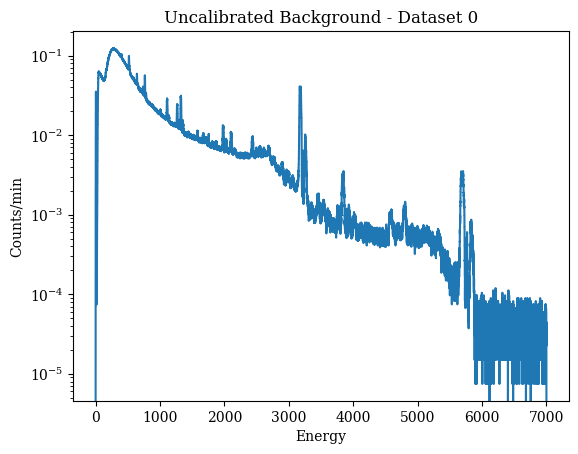

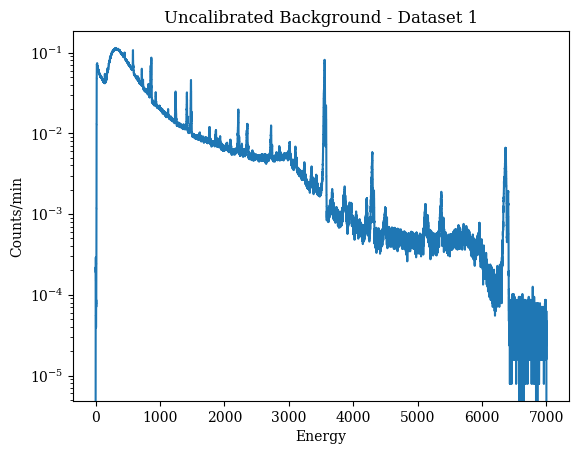

In [13]:
# Plot the histograms
for ds in bkg_uncal_spec:
    plt.figure()
    pgh.plot_hist(bkg_uncal_spec[ds]/data[ds]['bkg']['rt'], bins=ebins)
    plt.yscale('log')
    plt.title(f"Uncalibrated Background - Dataset {ds}")
    plt.xlabel("Energy")
    plt.ylabel("Counts/min")

## Backgrounds - Calibrated

In [14]:
# Make the histograms
bkg_cal_spec = {}
for ds, ds_df in rdb_df.groupby(by="dataset"):
    spec = None
    for file in data[ds]["bkg"].keys():
        if file == 'rt':
            continue
        if spec is None:
            spec = np.histogram(data[ds]["bkg"][file]['cal_trapEmax_ctc'], bins=cal_ebins)[0]
        else:
            spec += np.histogram(data[ds]["bkg"][file]['cal_trapEmax_ctc'], bins=cal_ebins)[0]
    bkg_cal_spec[ds] = spec


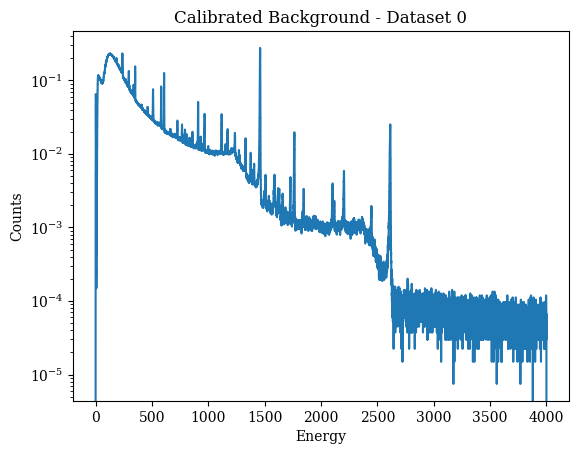

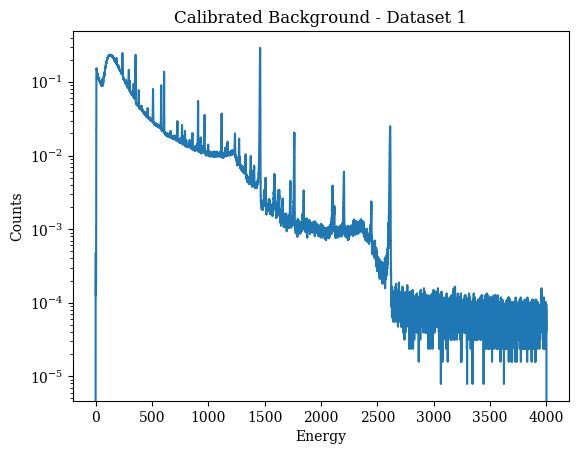

In [15]:
# Plot the histograms
for ds in bkg_cal_spec:
    plt.figure()
    pgh.plot_hist(bkg_cal_spec[ds]/data[ds]['bkg']['rt'], bins=cal_ebins)
    plt.yscale('log')
    plt.title(f"Calibrated Background - Dataset {ds}")
    plt.xlabel("Energy")
    plt.ylabel("Counts")

## Alphas - Uncalibrated

In [16]:
# Make the histograms
alp_uncal_spec = {}
for ds, ds_df in rdb_df.groupby(by="dataset"):
    alp_uncal_spec[ds] = {}
    for run in data[ds]["alp"]:
        spec = None
        for file in data[ds]["alp"][run]:
            if file == 'rt':
                continue
            if spec is None:
                spec = np.histogram(data[ds]["alp"][run][file]['trapEmax_ctc'], bins=ebins)[0]
            else:
                spec += np.histogram(data[ds]["alp"][run][file]['trapEmax_ctc'], bins=ebins)[0]
        alp_uncal_spec[ds][run] = spec


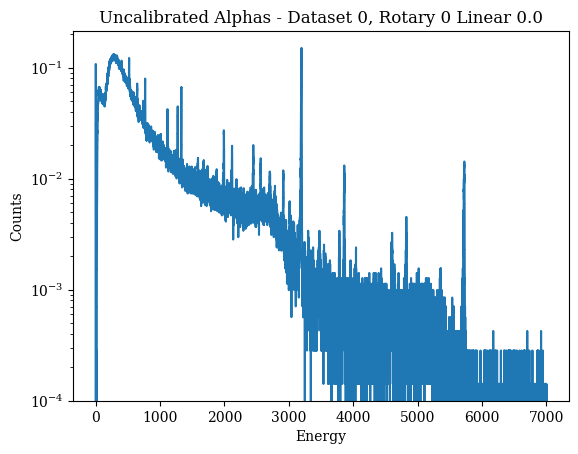

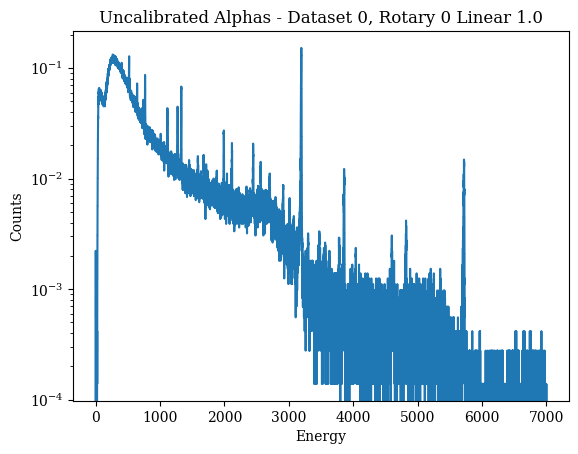

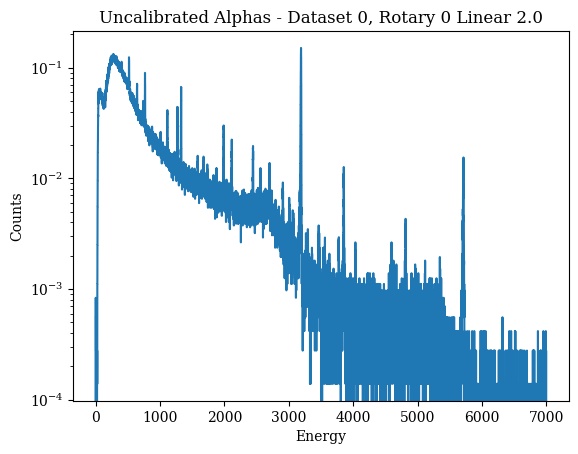

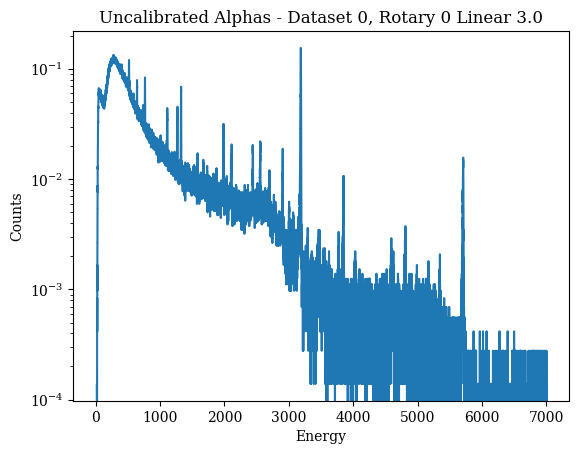

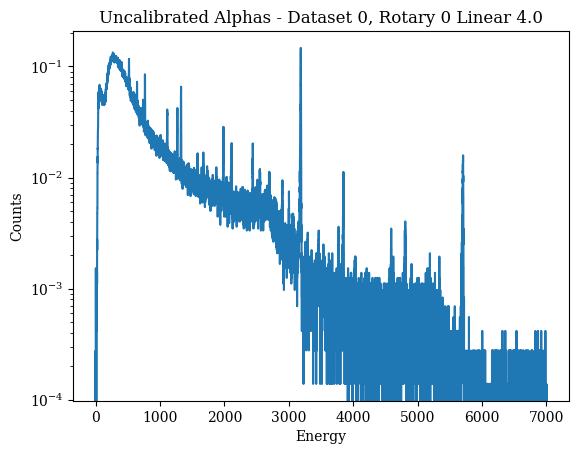

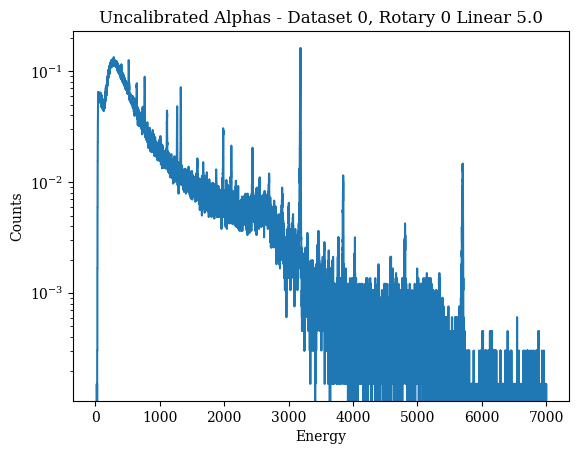

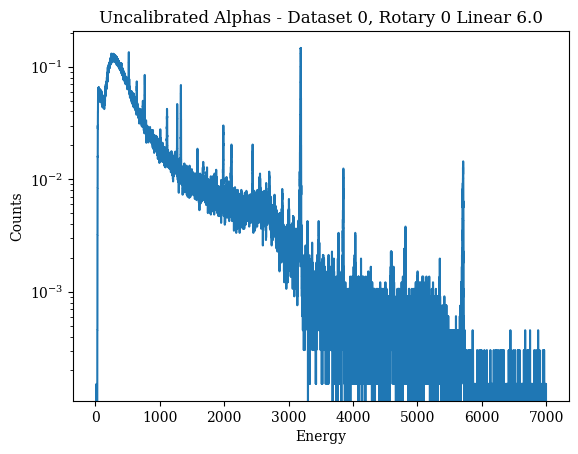

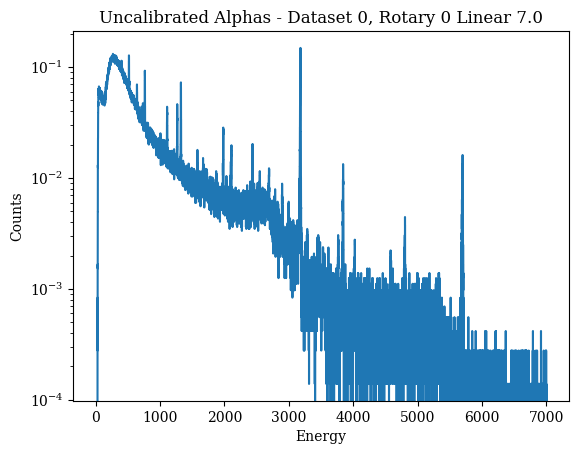

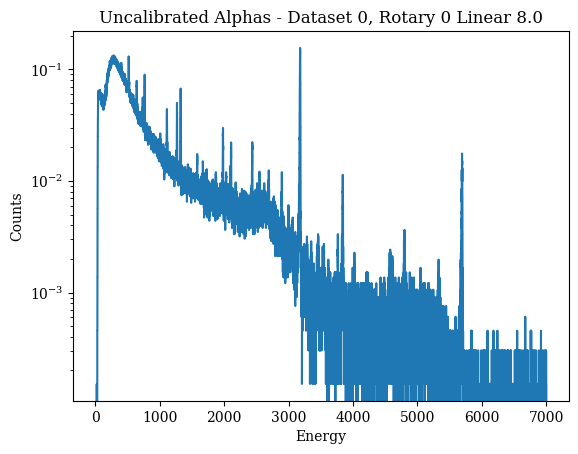

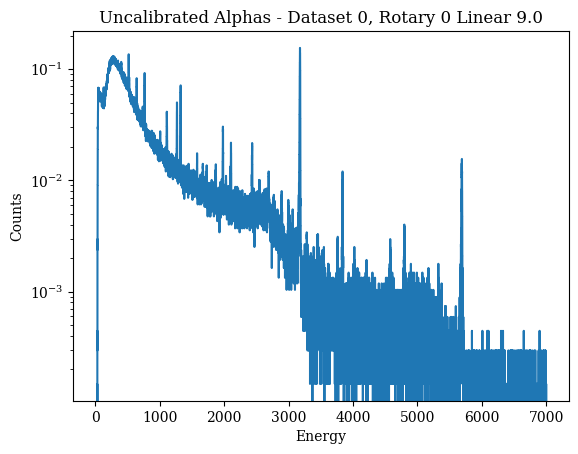

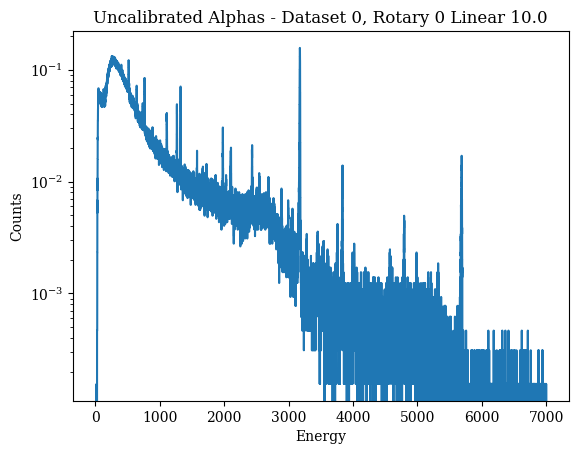

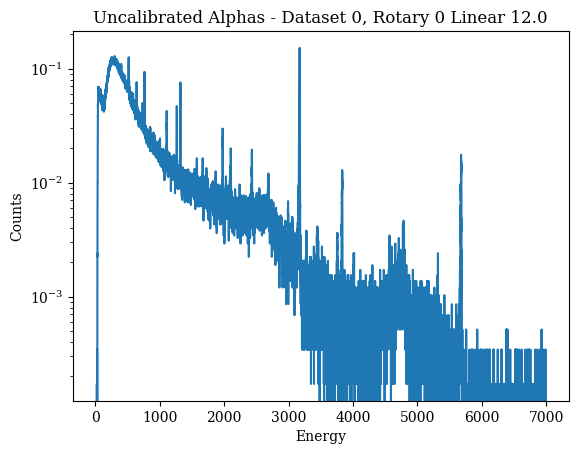

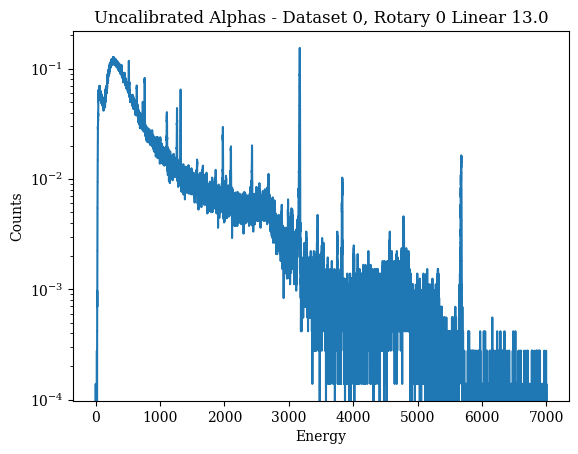

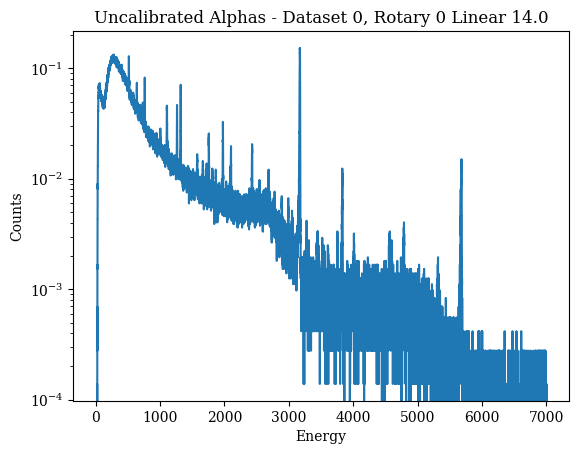

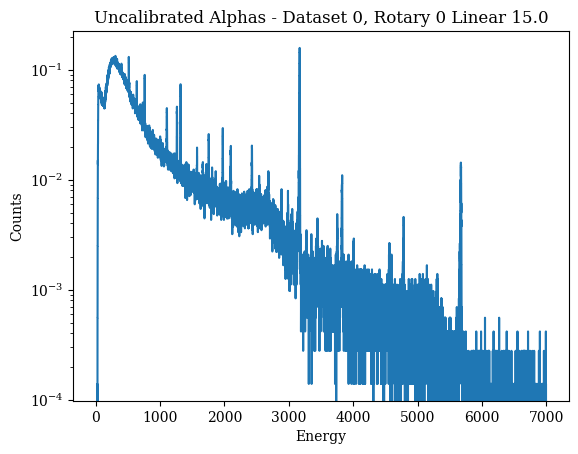

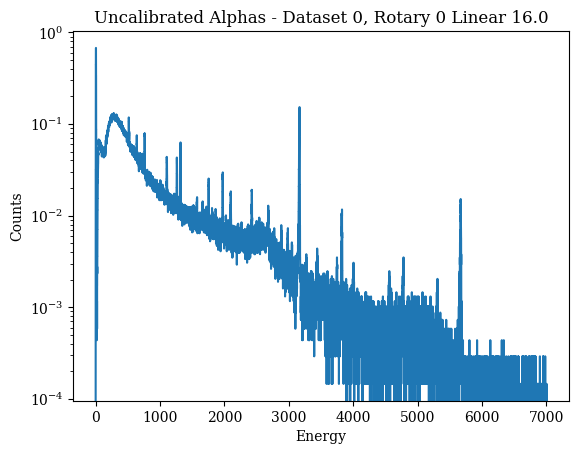

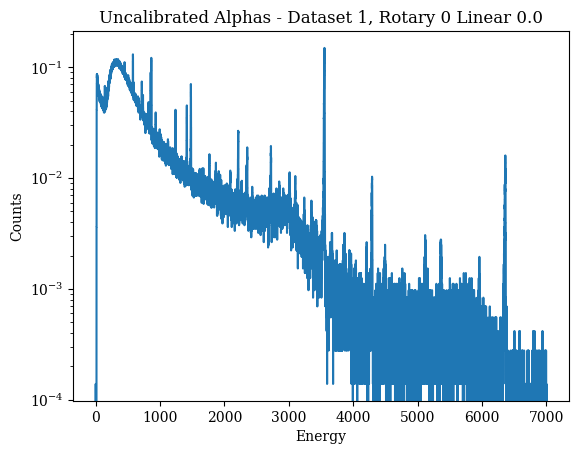

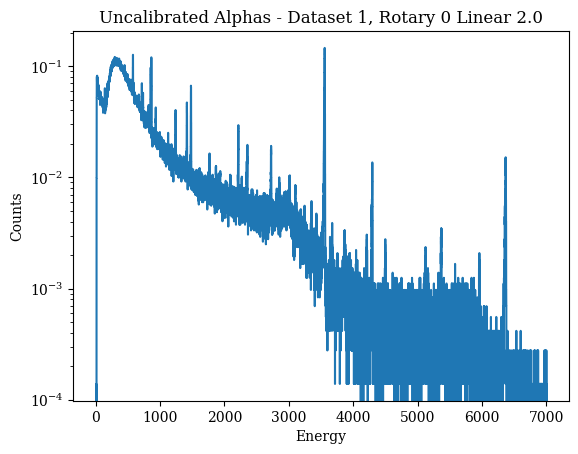

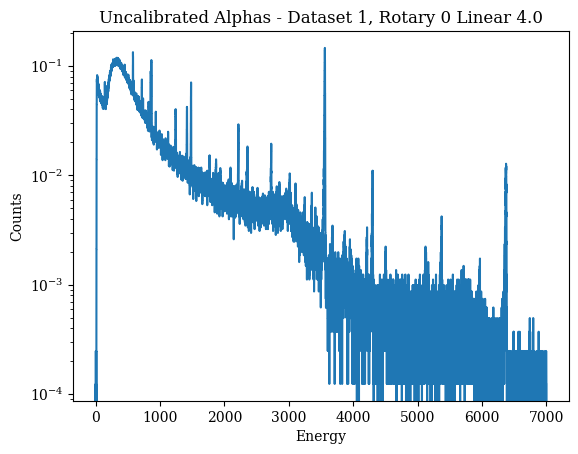

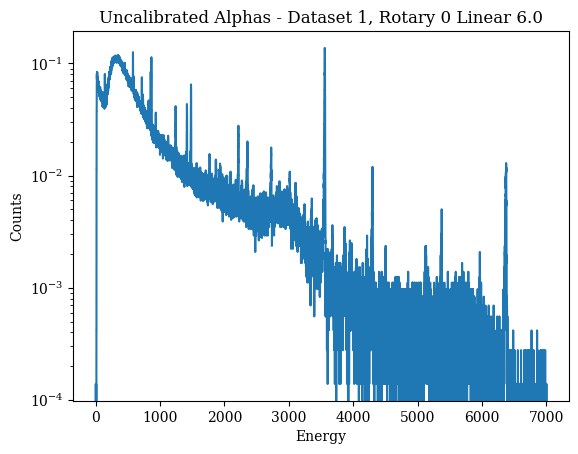

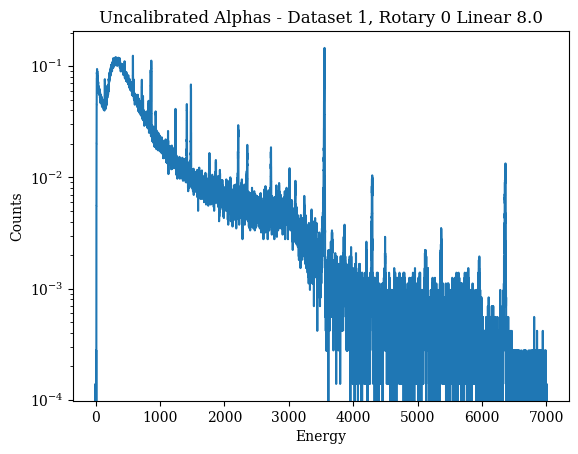

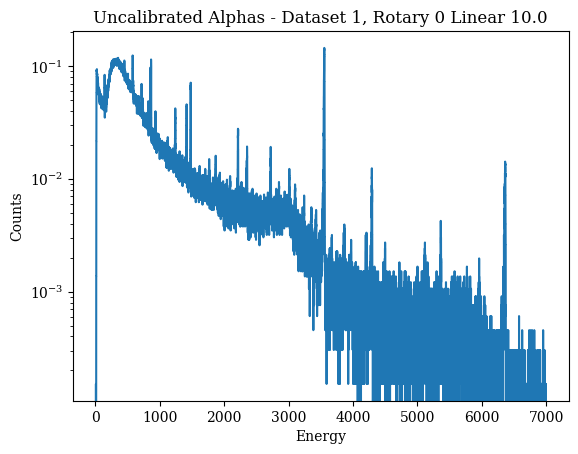

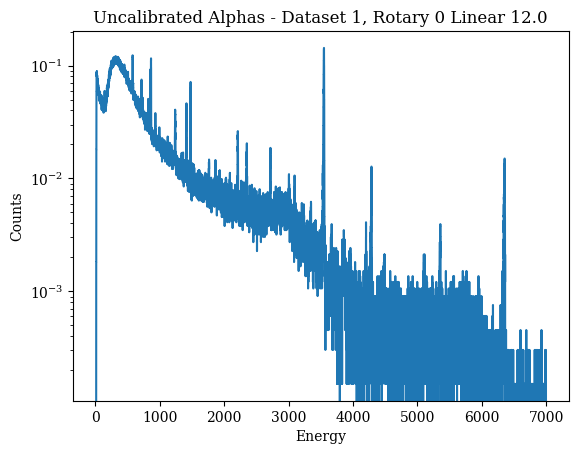

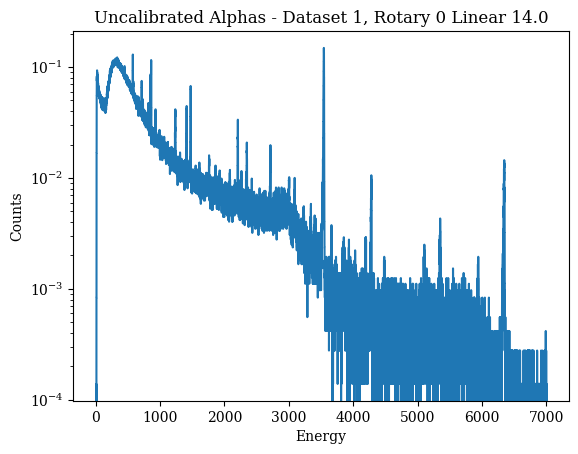

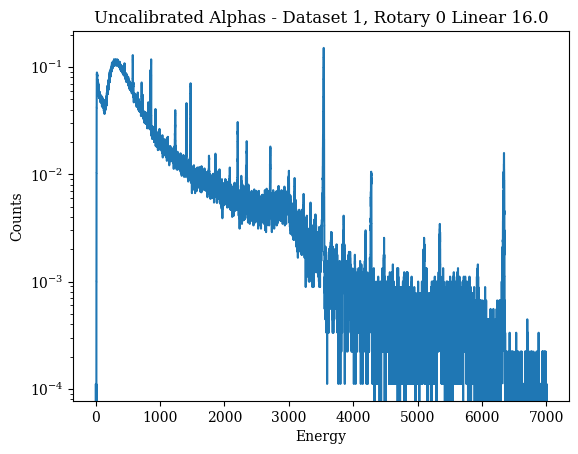

In [17]:
# Plot the histograms
for ds in alp_uncal_spec:
    for run in alp_uncal_spec[ds]:
        lin = rdb_df.loc[run]['linear']
        rot = rdb_df.loc[run]['rotary']
        plt.figure()
        pgh.plot_hist(alp_uncal_spec[ds][run]/data[ds]['alp'][run]['rt'], bins=ebins)
        plt.yscale('log')
        plt.title(f"Uncalibrated Alphas - Dataset {ds}, Rotary {rot} Linear {lin}")
        plt.xlabel("Energy")
        plt.ylabel("Counts")

## Alphas - Calibrated

In [18]:
# Make the histograms
alp_cal_spec = {}
for ds, ds_df in rdb_df.groupby(by="dataset"):
    alp_cal_spec[ds] = {}
    for run in data[ds]["alp"]:
        spec = None
        for file in data[ds]["alp"][run]:
            if file == 'rt':
                continue
            if spec is None:
                spec = np.histogram(data[ds]["alp"][run][file]['cal_trapEmax_ctc'], bins=cal_ebins)[0]
            else:
                spec += np.histogram(data[ds]["alp"][run][file]['cal_trapEmax_ctc'], bins=cal_ebins)[0]
        alp_cal_spec[ds][run] = spec


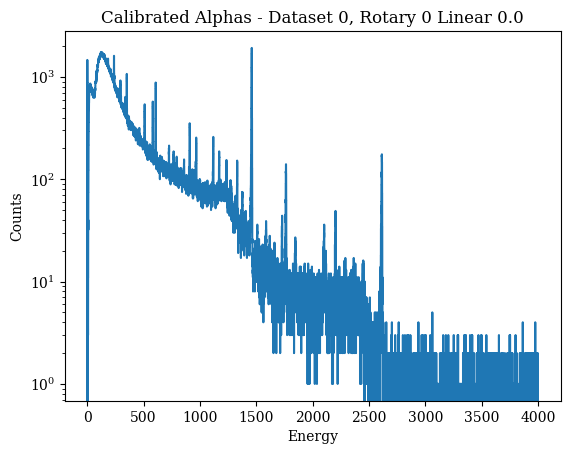

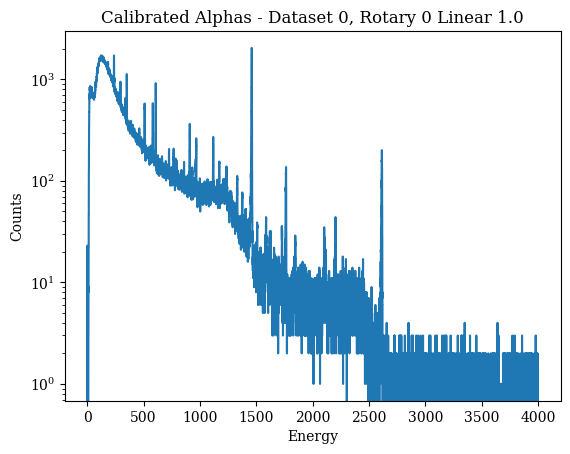

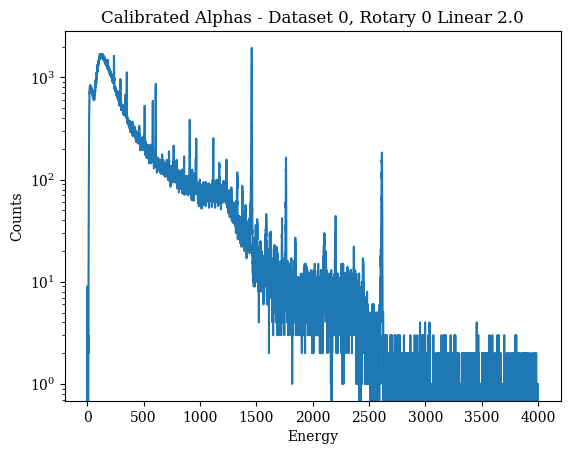

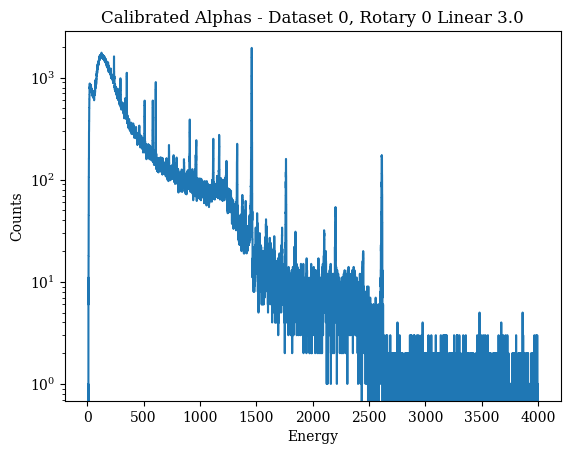

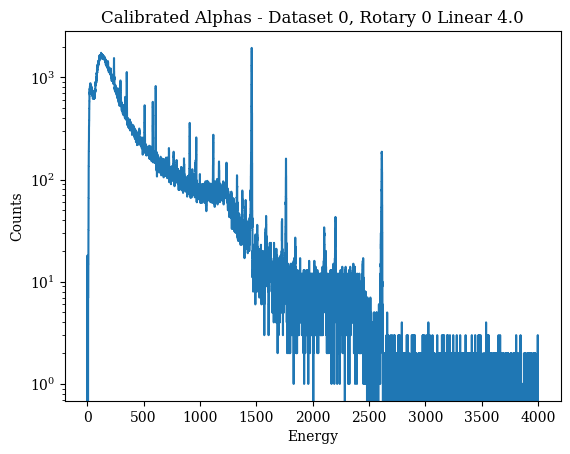

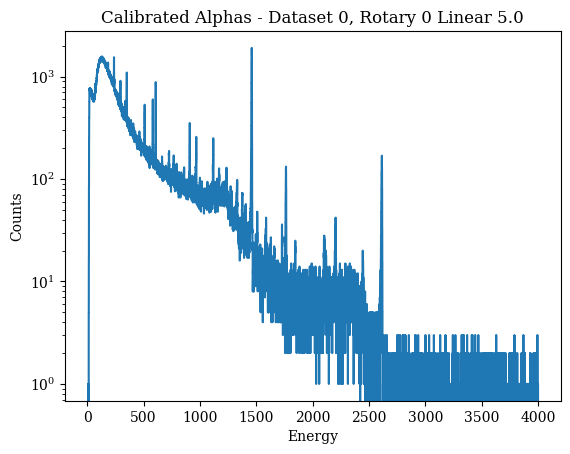

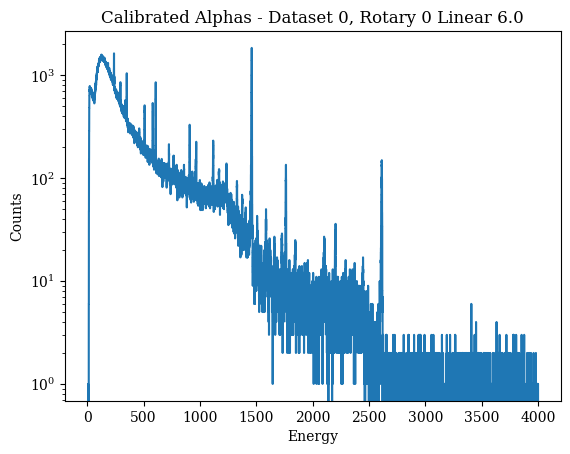

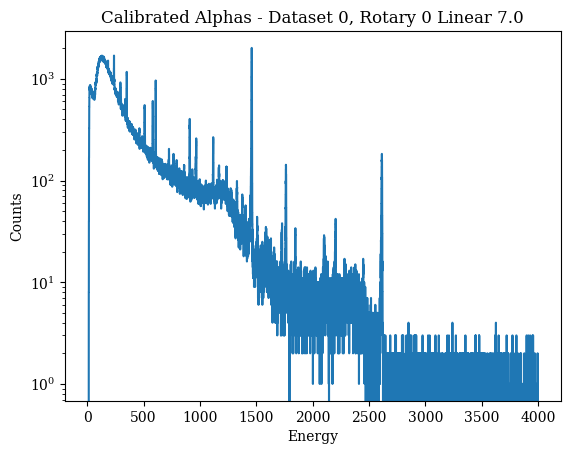

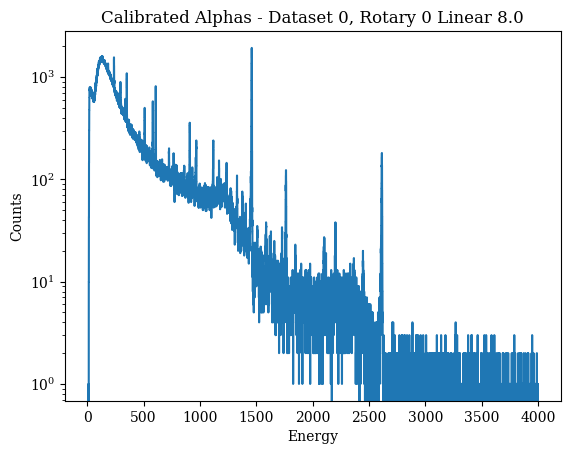

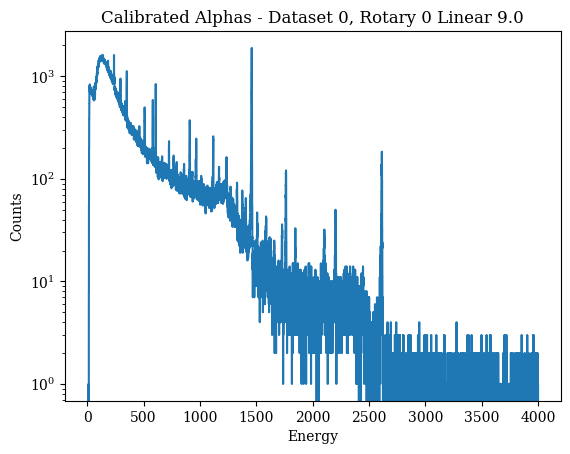

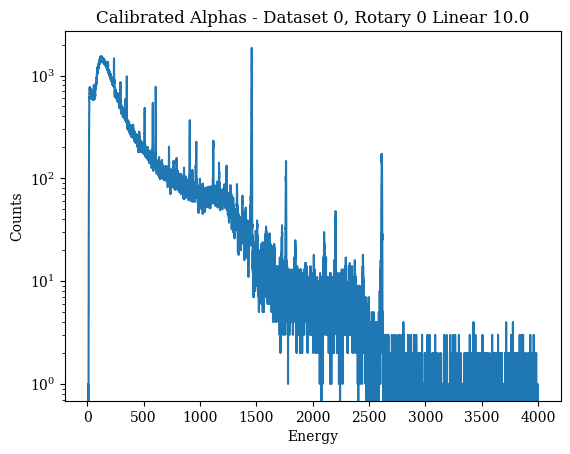

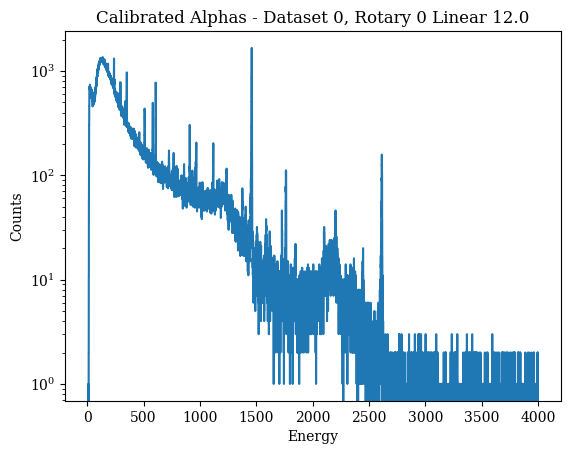

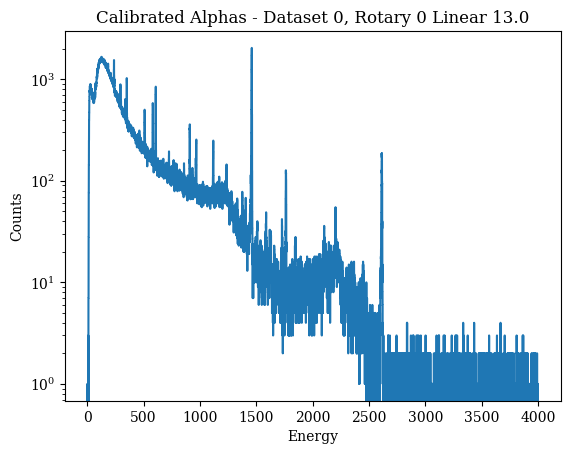

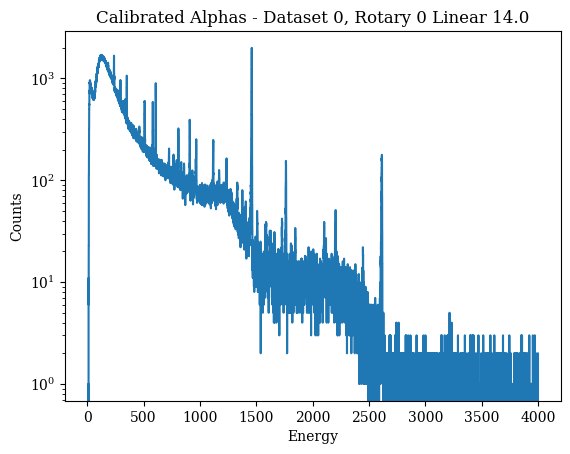

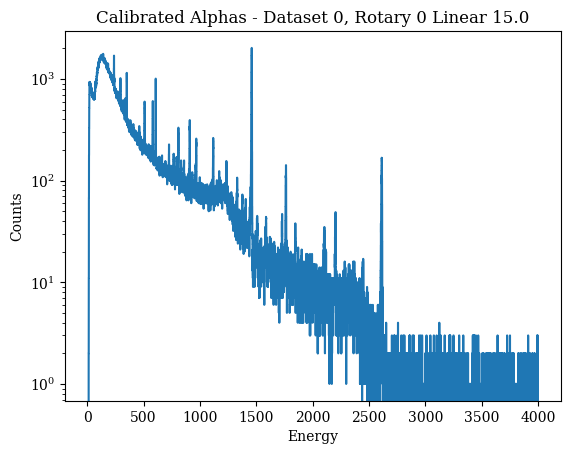

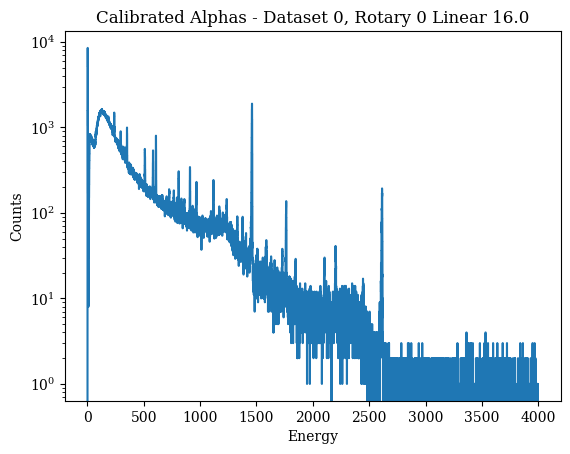

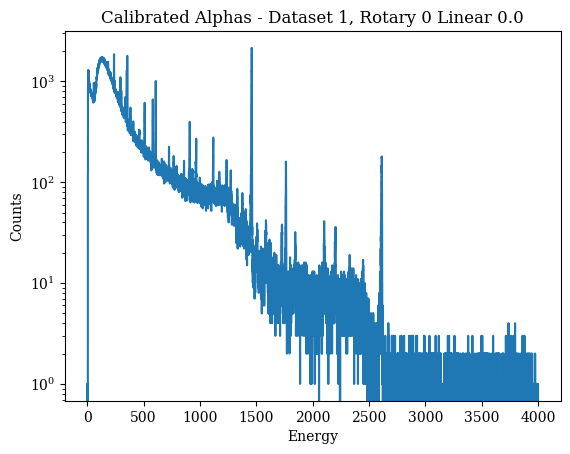

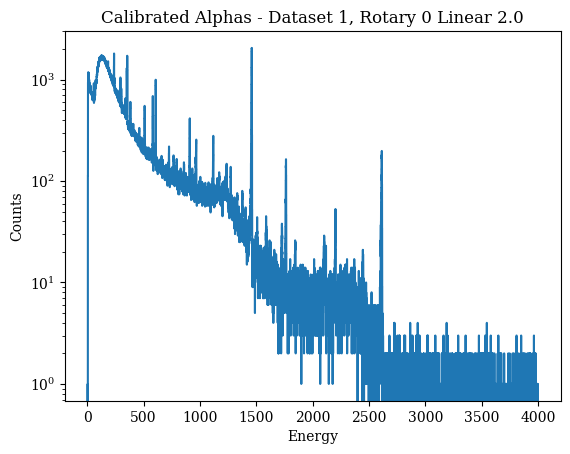

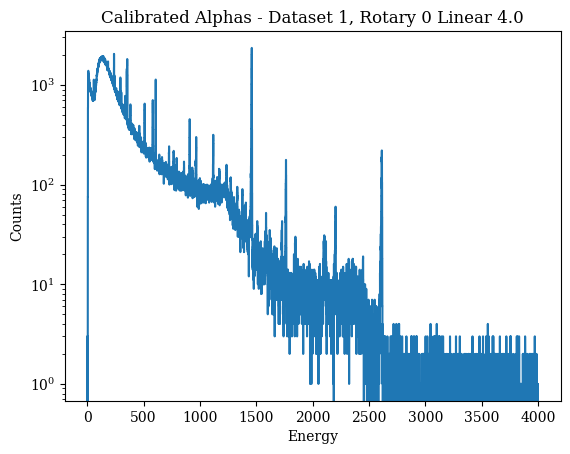

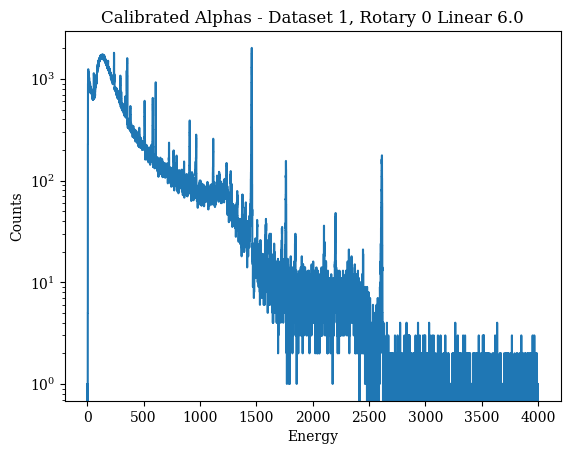

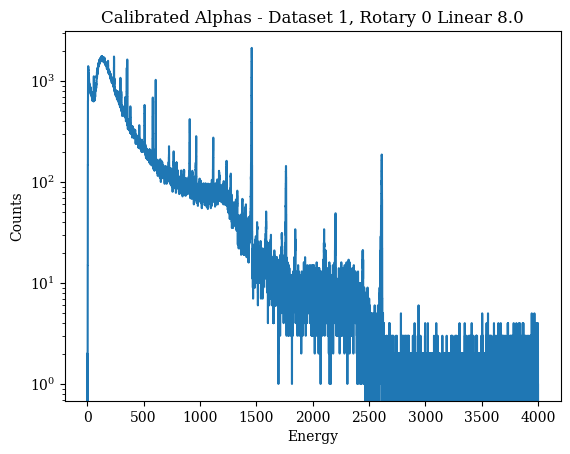

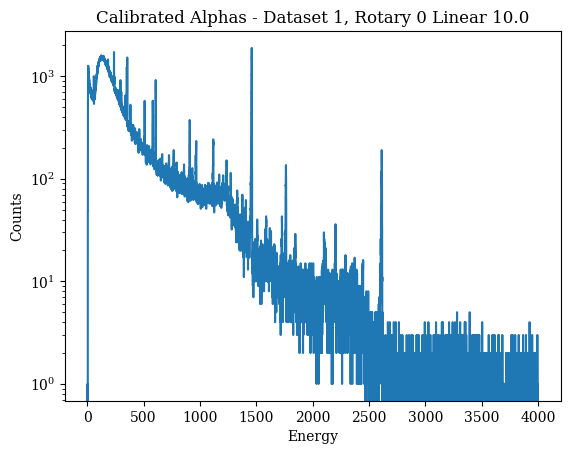

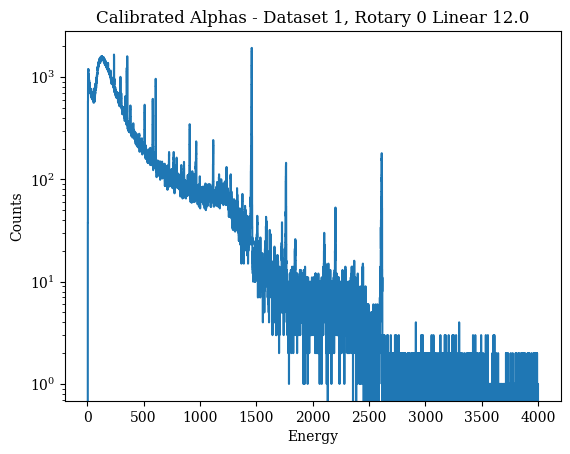

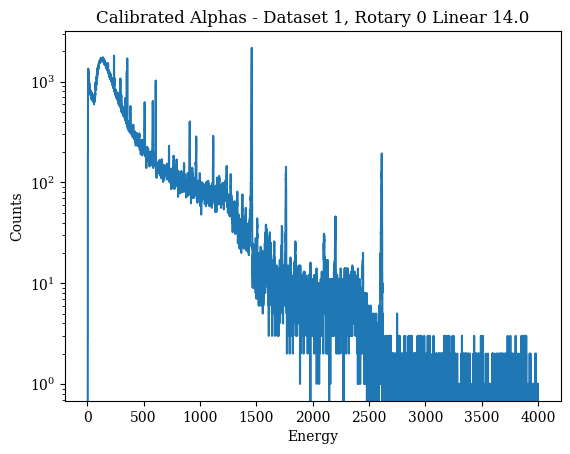

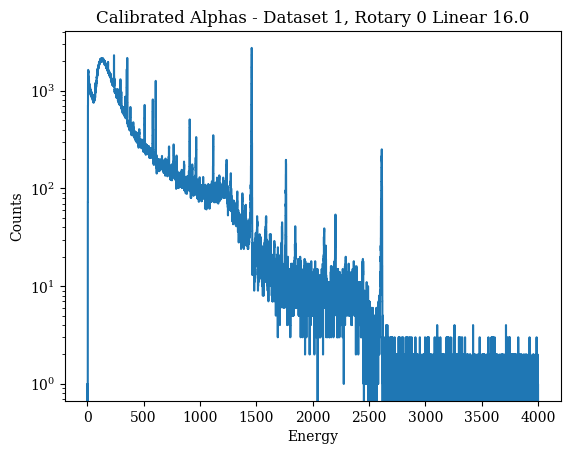

In [19]:
# Plot the histograms
for ds in alp_cal_spec:
    for run in alp_cal_spec[ds]:
        lin = rdb_df.loc[run]['linear']
        rot = rdb_df.loc[run]['rotary']
        plt.figure()
        pgh.plot_hist(alp_cal_spec[ds][run], bins=cal_ebins)
        plt.yscale('log')
        plt.title(f"Calibrated Alphas - Dataset {ds}, Rotary {rot} Linear {lin}")
        plt.xlabel("Energy")
        plt.ylabel("Counts")

# Detector Characterization

## Gain

**Pre-Reqs**: "Energy Histograms: Backgrounds - Uncalibrated"

**Human Input**: `uncal_guesses` locations of uncalibrated peaks

This will compare the uncalibrated background spectra of multiple datasets and find the peaks relative to each other.

In [26]:
uncal_guesses = {
    0: [1100, 1320, 3200, 3850,5700],
    1: [1250, 1500, 3550, 4300, 6375]
}

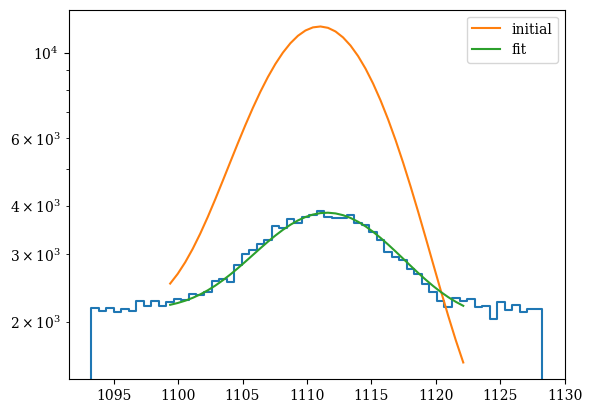

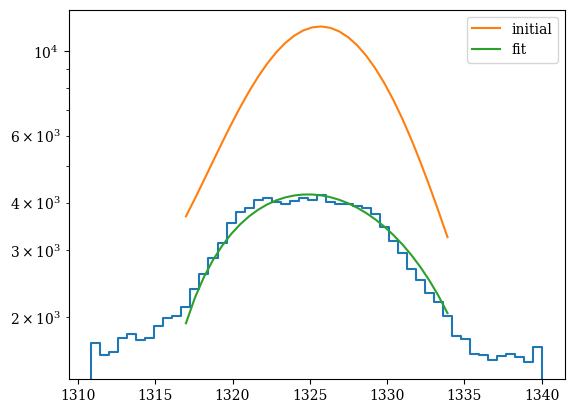

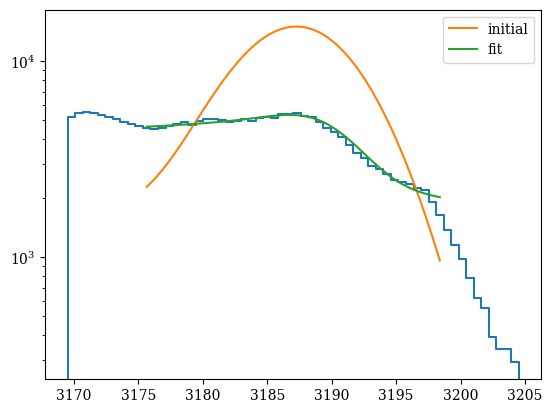

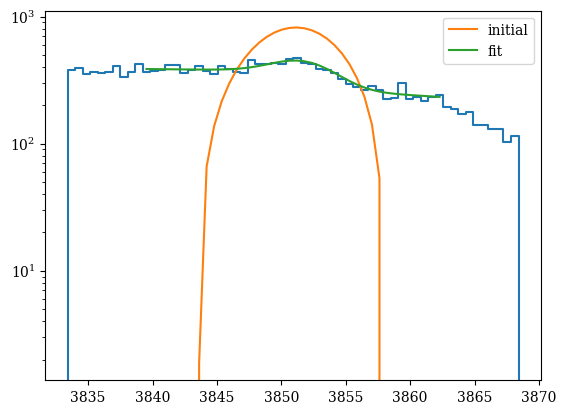

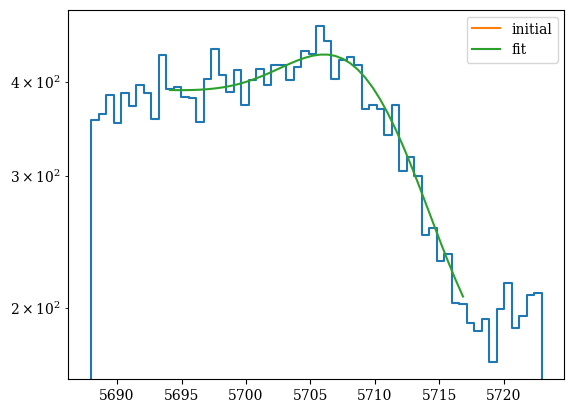

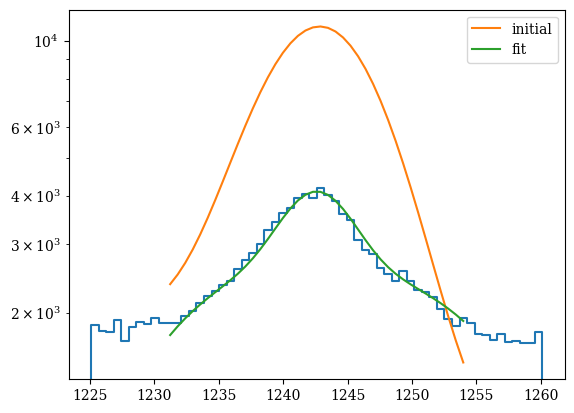

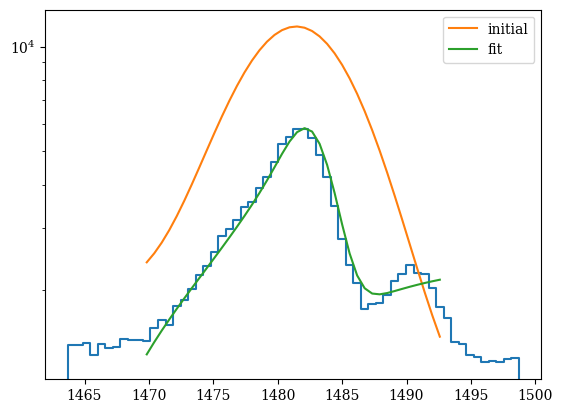

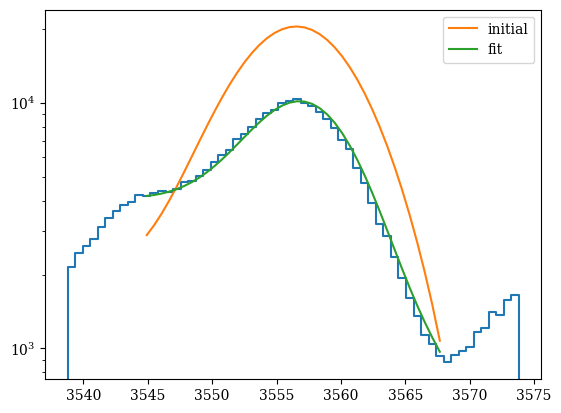

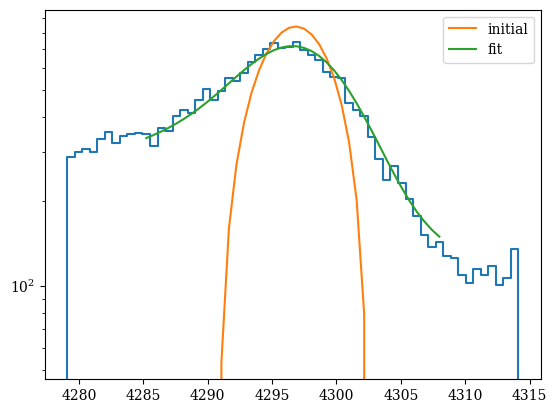

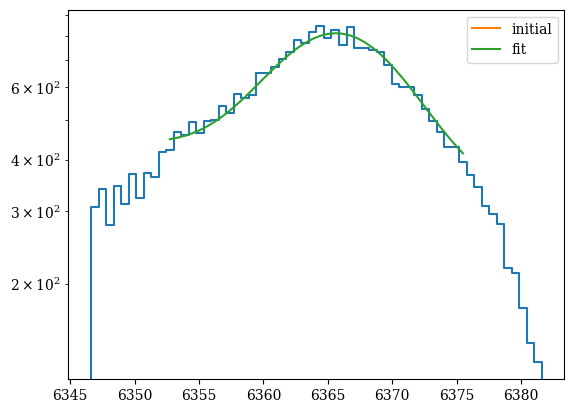

In [27]:
uncal_peak_locs = {}
for ds in uncal_guesses:
    uncal_peak_locs[ds] = []
    for i in range(len(uncal_guesses[ds])):
        popt, pcov, _ = fit_peak(bkg_uncal_spec[ds], ebins, uncal_guesses[ds][i], plot=True, )
        uncal_peak_locs[ds].append(popt[1])

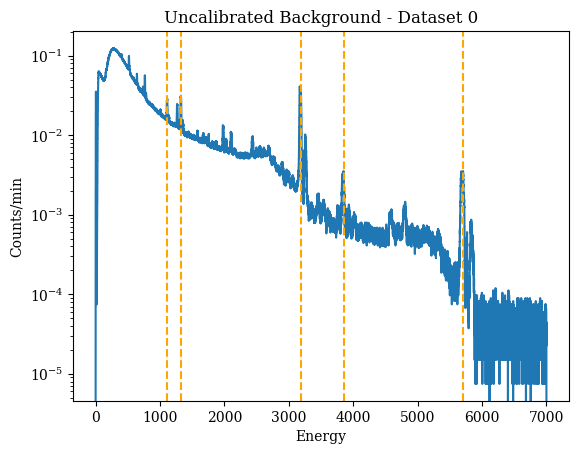

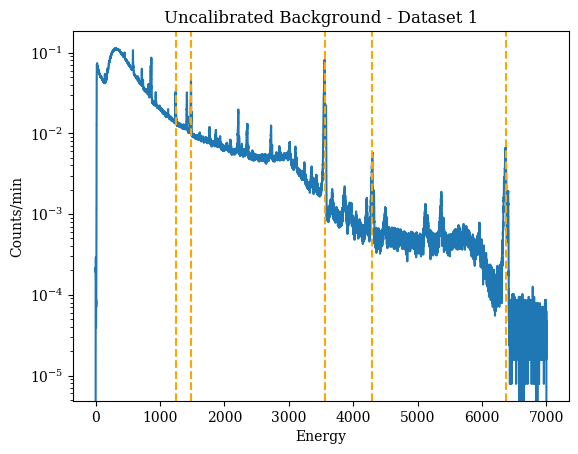

In [28]:
# Plot the histograms
for ds in bkg_uncal_spec:
    plt.figure()
    pgh.plot_hist(bkg_uncal_spec[ds]/data[ds]['bkg']['rt'], bins=ebins)
    plt.yscale('log')
    plt.title(f"Uncalibrated Background - Dataset {ds}")
    plt.xlabel("Energy")
    plt.ylabel("Counts/min")
    for p in uncal_peak_locs[ds]:
        plt.axvline(p, linestyle='dashed', color='orange')

In [29]:
base = list(uncal_peak_locs.keys())[0]

for ds in uncal_peak_locs:
    print(f"Peak location ratio, dataset {ds} : dataset {base}  ", np.average(np.array(uncal_peak_locs[ds]) / np.array(uncal_peak_locs[base]) ))

Peak location ratio, dataset 0 : dataset 0   1.0
Peak location ratio, dataset 1 : dataset 0   1.117361093454155


## Linearity and Resolution

**Pre-Reqs**: "Energy Histograms: Backgrounds - Calibrated"

**Human Input**: None

This fits a bunch of calibrated, expected peaks to compare to where we expect them to be. 

In [30]:
known_peaks = {
    'beta+': 511, 
    '228Ac': 911.2, 
    '40K': 1460.8, 
    '214Bi': 1764.5, 
    '208Tl': 2614.5
}

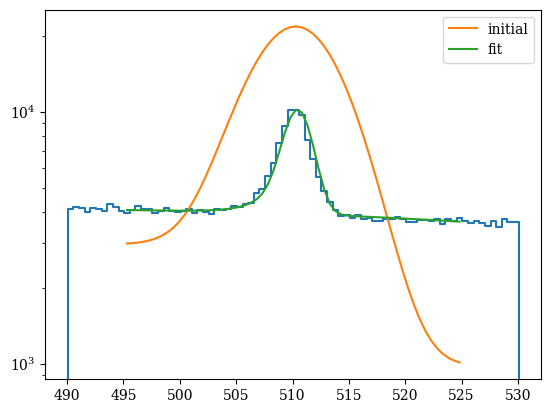

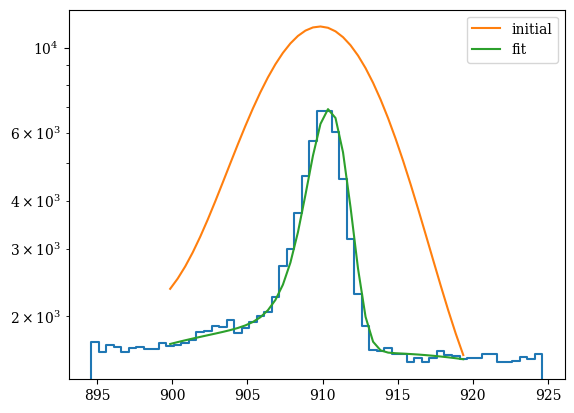

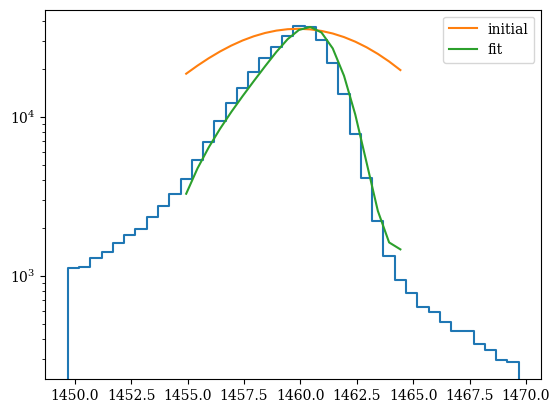

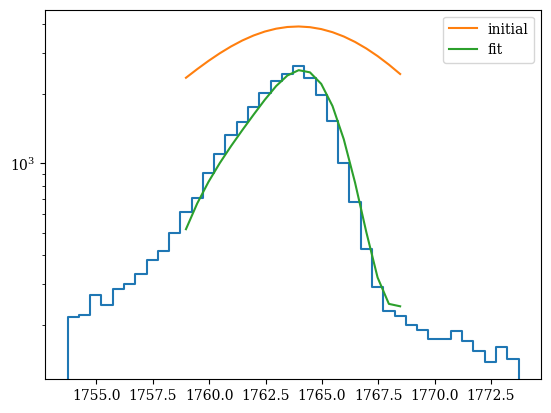

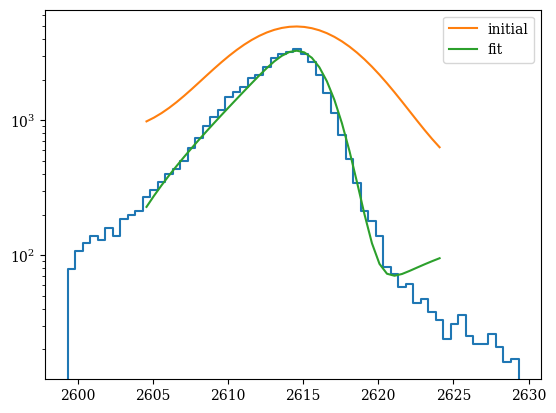

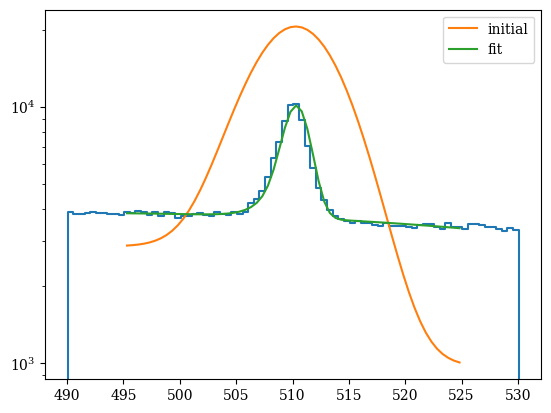

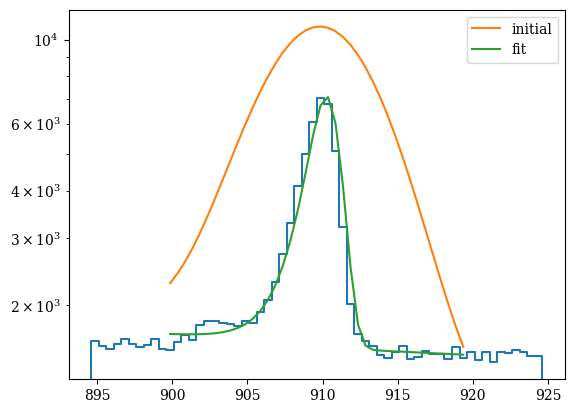

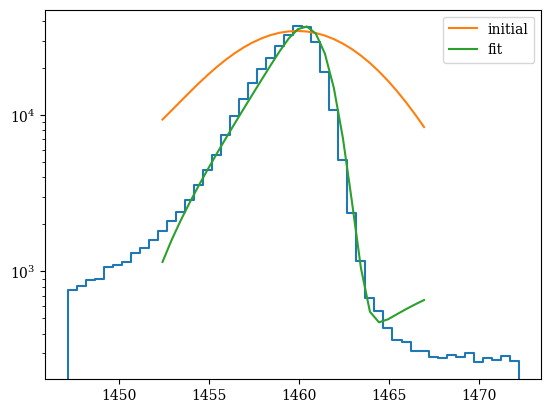

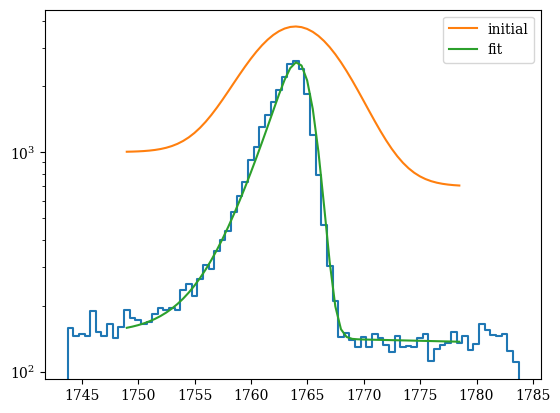

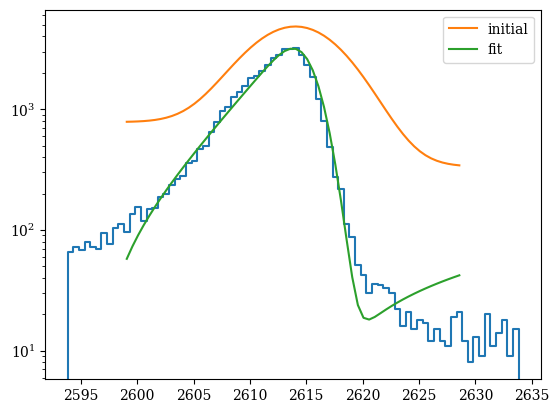

In [31]:
cal_peak_locs = {}
cal_peak_widths = {}
for ds in bkg_cal_spec:
    cal_peak_locs[ds] = []
    cal_peak_widths[ds] = []
    for peak in known_peaks.values():
        popt, pcov, _ = fit_peak(bkg_cal_spec[ds], cal_ebins, peak, plot=True)
        cal_peak_locs[ds].append(popt[1])
        cal_peak_widths[ds].append(popt[2])

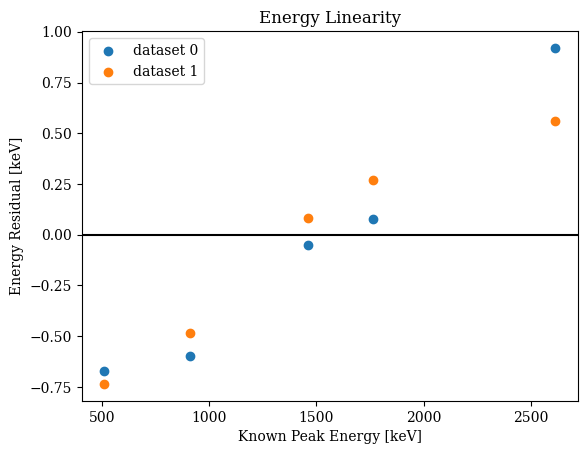

In [32]:
known_peak_vals = np.array(list(known_peaks.values()))
plt.figure()
for ds in cal_peak_locs:
    plt.scatter(known_peak_vals, np.array(cal_peak_locs[ds]) - known_peak_vals, label=f"dataset {ds}")
plt.legend()
plt.xlabel("Known Peak Energy [keV]")
plt.ylabel("Energy Residual [keV]")
plt.title("Energy Linearity")
plt.axhline(0, color='black')


Text(0.5, 1.0, 'Energy Resolution')

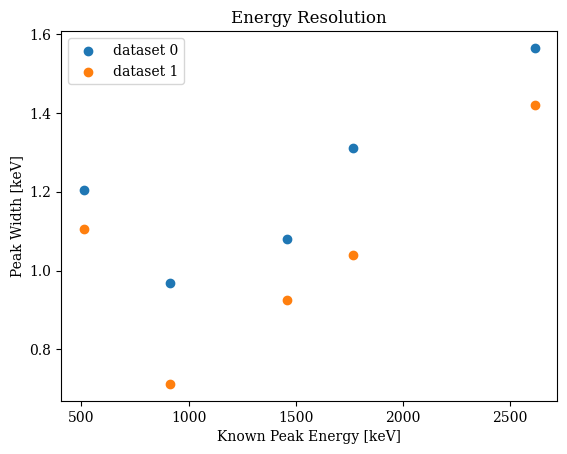

In [33]:
plt.figure()
for ds in cal_peak_locs:
    plt.scatter(known_peak_vals, np.array(cal_peak_widths[ds]), label=f"dataset {ds}")
plt.legend()
plt.xlabel("Known Peak Energy [keV]")
plt.ylabel("Peak Width [keV]")
plt.title("Energy Resolution")


Text(0.5, 1.0, 'Energy Resolution')

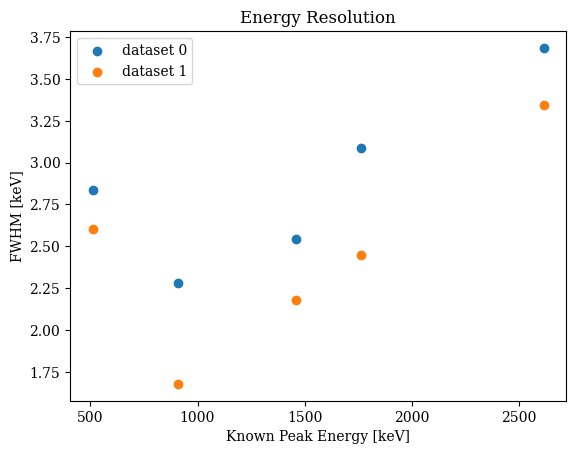

In [34]:
plt.figure()
for ds in cal_peak_locs:
    plt.scatter(known_peak_vals, np.array(cal_peak_widths[ds])*2.355, label=f"dataset {ds}")
plt.legend()
plt.xlabel("Known Peak Energy [keV]")
plt.ylabel("FWHM [keV]")
plt.title("Energy Resolution")


# Parameter vs. Energy Plots

**Pre-Reqs**: None

**Human Input**: None

This will compare the uncalibrated background spectra of multiple datasets and find the peaks relative to each other.
Plot 2D background subtracted 'Parameter vs. Energy' plots for each dataset. 

In [20]:
def make_parE_hist(par):
    """
    par: str, name of parameter in Table
    """
    par_energy_hist = {}
    for ds, ds_df in rdb_df.groupby(by="dataset"):
        par_energy_hist[ds] = {}
        
        # Make the background histogram
        hist = None
        for file in data[ds]["bkg"]:
            if file == 'rt':
                continue

            if par == "tp_20":
                par_vals = data[ds]["bkg"][file][par].nda - data[ds]["bkg"][file]["tp_0"].nda
            elif par == "tp_90":
                par_vals = data[ds]["bkg"][file][par].nda - data[ds]["bkg"][file]["tp_10"].nda
            else:
                par_vals = data[ds]["bkg"][file][par]

            if hist is None:
                hist = np.histogram2d(data[ds]["bkg"][file]['cal_trapEmax_ctc'], par_vals, bins=(cal_ebins, bins[par]))[0]
            else:
                hist += np.histogram2d(data[ds]["bkg"][file]['cal_trapEmax_ctc'], par_vals, bins=(cal_ebins, bins[par]))[0]
            hist /= data[ds]["bkg"]["rt"]
            par_energy_hist[ds]["bkg"] = hist
        
        # Make each alpha histogram and perform background subtraction
        for run in data[ds]["alp"]:
            hist = None
            for file in data[ds]["alp"][run]:
                if file == 'rt':
                    continue
                
                if par == "tp_20":
                    par_vals = data[ds]["alp"][run][file][par].nda - data[ds]["alp"][run][file]["tp_0"].nda
                elif par == "tp_90":
                    par_vals = data[ds]["alp"][run][file][par].nda - data[ds]["alp"][run][file]["tp_10"].nda
                else:
                    par_vals = data[ds]["alp"][run][file][par]
                
                if hist is None:
                    hist = np.histogram2d(data[ds]["alp"][run][file]['cal_trapEmax_ctc'], par_vals, bins=(cal_ebins, bins[par]))[0]
                else:
                    hist += np.histogram2d(data[ds]["alp"][run][file]['cal_trapEmax_ctc'], par_vals, bins=(cal_ebins, bins[par]))[0]
            hist /= data[ds]["alp"][run]["rt"]
            hist -= par_energy_hist[ds]["bkg"]
            par_energy_hist[ds][run] = hist
            
    return par_energy_hist

    
def plot_parE(par, par_energy_hist, save=False, runs=None, cuts=None):
    """
    par: str, name of parameter in Table
    save: save figures in plots folder
    """
    cmap = copy.copy(mpl.colormaps['coolwarm'])
    
    for ds in par_energy_hist:
        for run in par_energy_hist[ds]: 
            if run == "bkg":
                continue
                
            if runs is not None:
                if run not in runs:
                    continue
            rot = rdb_df.loc[run]['rotary']
            lin = rdb_df.loc[run]['linear']
            src = rdb_df.loc[run]['source']
            
            plt.figure()
            plt.title(f"{par} vs Energy, Dataset {ds} Rotary {rot}, Linear {lin}, Source {src}")
            plt.xlabel("Energy [keV]")
            plt.ylabel(f"{par}")
            
            # zero_percentile = percentileofscore(np.ndarray.flatten(par_energy_hist[ds][run]), 0)
            lim = -1 * np.min(par_energy_hist[ds][run])/10
            plt.pcolor(cal_ebins, bins[par], par_energy_hist[ds][run].T, 
                   cmap=cmap, norm=colors.SymLogNorm(linthresh=0.00001, vmin=-1*lim, vmax=lim))
            plt.colorbar()
            
            if cuts is not None:
                for cut in cuts:
                    plt.axhline(cut, color='green')
            
            plt.show()
            plt.close()
            
            if save:
                plt.savefig(f"plots/{par}_rot{rot}_linear{lin}_source{src}.png")

## DCR

In [21]:
dcr_energy_hist = make_parE_hist("dcr")

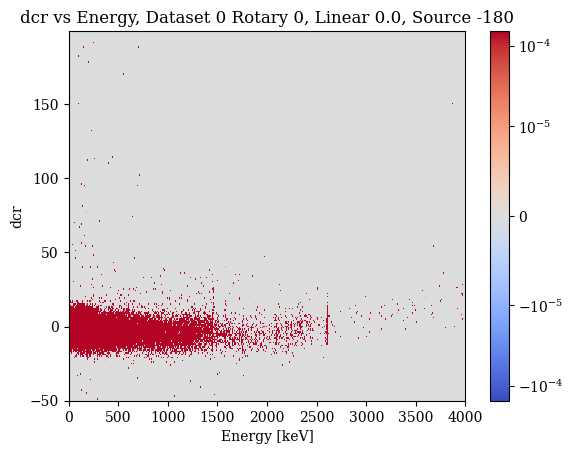

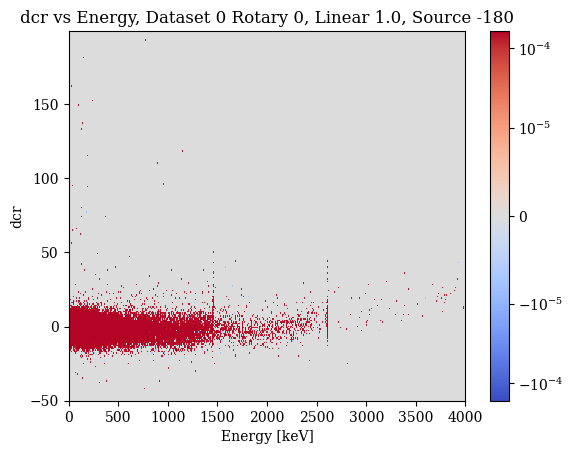

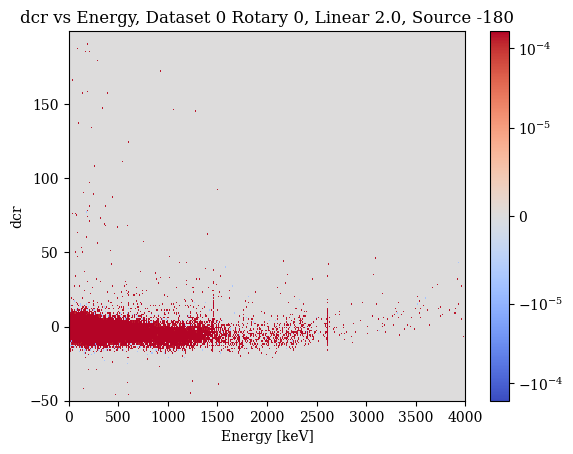

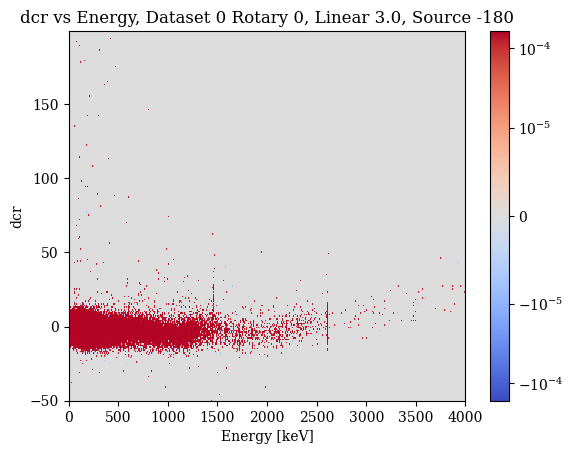

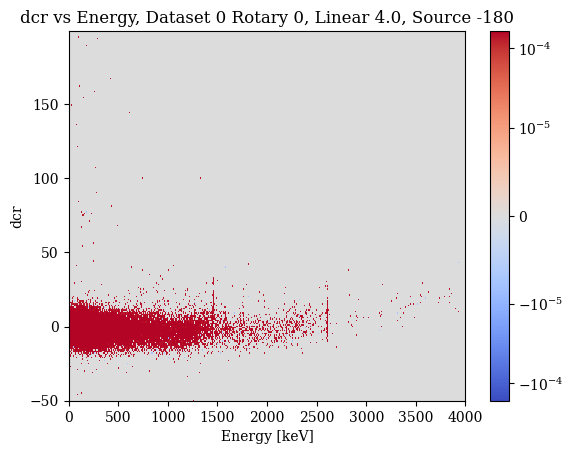

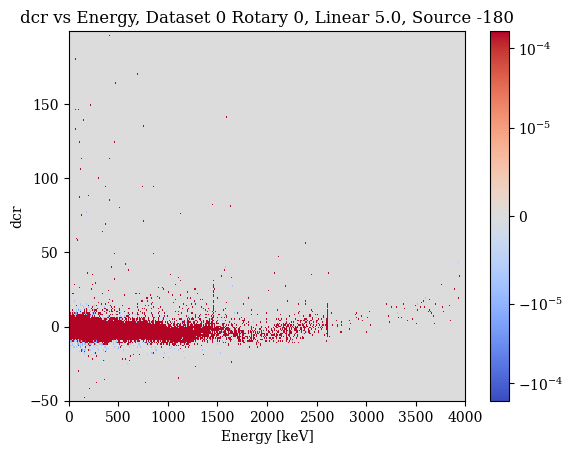

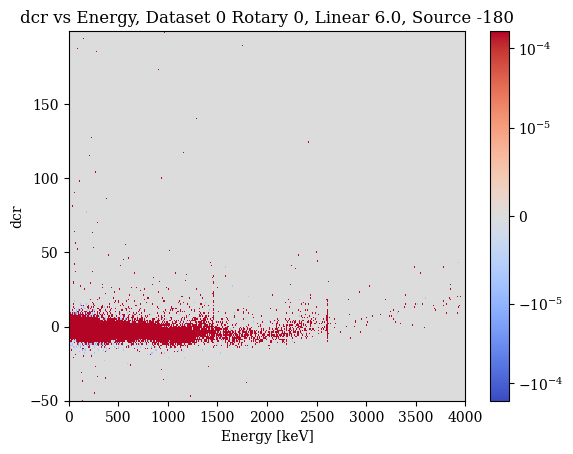

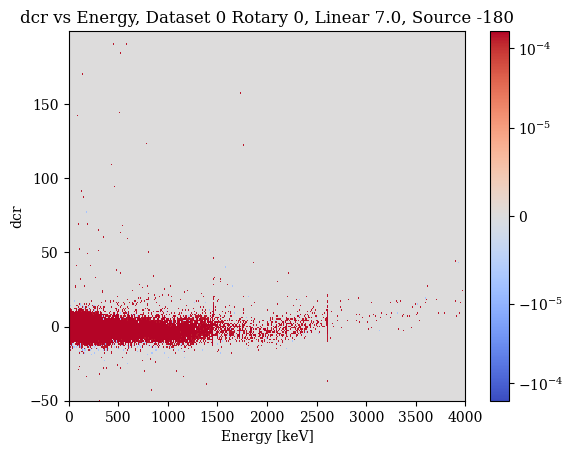

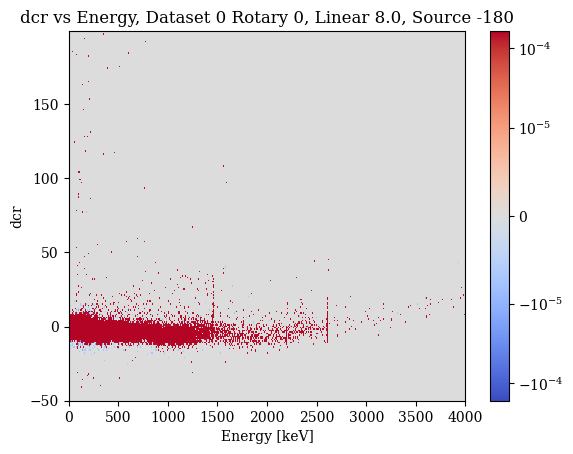

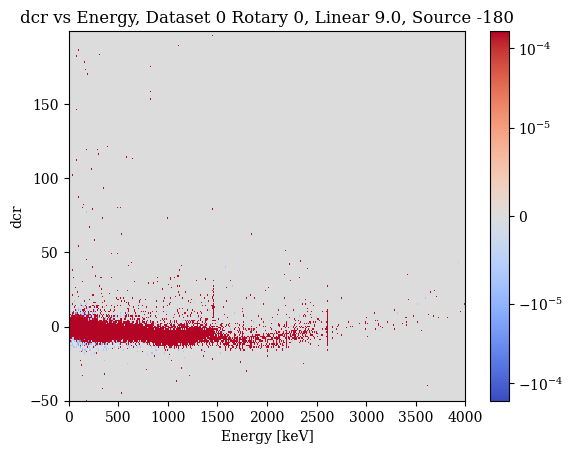

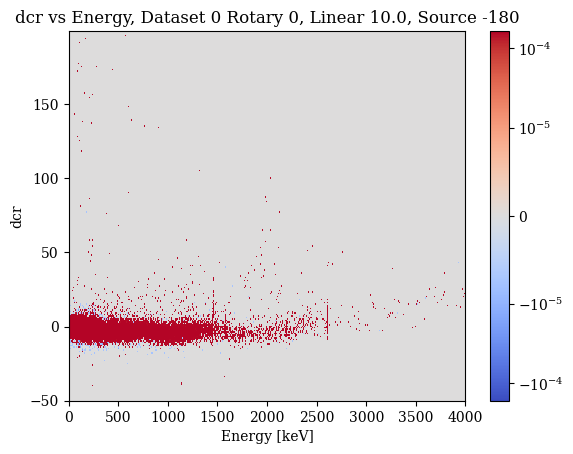

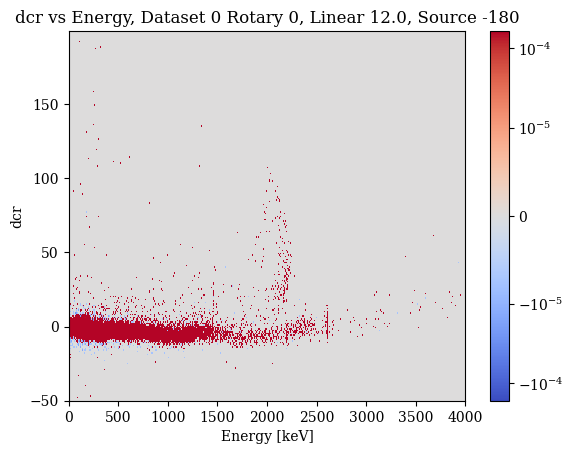

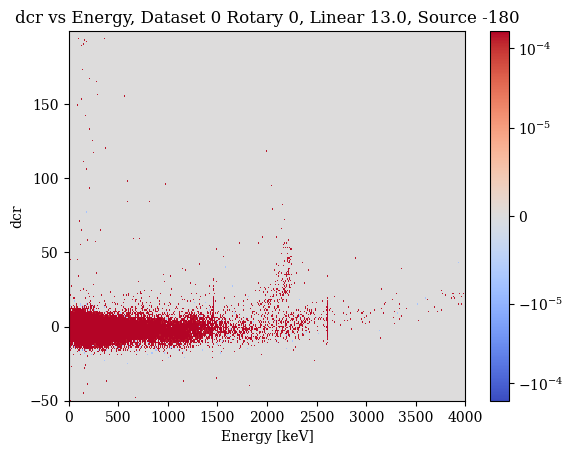

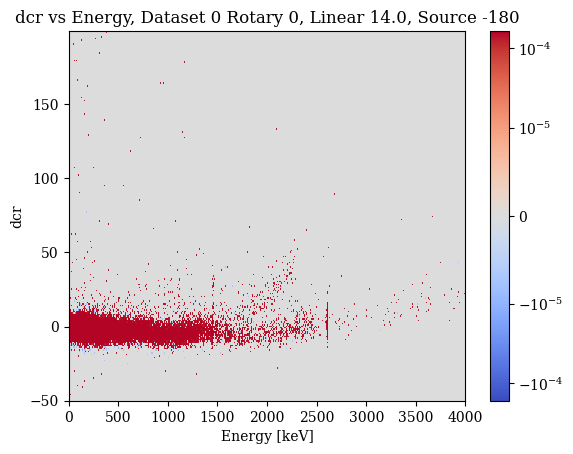

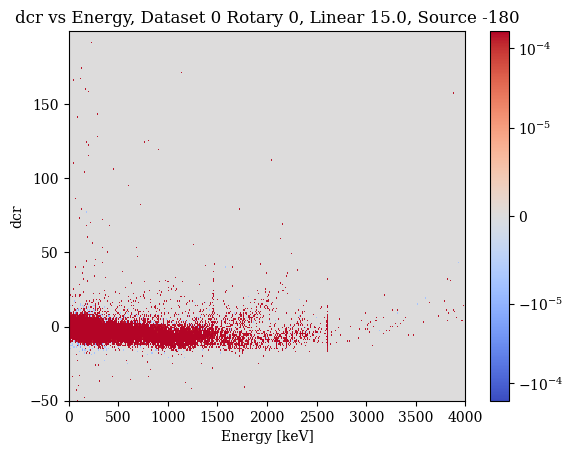

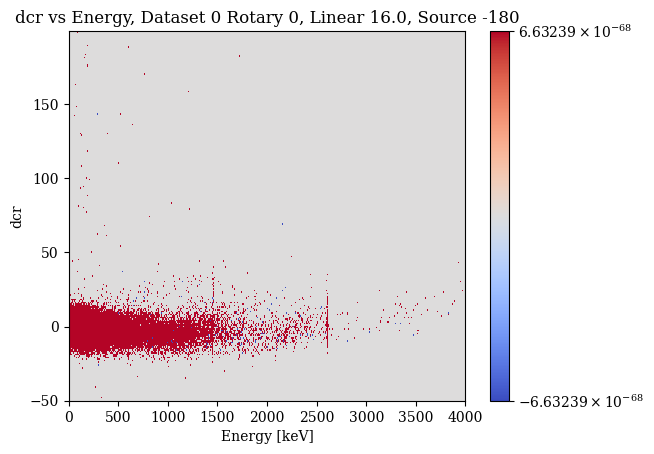

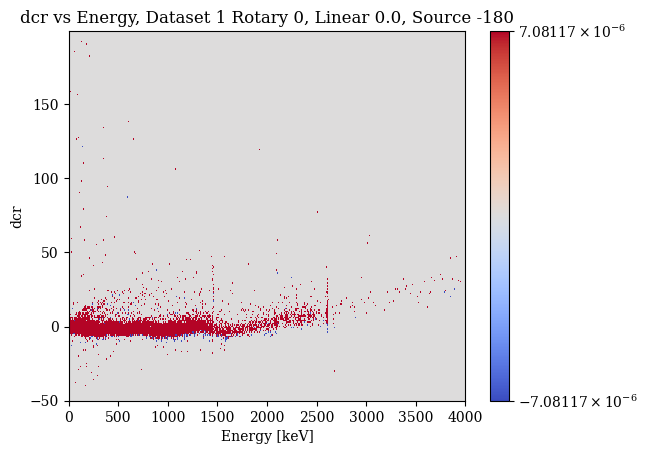

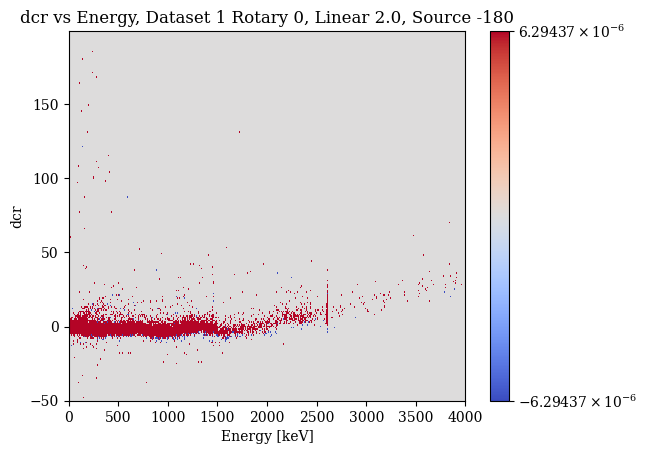

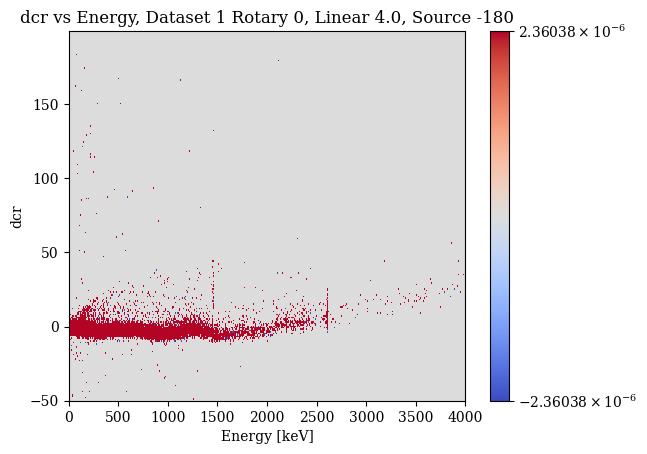

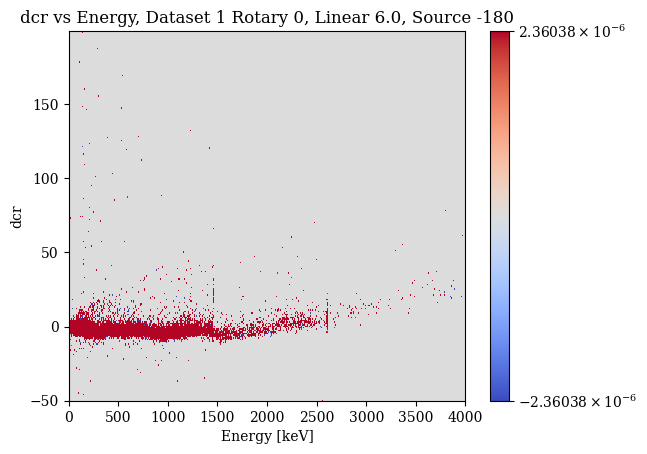

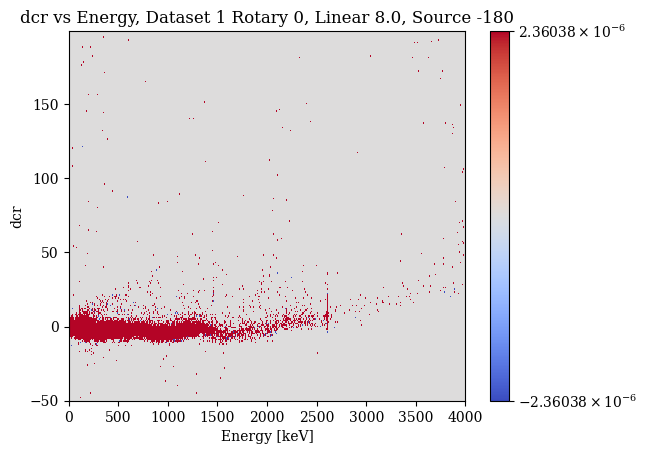

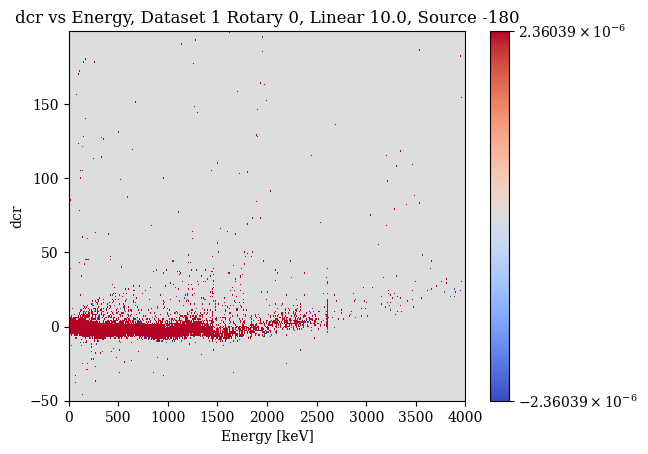

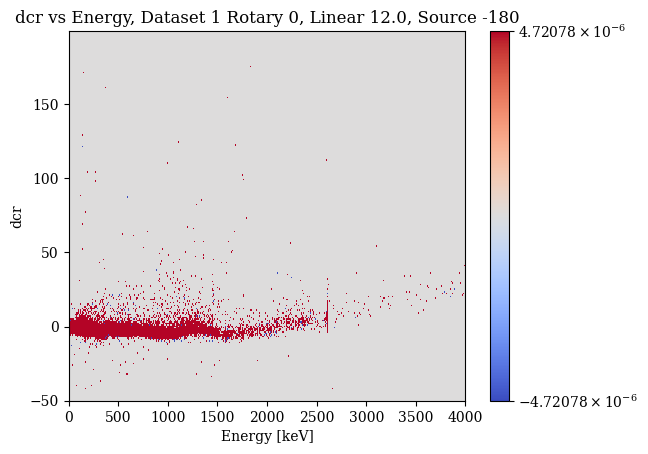

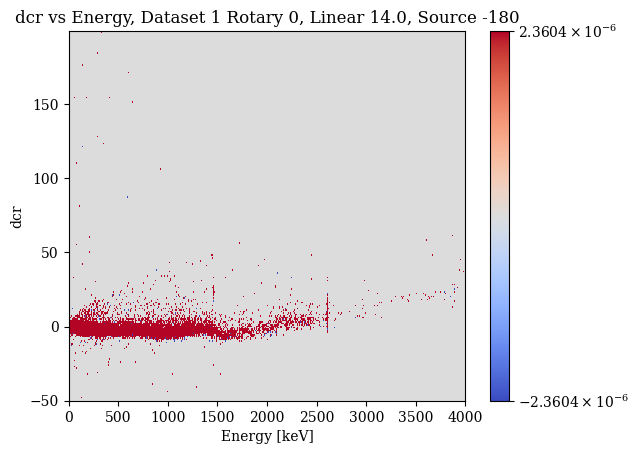

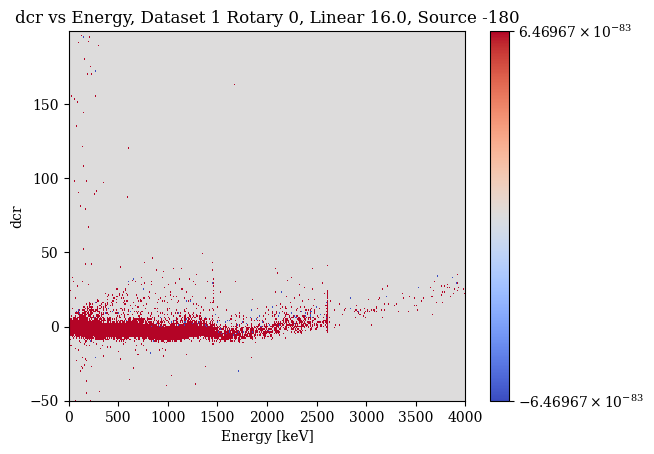

In [37]:
plot_parE("dcr", dcr_energy_hist) #plot only the runs in `runs`

## T/E

In [22]:
toe_energy_hist = make_parE_hist("ToE")

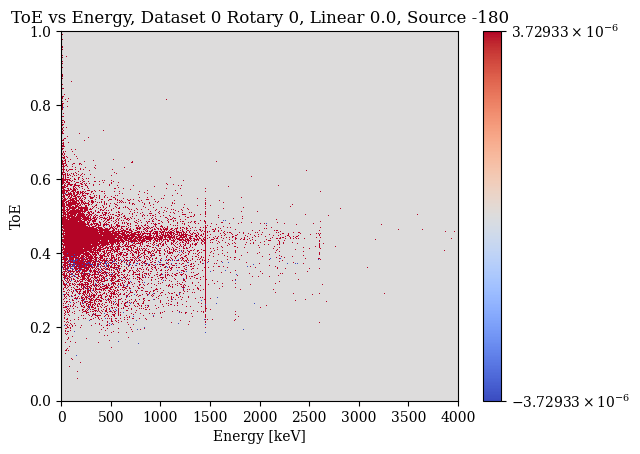

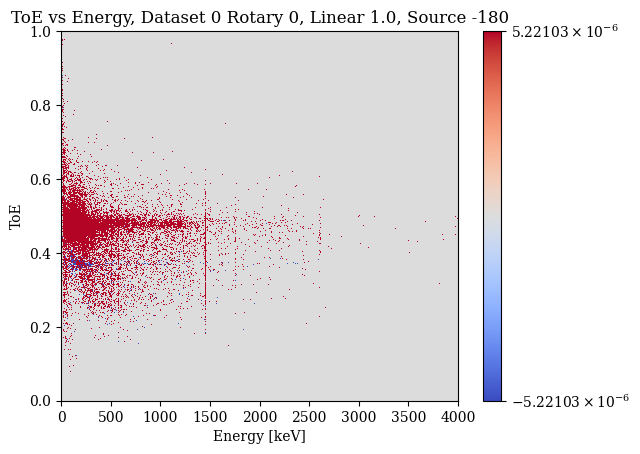

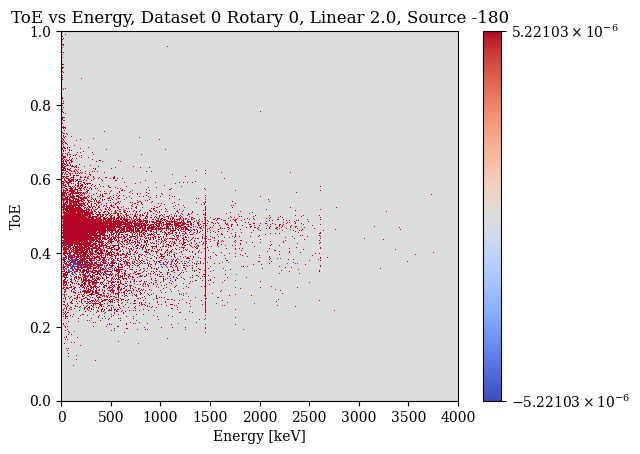

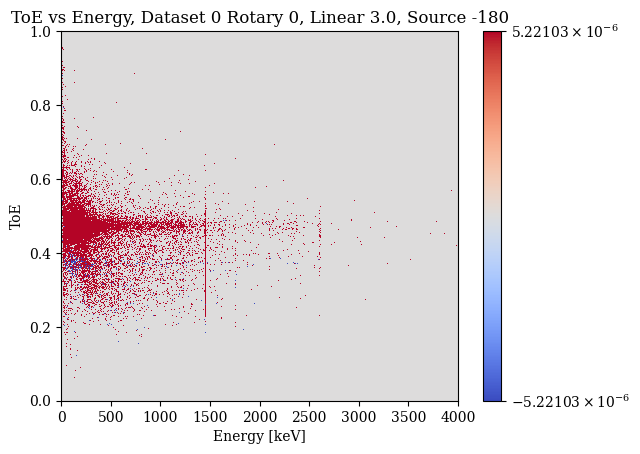

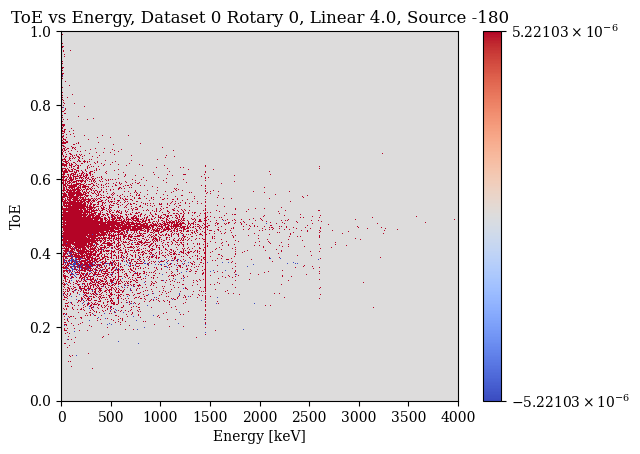

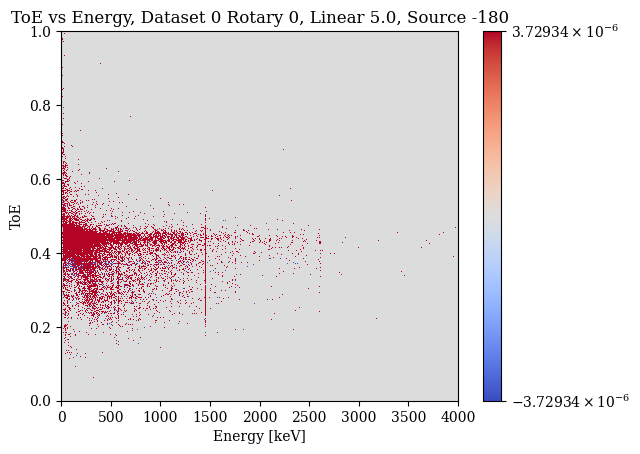

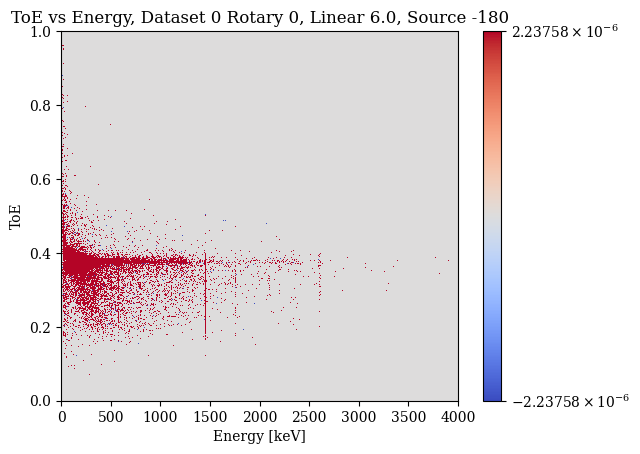

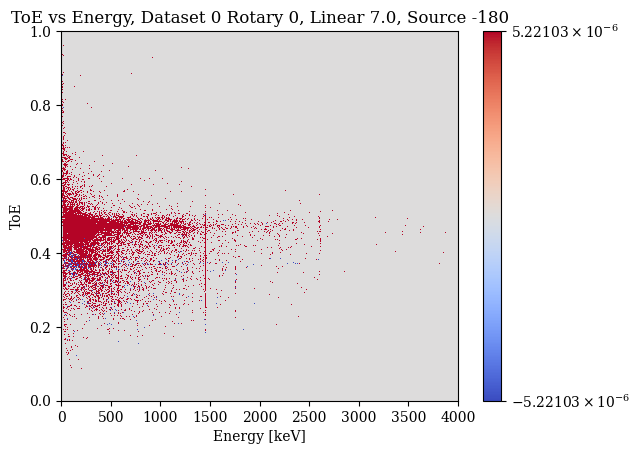

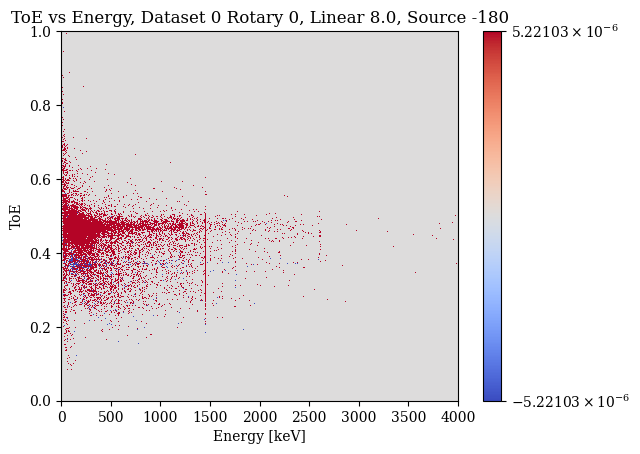

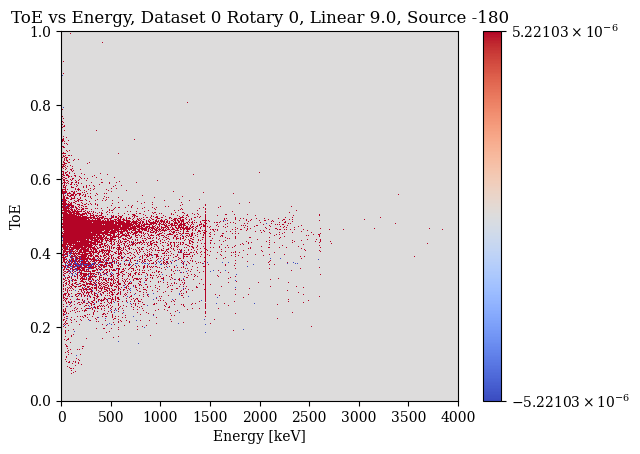

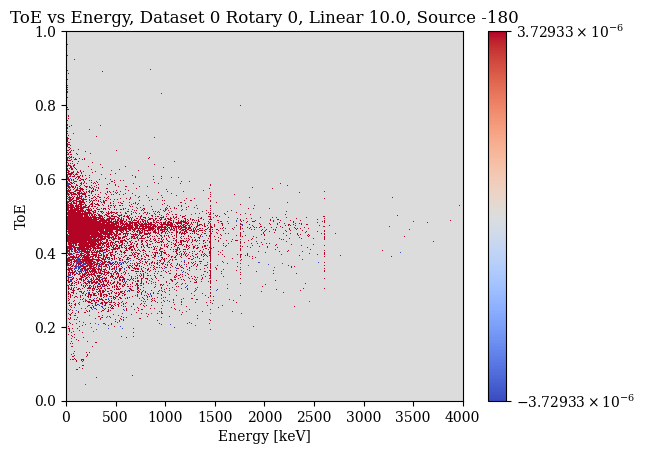

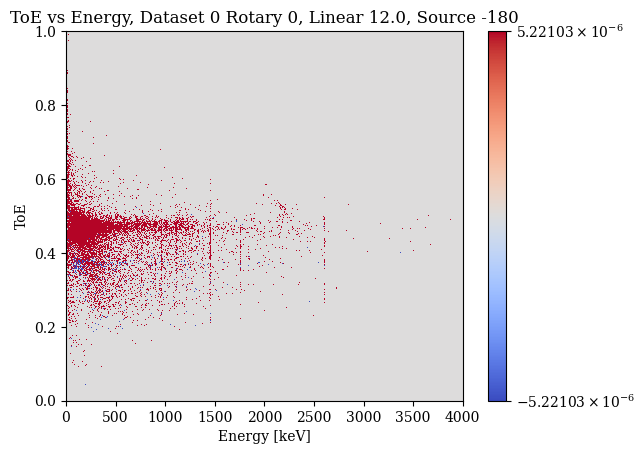

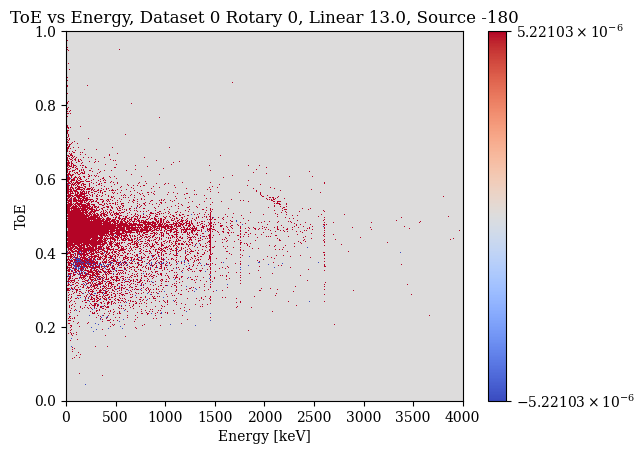

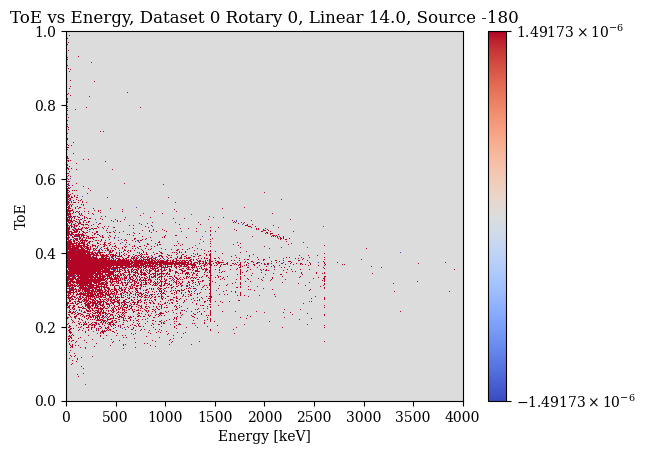

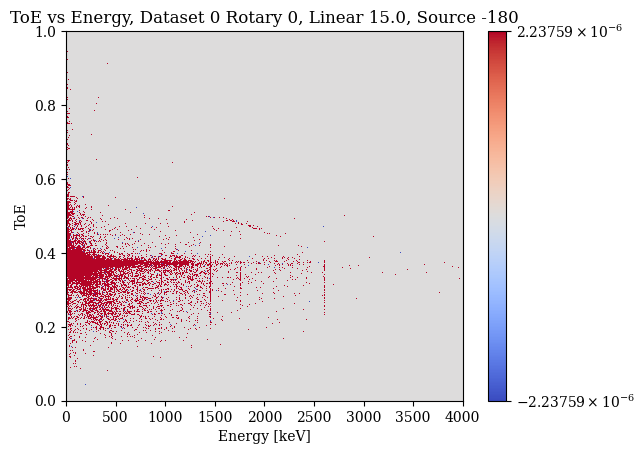

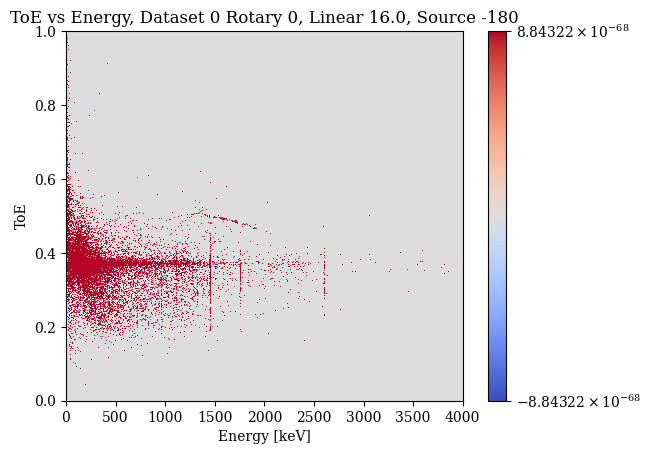

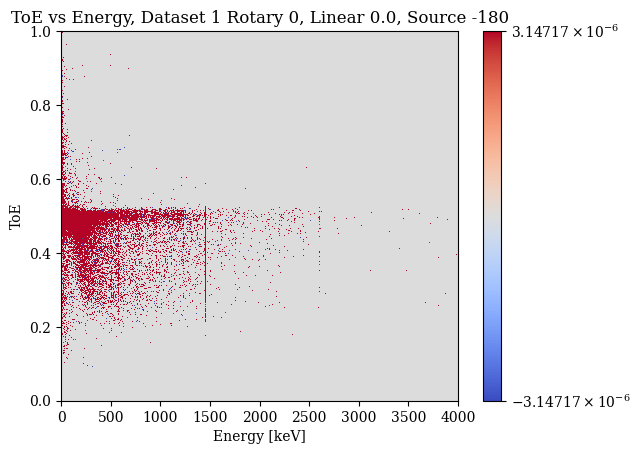

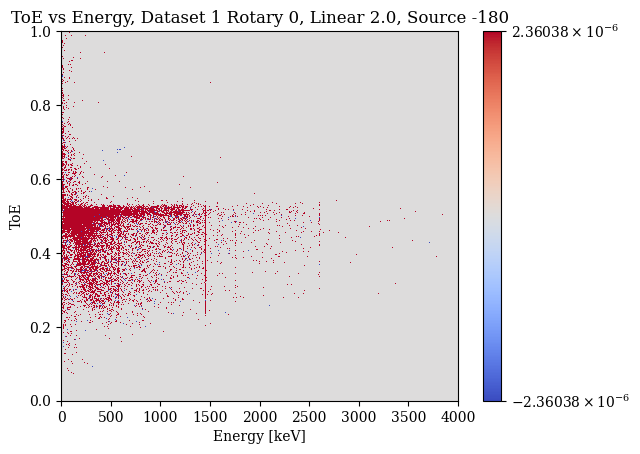

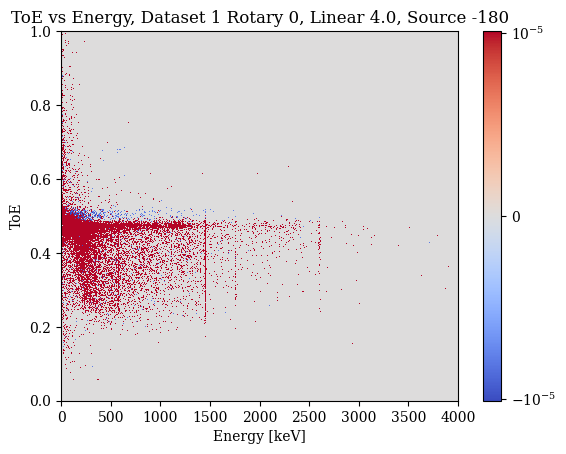

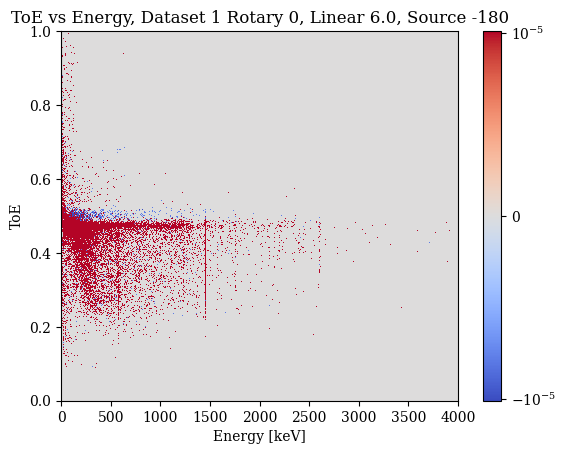

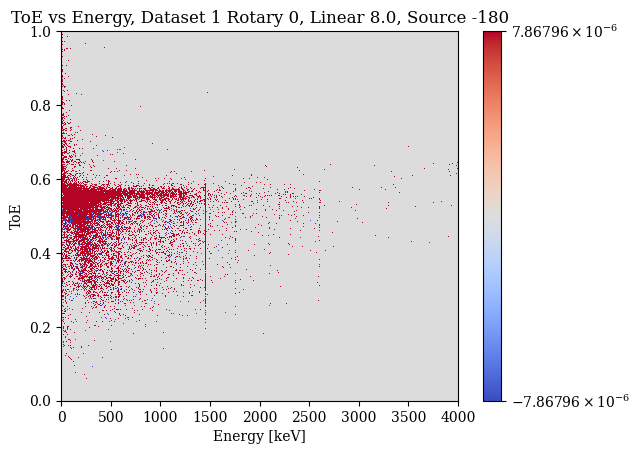

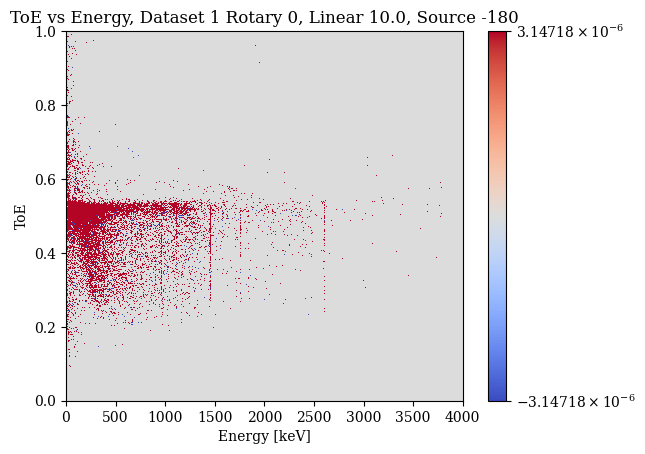

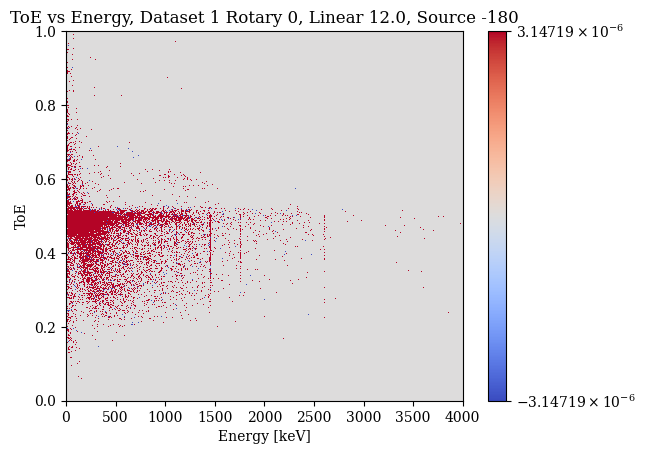

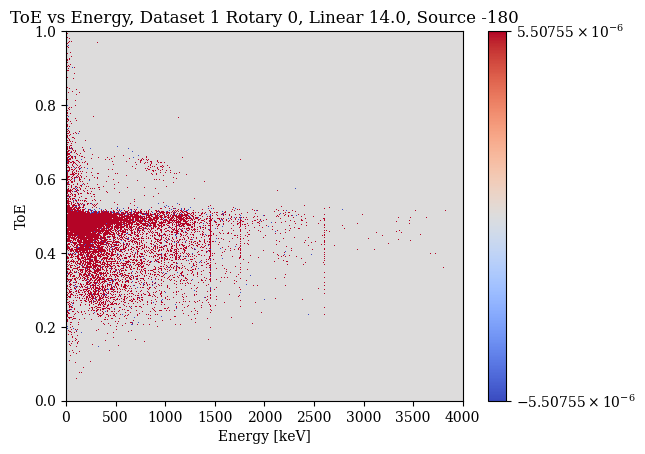

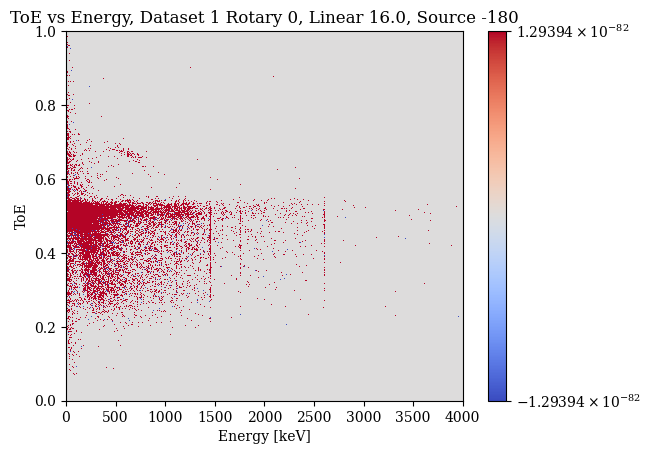

In [41]:
# plot_parE("ToE", toe_energy_hist) #plot every alpha run
plot_parE("ToE", toe_energy_hist) #plot only the runs in `runs`

## tp20 - tp0

In [23]:
tp20_energy_hist = make_parE_hist("tp_20")

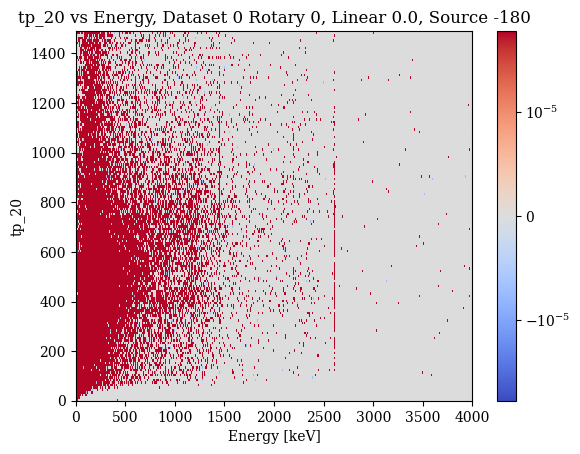

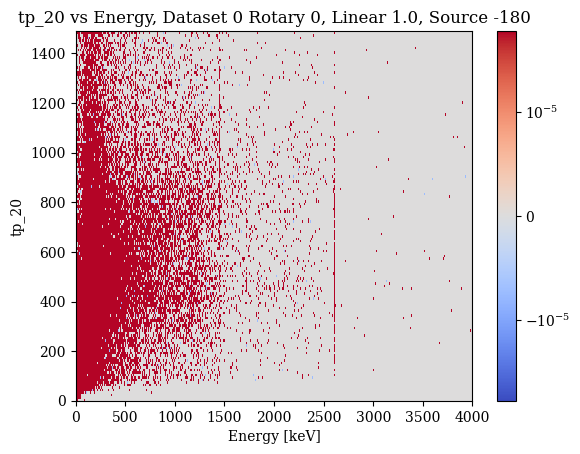

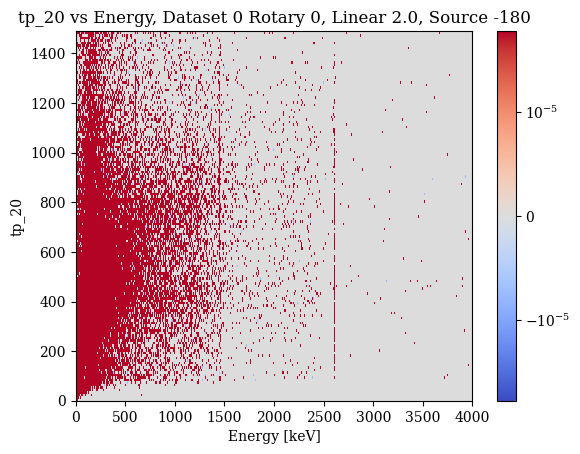

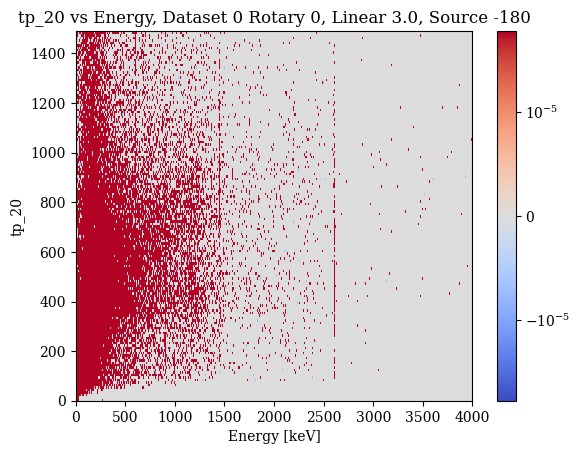

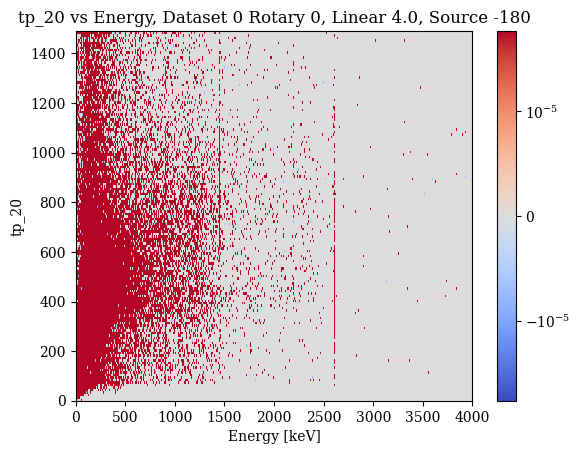

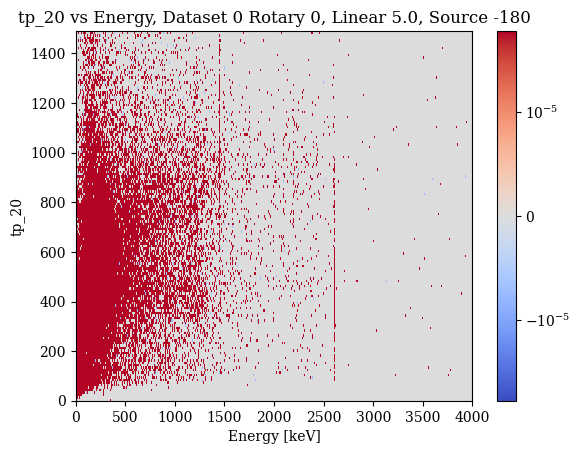

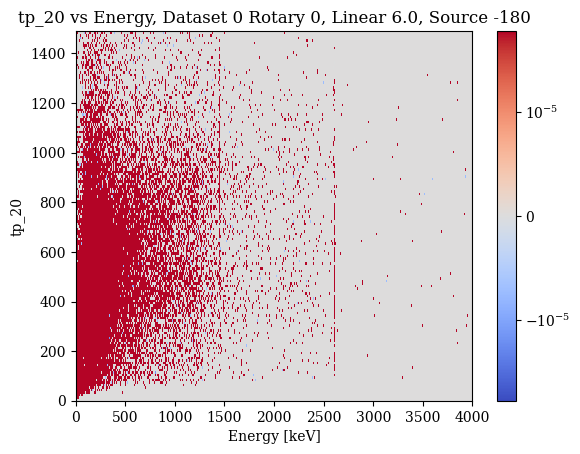

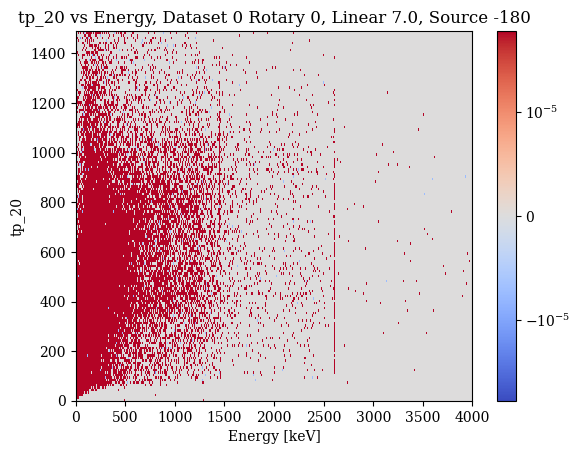

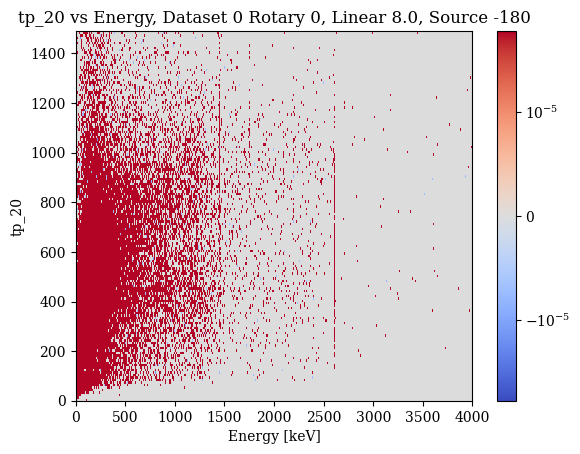

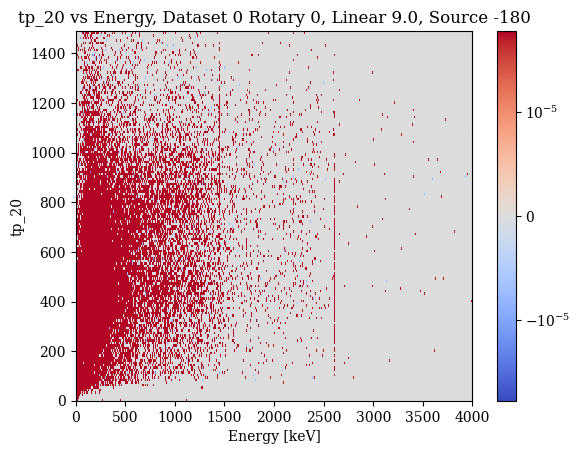

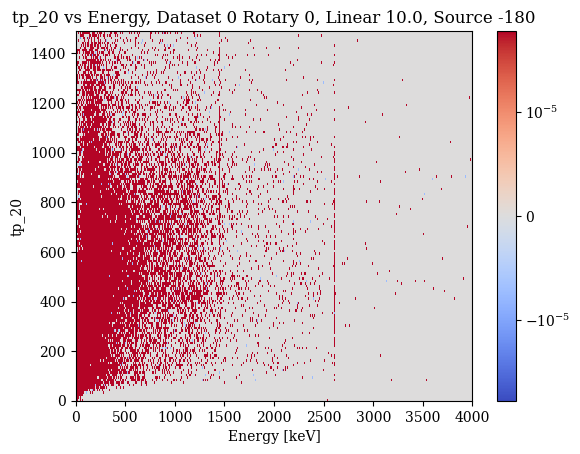

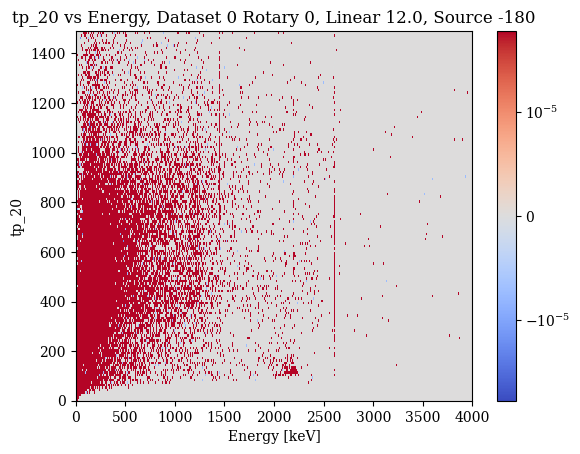

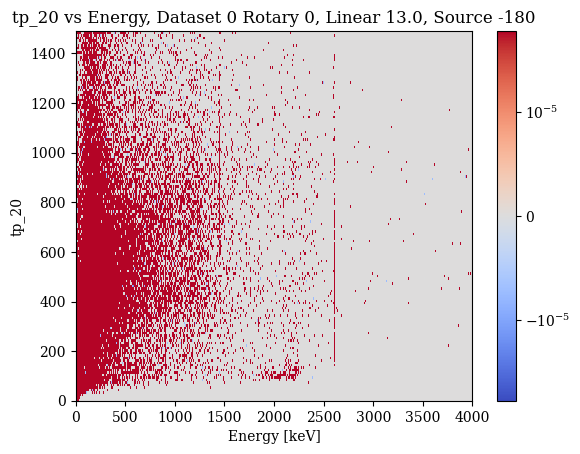

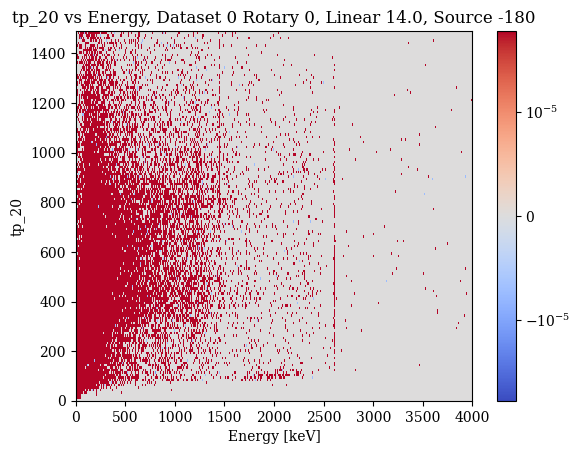

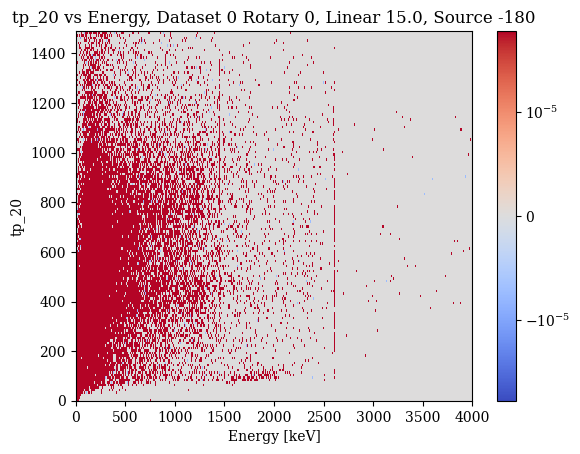

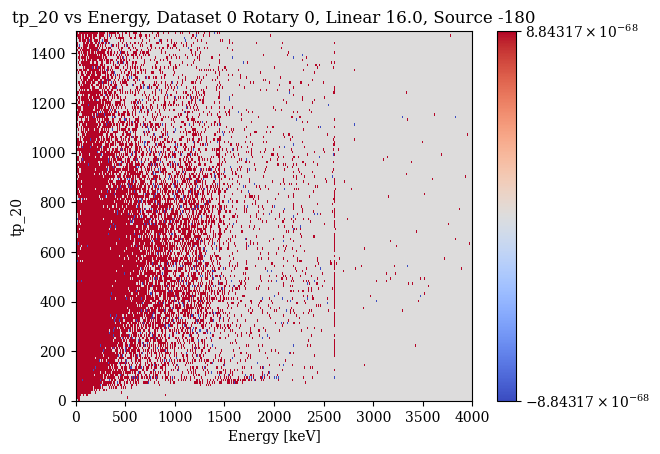

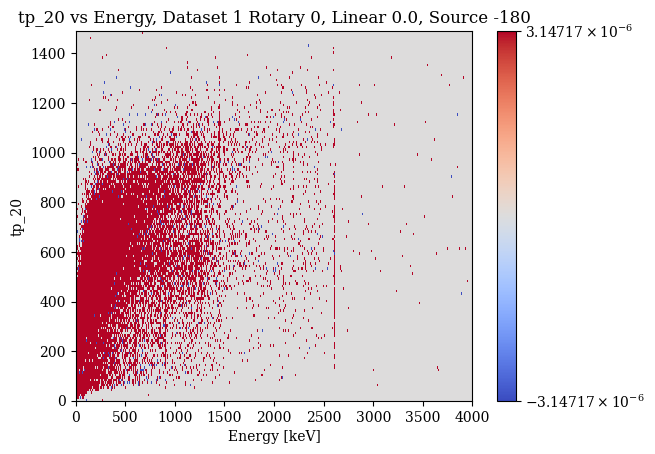

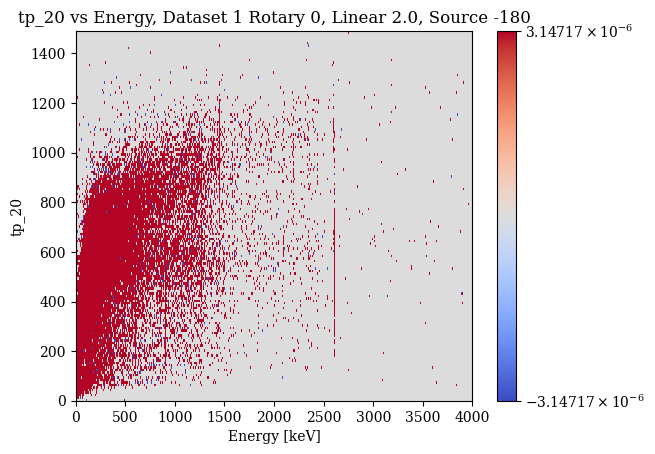

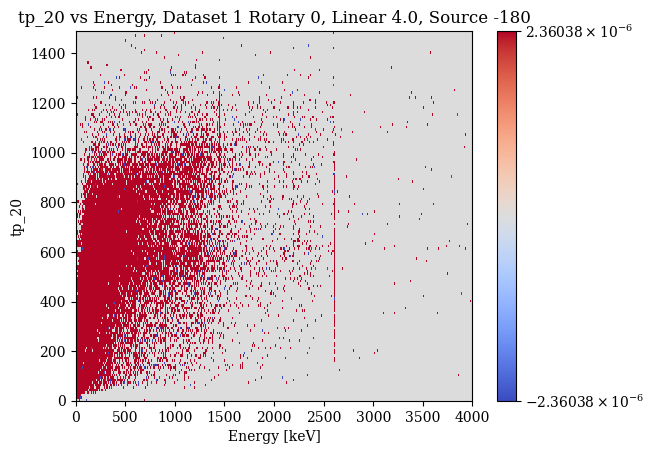

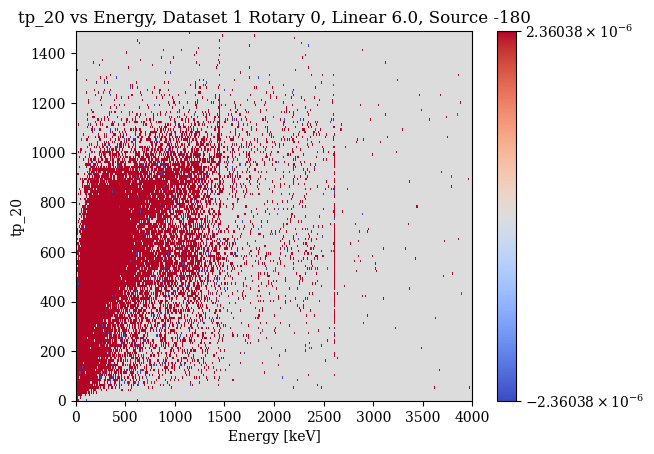

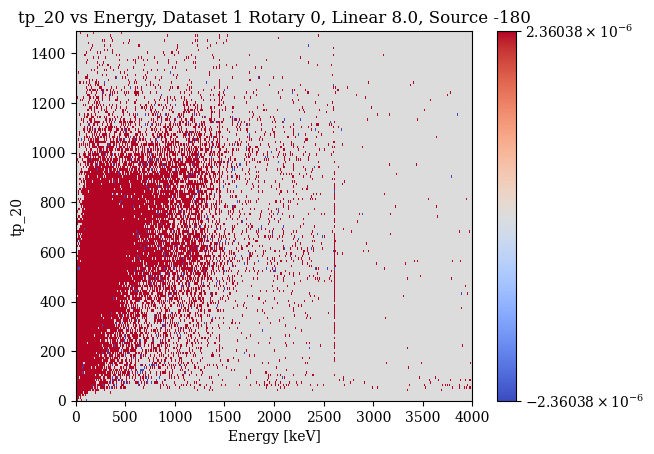

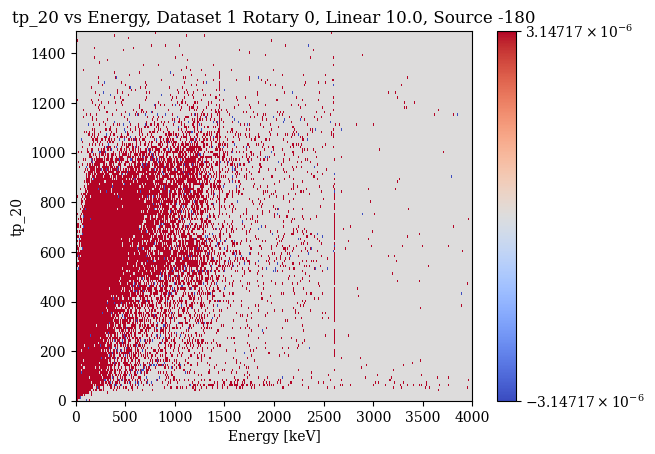

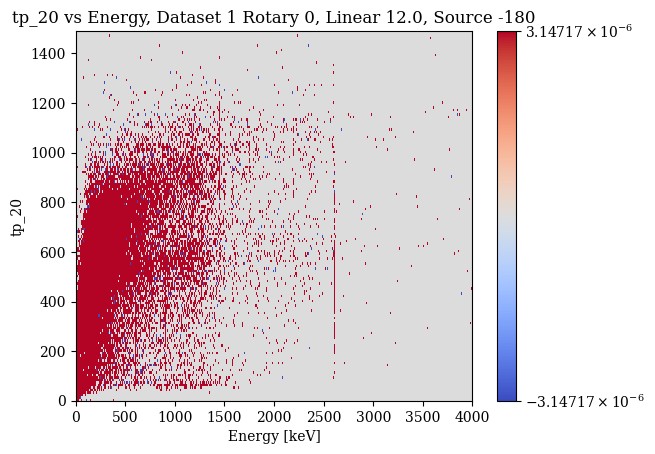

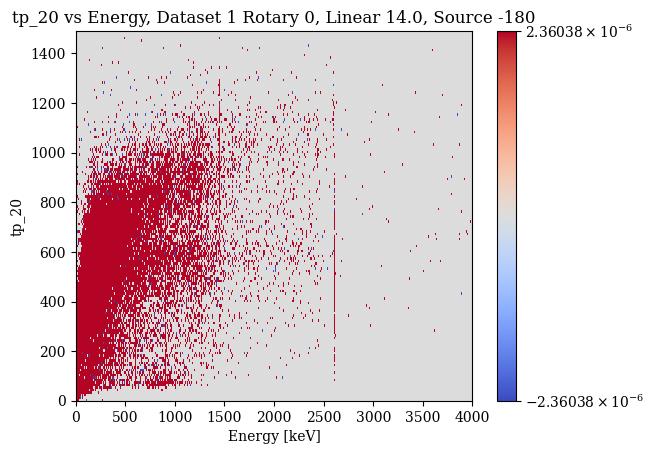

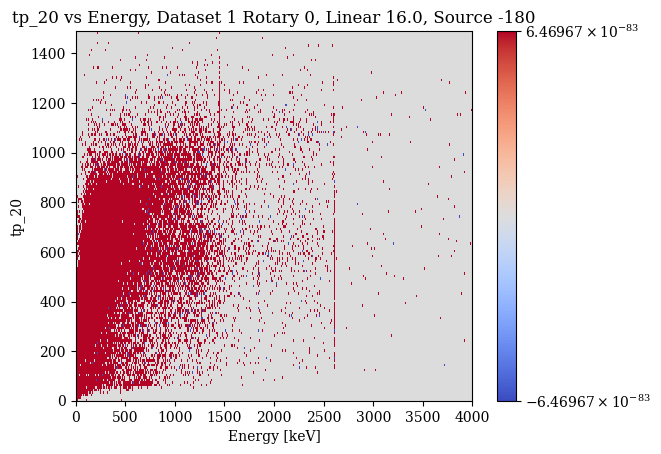

In [49]:
plot_parE("tp_20", tp20_energy_hist)

# Alpha Rates

**Pre-Reqs**: Background and alpha, calibrated energy histograms

**Human Input**: low energy threshold for alphas

Number of events in alpha run - number of events in background run

In [20]:
low_e_thresh = 200 # keV
thresh_idx = np.argmin(np.abs(cal_ebins - low_e_thresh))

alpha_rates = {}
for ds in alp_cal_spec:
    alpha_rates[ds] = {}
    for run in alp_cal_spec[ds]:
        lin = rdb_df.loc[run]['linear']
        rot = rdb_df.loc[run]['rotary']
        
        if rot not in alpha_rates[ds]:
            alpha_rates[ds][rot] = {}        
        
        alpha_rates[ds][rot][lin] = np.sum(alp_cal_spec[ds][run][thresh_idx:]/data[ds]['alp'][run]['rt'] - bkg_cal_spec[ds][thresh_idx:]/data[ds]['bkg']['rt'])

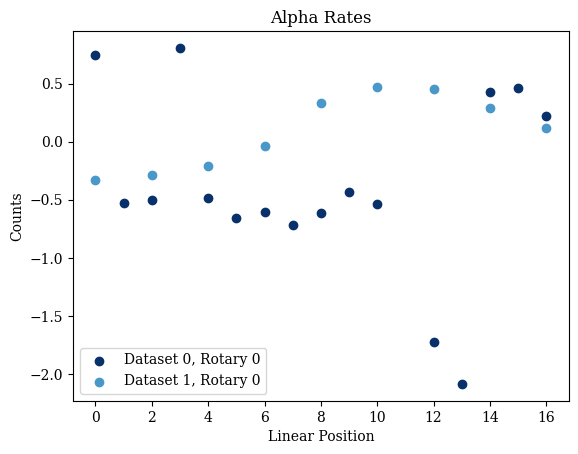

In [21]:
rotary_colors = {
    0: mpl.cm.get_cmap('Blues'),
    180: mpl.cm.get_cmap('Greens'),
    145: mpl.cm.get_cmap('Reds')
}

plt.figure()
plt.title(f"Alpha Rates")
plt.xlabel("Linear Position")
plt.ylabel("Counts")
for ds in alpha_rates:
    for rot in alpha_rates[ds]:
        plt.scatter(alpha_rates[ds][rot].keys(), alpha_rates[ds][rot].values(), label=f'Dataset {ds}, Rotary {rot}', color=rotary_colors[rot](1-ds*0.4))
    plt.legend(loc='lower left')

# Drifting T/E

**Pre-Reqs**: None

**Human Input**: None

Looks at T/E distributions on a run-by-run basis, looking for correlations with linear position. Also looks for drifting within a run by looking at scatter plots of timestamp vs. T/E and cycle-by-cycle distributions of T/E

In [22]:
# Set up color maps
lin_cmap = mpl.cm.get_cmap('rainbow')
lin_colors = {}
min_lin = rdb_df['linear'].min()
max_lin = rdb_df['linear'].max()

for lin in rdb_df['linear'].unique():
    frac = (lin - min_lin) / (max_lin - min_lin)
    lin_colors[lin] = lin_cmap(frac)

In [23]:
# Make T/E histograms by run
ToE_hists = {}
for ds, ds_df in rdb_df.groupby(by="dataset"):
    ToE_hists[ds] = {}
    
    for run in ds_df.index:
        files = fdb.df.query(f"run == {run}").index
        t = ds_df.loc[run]['type']
        hist = None
        
        for file in files:
            if t == 'alp':
                d = data[ds]["alp"][run][file]['ToE']
            else:
                d = data[ds][t][file]['ToE']
                
            if hist is None:
                hist = np.histogram(d, bins=toe_bins)[0]
            else:
                hist += np.histogram(d, bins=toe_bins)[0]
        ToE_hists[ds][run] = hist

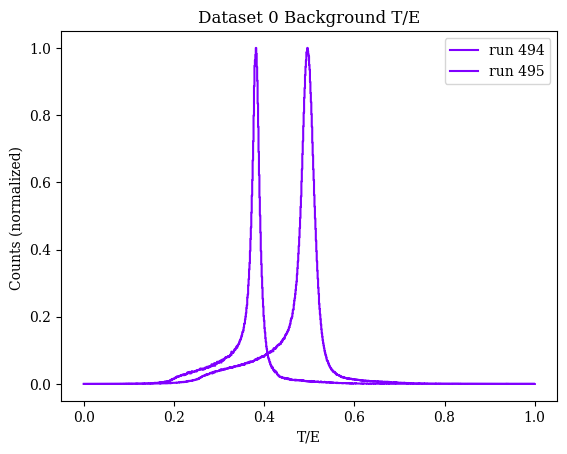

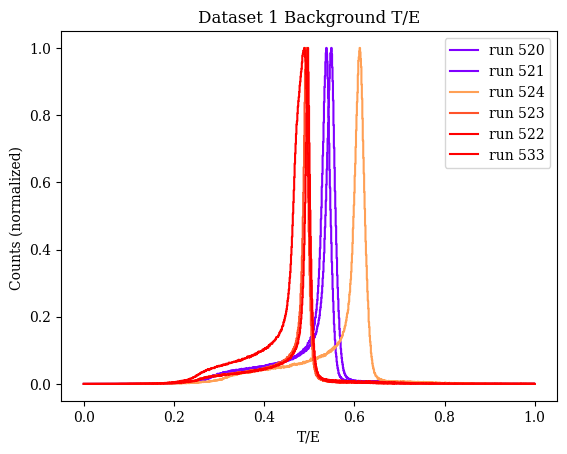

In [28]:
# Plot background T/E, color-coding with linear position
for ds in ToE_hists:
    plt.figure()
    plt.title(f"Dataset {ds} Background T/E")
    plt.xlabel("T/E")
    plt.ylabel("Counts (normalized) ")
    for run in rdb_df.query(f' dataset == {ds} and type == "bkg" ').index:
        lin = rdb_df.loc[run]['linear']
        pgh.plot_hist(ToE_hists[ds][run]/np.max(ToE_hists[ds][run]), bins=toe_bins, color=lin_colors[lin], label=f'run {run}')
    plt.legend()

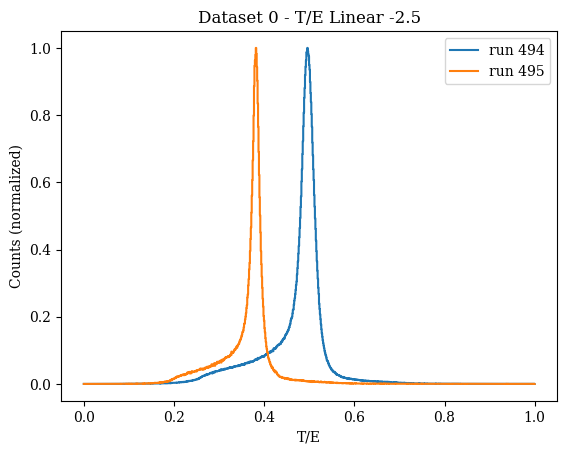

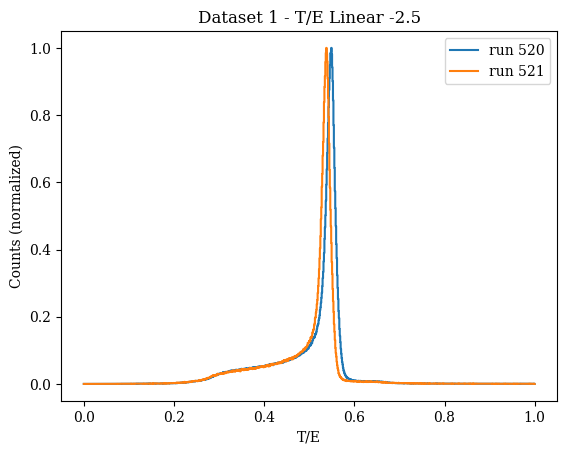

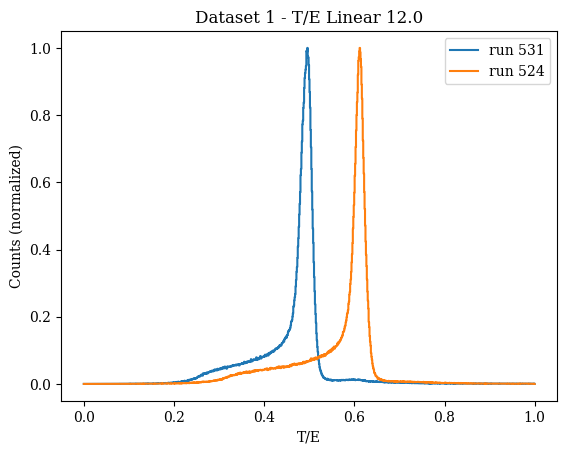

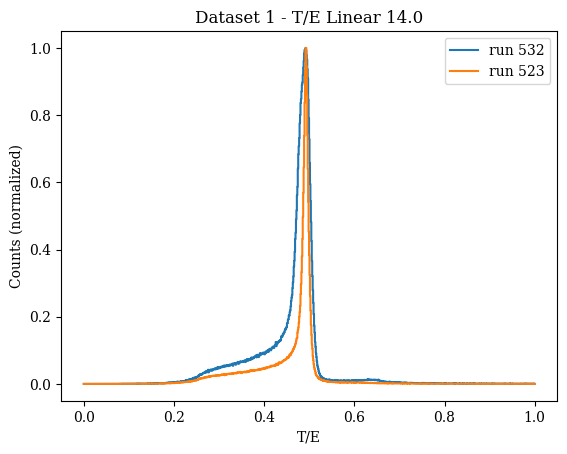

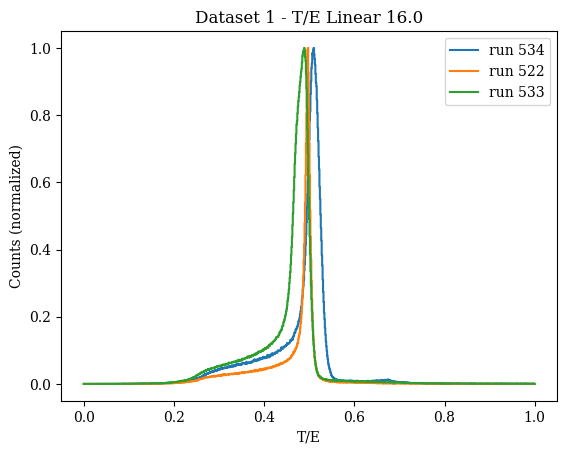

In [29]:
# Plot T/E for the same linear position if we have multiple runs at that position
for ds, ds_df in rdb_df.groupby(by="dataset"):
    for lin, lin_df in ds_df.groupby(by="linear"):
        if len(lin_df) > 1: 
            plt.figure()
            plt.title(f"Dataset {ds} - T/E Linear {lin}")
            plt.xlabel("T/E")
            plt.ylabel("Counts (normalized)")
            for run in lin_df.index:
                pgh.plot_hist(ToE_hists[ds][run]/np.max(ToE_hists[ds][run]), bins=toe_bins, label=f'run {run}')
            plt.legend()

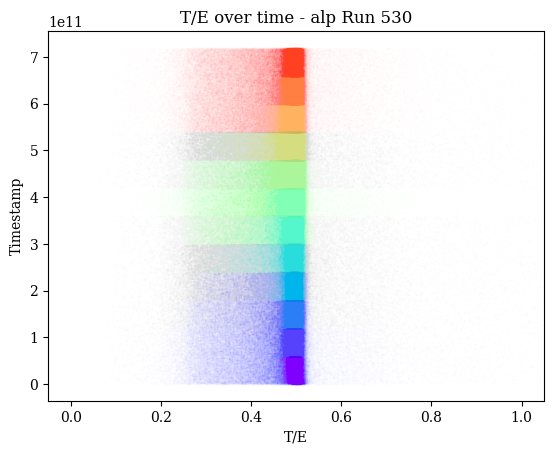

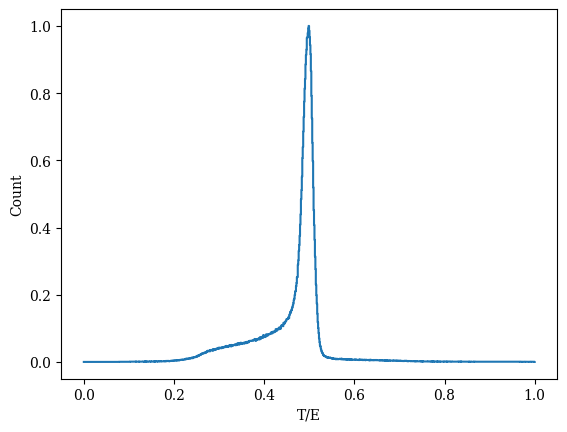

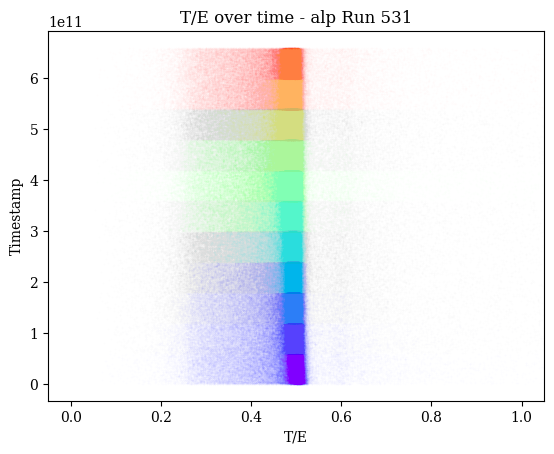

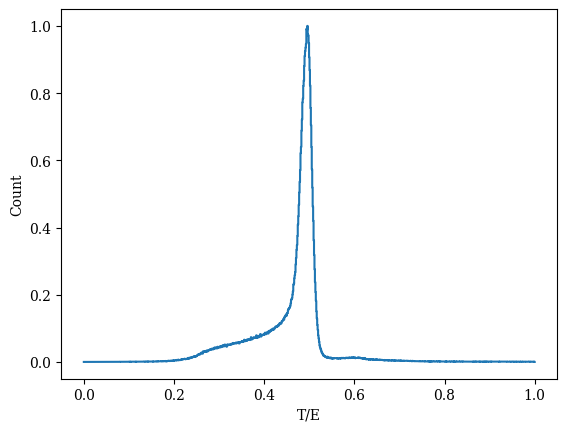

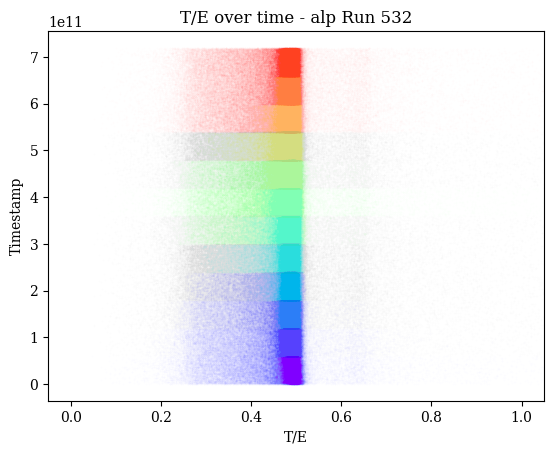

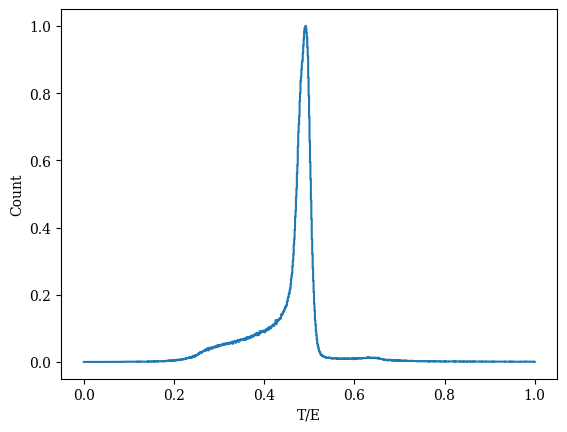

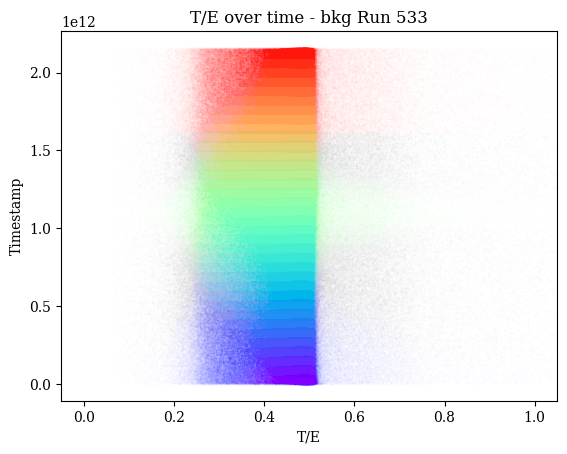

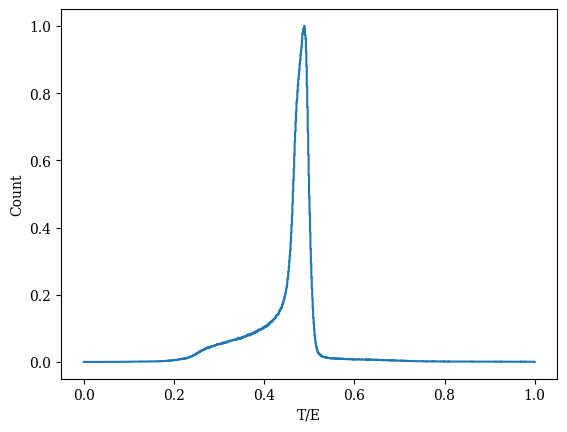

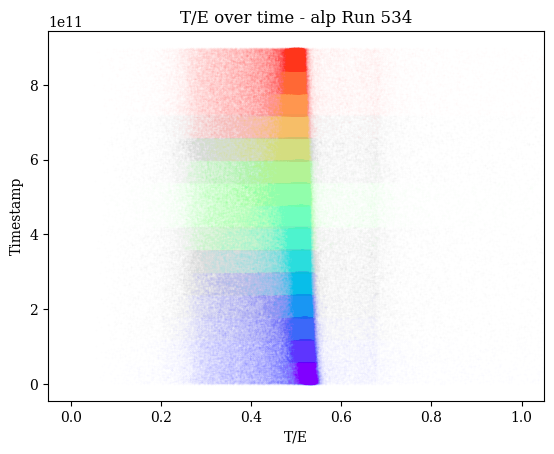

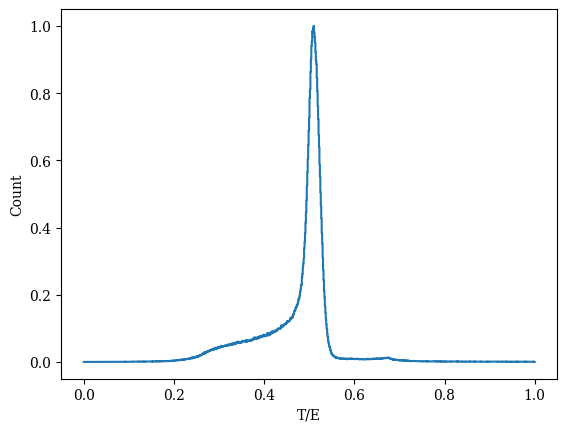

In [25]:
runs = [530, 531, 532, 533, 534]
ds = 1
cmap = mpl.cm.get_cmap('rainbow')

for run in runs:
    files = fdb.df.query(f"run == {run}").index
    t = ds_df.loc[run]['type']
    ts = 0


    plt.figure()

    for i, file in enumerate(files):
        if t == 'alp':
            plt.scatter(data[ds][t][run][file]['ToE'], ts + data[ds][t][run][file]['timestamp'].nda, marker=".", alpha=0.006, s=1, color=cmap(i/len(files)))
            plt.ylabel("Timestamp")
            plt.xlabel("T/E")
            ts += np.max(data[ds][t][run][file]['timestamp'].nda)
        else:
            plt.scatter(data[ds][t][file]['ToE'], ts + data[ds][t][file]['timestamp'].nda, marker=".", alpha=0.006, s=1, color=cmap(i/len(files)))
            plt.ylabel("Timestamp")
            plt.xlabel("T/E")
            ts += np.max(data[ds][t][file]['timestamp'].nda)

    plt.xlim(-0.05, 1.05)
    plt.title(f"T/E over time - {t} Run {run}")

    plt.figure()
    pgh.plot_hist(ToE_hists[ds][run]/np.max(ToE_hists[ds][run]), bins=toe_bins, label=f'run {run}')
    plt.ylabel('Count')
    plt.xlabel('T/E')

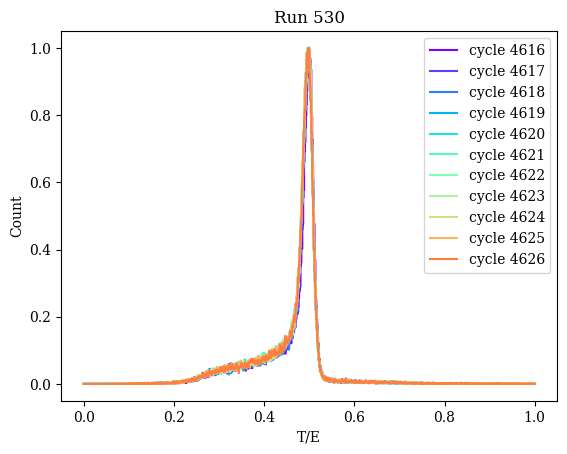

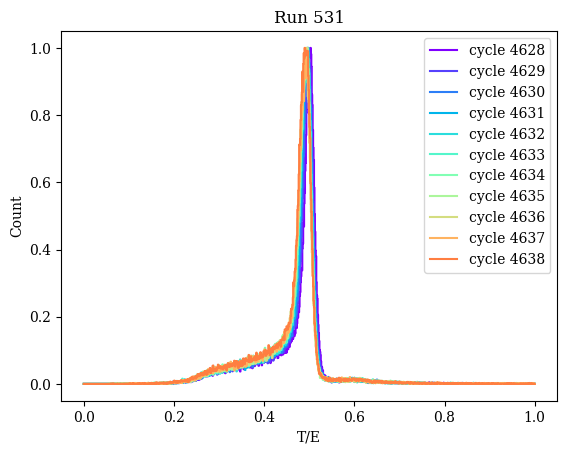

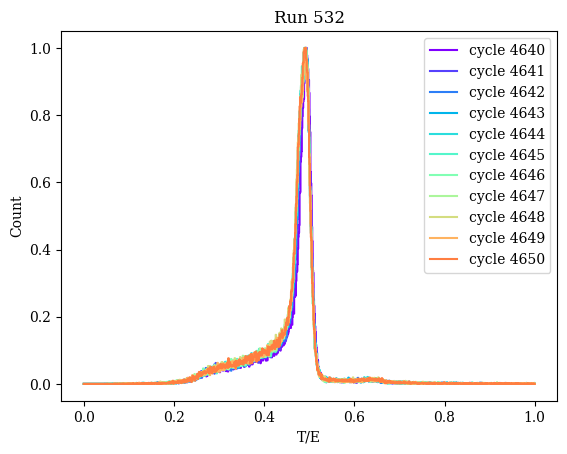

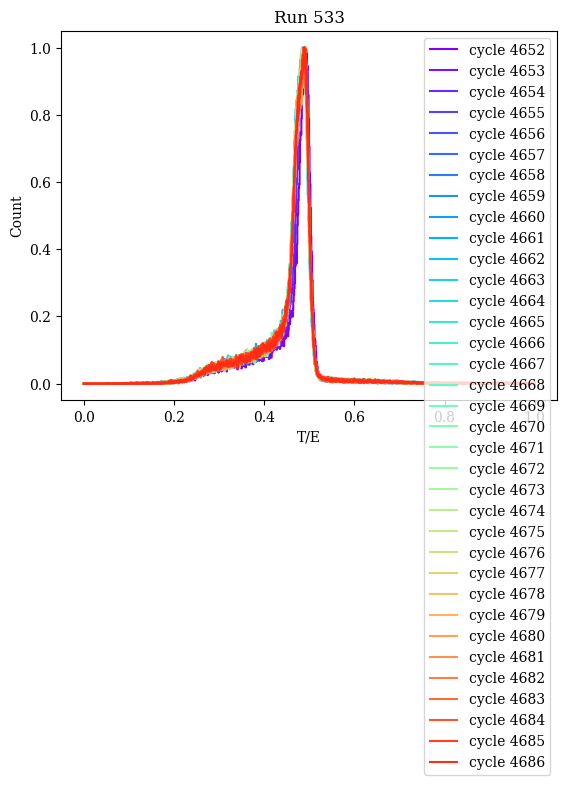

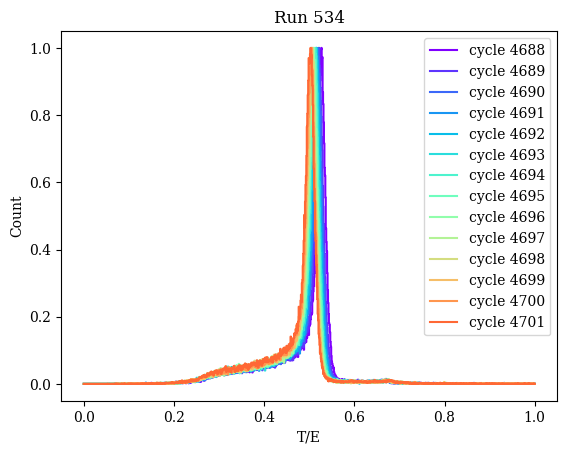

In [26]:
for run in runs:
    files = fdb.df.query(f"run == {run}").index
    t = ds_df.loc[run]['type']
    ts = 0

    cmap = mpl.cm.get_cmap('rainbow')


    plt.figure()

    for file in files[:-1]:
        if t == 'alp':
            hist = np.histogram(data[ds][t][run][file]['ToE'], bins=toe_bins)[0]
            pgh.plot_hist(hist/np.max(hist), bins=toe_bins, label=f'cycle {fdb.df.loc[file]["cycle"]}', color=cmap(list(files).index(file)/len(files)))
        else:
            hist = np.histogram(data[ds][t][file]['ToE'], bins=toe_bins)[0]
            pgh.plot_hist(hist/np.max(hist), bins=toe_bins, label=f'cycle {fdb.df.loc[file]["cycle"]}', color=cmap(list(files).index(file)/len(files)))

    #plt.xlim(0.2, 0.5)
    #plt.ylim(0, 0.15)
    plt.legend()
    plt.ylabel('Count')
    plt.xlabel('T/E')
    plt.title(f"Run {run}")

# Calibrating T/E

**Pre-Reqs**: Drifting T/E

**Human Input**: None

Shift T/E distributions for each cycle to align the peaks at zero. 

# Waveforms and Alphas

## Bulk Waveforms

**Pre-Reqs**: Drifting T/E

**Human Input**: None

This will build a superpulse out of 50 (but you can change how many) waveforms in the bulk of the T/E distribution. 

In [56]:
num_wfs = 500

bulk_superpulse = {}

for ds, ds_df in rdb_df.groupby(by="dataset"):
    bulk_superpulse[ds] = {}
    for run in ds_df.query(" type == 'bkg' ").index:
        ToE_avg = np.average(pgh.get_bin_centers(toe_bins), weights=ToE_hists[ds][run])
        ToE_fwhm, _ = pgh.get_fwhm(ToE_hists[ds][run], toe_bins)
        
        dl.reset()
        dl.set_files(f"run == {run}")
        dl.set_cuts({"hit": f" abs( ToE - {ToE_avg} ) < {ToE_fwhm * 0.1}"})
        dl.set_output(merge_files=True, columns=["waveform", "bl"])

        el = dl.build_entry_list()
        bulk_data = dl.load(el[:min(num_wfs, len(el))])
        wfs = bulk_data['waveform']['values'].nda
        bls = bulk_data['bl'].nda 
        subbed = np.subtract(wfs.T, bls).T
        norm_wfs = subbed / subbed.max(axis = 1, keepdims = True)
        
        bulk_superpulse[ds][run] = np.average(norm_wfs, axis=0)

Building entry list:   3%|3         | 1/32 [00:00<00:00, 178.78keys/s, key=4065]

Loading data:  33%|###3      | 1/3 [00:00<00:00, 145.05it/s, table=0, tier=raw]

Building entry list:  12%|#2        | 1/8 [00:00<00:00, 189.61keys/s, key=4097]

Loading data:  33%|###3      | 1/3 [00:00<00:00, 150.42it/s, table=0, tier=raw]

Building entry list:   5%|5         | 1/19 [00:00<00:00, 189.14keys/s, key=4489]

Loading data:  33%|###3      | 1/3 [00:00<00:00, 144.33it/s, table=0, tier=raw]

Building entry list:   8%|8         | 1/12 [00:00<00:00, 190.28keys/s, key=4508]

Loading data:  33%|###3      | 1/3 [00:00<00:00, 145.40it/s, table=0, tier=raw]

Building entry list:   8%|8         | 1/12 [00:00<00:00, 183.20keys/s, key=4543]

Loading data:  33%|###3      | 1/3 [00:00<00:00, 134.76it/s, table=0, tier=raw]

Building entry list:   8%|8         | 1/12 [00:00<00:00, 180.36keys/s, key=4531]

Loading data:  33%|###3      | 1/3 [00:00<00:00, 137.54it/s, table=0, tier=raw]

Building entry list:   9%|9         | 1/11 [00:00<00:00, 184.55keys/s, key=4520]

Loading data:  33%|###3      | 1/3 [00:00<00:00, 141.42it/s, table=0, tier=raw]

Building entry list:   3%|2         | 1/36 [00:00<00:00, 181.24keys/s, key=4652]

Loading data:  33%|###3      | 1/3 [00:00<00:00, 141.17it/s, table=0, tier=raw]

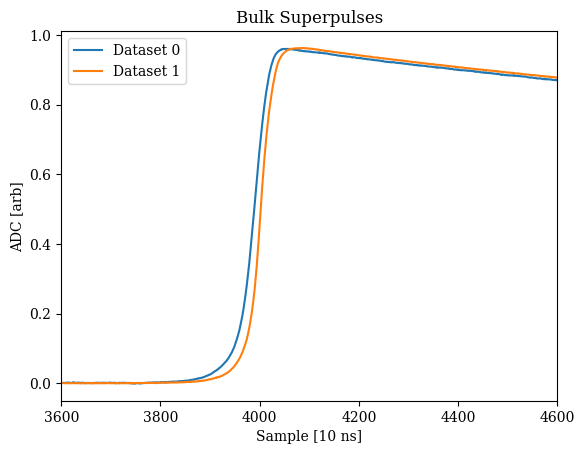

In [57]:
# Plot the superpulses
plt.figure()
plt.xlim(3600, 4600)
plt.title("Bulk Superpulses")
plt.xlabel("Sample [10 ns]")
plt.ylabel("ADC [arb]")
for ds in bulk_superpulse:
    super_superpulse = np.average(np.array(list(bulk_superpulse[ds].values())), axis=0)
    plt.plot(super_superpulse, label=f"Dataset {ds}")
plt.legend()

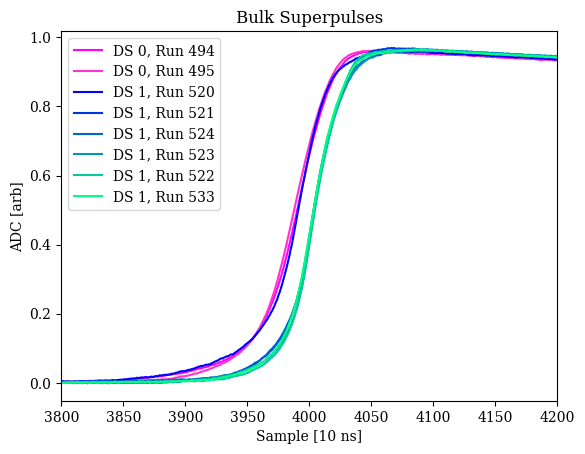

In [58]:
# Plot the superpulses run-by-run
cmap_options = ["spring", "winter", "terrain", "ocean"]


plt.figure()
plt.xlim(3800, 4200)
plt.title("Bulk Superpulses")
plt.xlabel("Sample [10 ns]")
plt.ylabel("ADC [arb]")
for ds in bulk_superpulse:
    cmap = mpl.cm.get_cmap(cmap_options[ds])
    for i, run in enumerate(bulk_superpulse[ds]):
        plt.plot(bulk_superpulse[ds][run], label=f"DS {ds}, Run {run}", color=cmap(i*0.2))
plt.legend()

## Alpha Cuts

**Pre-Reqs**: "Bulk Waveforms", and "Parameter vs. Energy Plots" is useful for setting cuts

**Human Input**: Alpha cuts

This will load waveforms that pass the given cuts. It will first build an entry list, and then build a superpulse from chunks. 

Specifying energy cuts is difficult - we want to specify them in terms of calibrated energies, which don't exist on disk. So we have to "uncalibrate" the energies in order to apply the cuts. 

In [61]:
alp_cuts = {
    0: {
        510: f"dcr > 15 and trapEmax_ctc > {1800 / rdb_df.loc[510, 'cal_constant']}",
        511: f"ToE > 0.5 and trapEmax_ctc > {1800 / rdb_df.loc[511, 'cal_constant']}",
        512: f"ToE > 0.42 and trapEmax_ctc > {1500 / rdb_df.loc[512, 'cal_constant']}",
        513: f"ToE > 0.43 and trapEmax_ctc > {1450 / rdb_df.loc[513, 'cal_constant']}",
        514: f"ToE > 0.43 and trapEmax_ctc > {1100 / rdb_df.loc[514, 'cal_constant']}"
    },
    1: {
        525: f"tp_20 - tp_0 < 100 and trapEmax_ctc > {1000 / rdb_df.loc[525, 'cal_constant']}",
        531: f"ToE > 0.55 and trapEmax_ctc > {750 / rdb_df.loc[531, 'cal_constant']}",
        532: f"ToE > 0.55 and trapEmax_ctc > {500 / rdb_df.loc[532, 'cal_constant']}",
        534: f"ToE > 0.62 and trapEmax_ctc > {300 / rdb_df.loc[534, 'cal_constant']}"
    }
}

chunk_size = 1000

In [63]:
alp_superpulse = {}
alp_energy = {}
alp_dcr = {}
alp_toe = {}

for ds in alp_cuts:
    alp_superpulse[ds] = {}
    alp_dcr[ds] = {}
    alp_toe[ds] = {}
    alp_energy[ds] = {}
    for run in alp_cuts[ds]: 
        dl.reset()
        dl.set_files(f"run == {run}")
        dl.set_cuts({"hit": alp_cuts[ds][run]})
        dl.set_output(merge_files=True, columns=["waveform", "bl", "dcr", "trapEmax_ctc", "ToE", "tp_50"])

        el = dl.build_entry_list()
        for alp_data in dl.next(el, chunk_size=chunk_size):
            wfs = alp_data['waveform']['values'].nda
            bls = alp_data['bl'].nda 
            subbed = np.subtract(wfs.T, bls).T
            norm_wfs = subbed / subbed.max(axis = 1, keepdims = True)
            mid_wfs = norm_wfs[]
            
            if run not in alp_superpulse[ds]:
                alp_superpulse[ds][run] = np.sum(norm_wfs, axis=0)
                alp_dcr[ds][run] = alp_data['dcr'].nda
                alp_toe[ds][run] = alp_data['ToE'].nda
                alp_energy[ds][run] = alp_data['trapEmax_ctc'].nda * rdb_df.loc[run, 'cal_constant']
            else:
                alp_superpulse[ds][run] += np.sum(norm_wfs, axis=0)
                alp_dcr[ds][run] = np.append( alp_dcr[ds][run], alp_data['dcr'].nda )
                alp_toe[ds][run] = np.append( alp_toe[ds][run], alp_data['ToE'].nda )
                alp_energy[ds][run] = np.append( alp_energy[ds][run], alp_data['trapEmax_ctc'].nda * rdb_df.loc[run, 'cal_constant'] )
        alp_superpulse[ds][run] /= len(el)

Building entry list:  10%|#         | 1/10 [00:00<00:00, 195.32keys/s, key=4270]

Loading data:  33%|###3      | 1/3 [00:00<00:00, 132.16it/s, table=0, tier=raw]

Loading data:  33%|###3      | 1/3 [00:00<00:00, 122.68it/s, table=0, tier=raw]

Loading data:  33%|###3      | 1/3 [00:00<00:00, 114.53it/s, table=0, tier=raw]

Loading data:  33%|###3      | 1/3 [00:00<00:00, 118.42it/s, table=0, tier=raw]

Loading data:  33%|###3      | 1/3 [00:00<00:00, 127.85it/s, table=0, tier=raw]

Loading data:  33%|###3      | 1/3 [00:00<00:00, 119.41it/s, table=0, tier=raw]

Loading data:  33%|###3      | 1/3 [00:00<00:00, 125.33it/s, table=0, tier=raw]

Loading data:  33%|###3      | 1/3 [00:00<00:00, 124.29it/s, table=0, tier=raw]

Loading data:  33%|###3      | 1/3 [00:00<00:00, 134.88it/s, table=0, tier=raw]

Loading data:  33%|###3      | 1/3 [00:00<00:00, 130.51it/s, table=0, tier=raw]

Loading data:  33%|###3      | 1/3 [00:00<00:00, 125.74it/s, table=0, tier=raw]

Loading data:  33%|###3      | 1/3 [00:00<00:00, 125.48it/s, table=0, tier=raw]

Loading data:  33%|###3      | 1/3 [00:00<00:00, 138.09it/s, table=0, tier=raw]

Building entry list:   8%|8         | 1/12 [00:00<00:00, 189.95keys/s, key=4280]

Loading data:  33%|###3      | 1/3 [00:00<00:00, 140.36it/s, table=0, tier=raw]

Loading data:  33%|###3      | 1/3 [00:00<00:00, 129.04it/s, table=0, tier=raw]

Loading data:  33%|###3      | 1/3 [00:00<00:00, 119.57it/s, table=0, tier=raw]

Loading data:  33%|###3      | 1/3 [00:00<00:00, 122.86it/s, table=0, tier=raw]

Loading data:  33%|###3      | 1/3 [00:00<00:00, 120.48it/s, table=0, tier=raw]

Loading data:  33%|###3      | 1/3 [00:00<00:00, 110.25it/s, table=0, tier=raw]

Loading data:  33%|###3      | 1/3 [00:00<00:00, 125.73it/s, table=0, tier=raw]

Loading data:  33%|###3      | 1/3 [00:00<00:00, 121.21it/s, table=0, tier=raw]

Loading data:  33%|###3      | 1/3 [00:00<00:00, 126.01it/s, table=0, tier=raw]

Loading data:  33%|###3      | 1/3 [00:00<00:00, 134.57it/s, table=0, tier=raw]

Building entry list:   8%|8         | 1/12 [00:00<00:00, 186.94keys/s, key=4292]

Loading data:  33%|###3      | 1/3 [00:00<00:00, 133.03it/s, table=0, tier=raw]

Loading data:  33%|###3      | 1/3 [00:00<00:00, 117.19it/s, table=0, tier=raw]

Loading data:  33%|###3      | 1/3 [00:00<00:00, 115.25it/s, table=0, tier=raw]

Loading data:  33%|###3      | 1/3 [00:00<00:00, 117.14it/s, table=0, tier=raw]

Loading data:  33%|###3      | 1/3 [00:00<00:00, 126.25it/s, table=0, tier=raw]

Loading data:  33%|###3      | 1/3 [00:00<00:00, 118.85it/s, table=0, tier=raw]

Loading data:  33%|###3      | 1/3 [00:00<00:00, 114.78it/s, table=0, tier=raw]

Building entry list:   8%|8         | 1/12 [00:00<00:00, 178.88keys/s, key=4304]

Loading data:  33%|###3      | 1/3 [00:00<00:00, 132.95it/s, table=0, tier=raw]

Loading data:  33%|###3      | 1/3 [00:00<00:00, 120.41it/s, table=0, tier=raw]

Loading data:  33%|###3      | 1/3 [00:00<00:00, 118.86it/s, table=0, tier=raw]

Loading data:  33%|###3      | 1/3 [00:00<00:00, 119.66it/s, table=0, tier=raw]

Loading data:  33%|###3      | 1/3 [00:00<00:00, 117.96it/s, table=0, tier=raw]

Loading data:  33%|###3      | 1/3 [00:00<00:00, 133.76it/s, table=0, tier=raw]

Building entry list:   8%|8         | 1/12 [00:00<00:00, 188.01keys/s, key=4316]

Loading data:  33%|###3      | 1/3 [00:00<00:00, 129.94it/s, table=0, tier=raw]

Loading data:  33%|###3      | 1/3 [00:00<00:00, 107.62it/s, table=0, tier=raw]

Loading data:  33%|###3      | 1/3 [00:00<00:00, 127.10it/s, table=0, tier=raw]

Loading data:  33%|###3      | 1/3 [00:00<00:00, 119.38it/s, table=0, tier=raw]

Loading data:  33%|###3      | 1/3 [00:00<00:00, 127.33it/s, table=0, tier=raw]

Loading data:  33%|###3      | 1/3 [00:00<00:00, 122.78it/s, table=0, tier=raw]

Loading data:  33%|###3      | 1/3 [00:00<00:00, 121.58it/s, table=0, tier=raw]

Loading data:  33%|###3      | 1/3 [00:00<00:00, 121.88it/s, table=0, tier=raw]

Loading data:  33%|###3      | 1/3 [00:00<00:00, 131.47it/s, table=0, tier=raw]

Building entry list:   9%|9         | 1/11 [00:00<00:00, 190.67keys/s, key=4555]

Loading data:  33%|###3      | 1/3 [00:00<00:00, 130.00it/s, table=0, tier=raw]

Loading data:  33%|###3      | 1/3 [00:00<00:00, 120.13it/s, table=0, tier=raw]

Loading data:  33%|###3      | 1/3 [00:00<00:00, 120.31it/s, table=0, tier=raw]

Loading data:  33%|###3      | 1/3 [00:00<00:00, 107.95it/s, table=0, tier=raw]

Loading data:  33%|###3      | 1/3 [00:00<00:00, 143.80it/s, table=0, tier=raw]

Building entry list:   8%|8         | 1/12 [00:00<00:00, 198.13keys/s, key=4628]

Loading data:  33%|###3      | 1/3 [00:00<00:00, 135.75it/s, table=0, tier=raw]

Loading data:  33%|###3      | 1/3 [00:00<00:00, 122.74it/s, table=0, tier=raw]

Loading data:  33%|###3      | 1/3 [00:00<00:00, 122.32it/s, table=0, tier=raw]

Loading data:  33%|###3      | 1/3 [00:00<00:00, 118.31it/s, table=0, tier=raw]

Loading data:  33%|###3      | 1/3 [00:00<00:00, 125.85it/s, table=0, tier=raw]

Building entry list:   8%|8         | 1/12 [00:00<00:00, 189.99keys/s, key=4640]

Loading data:  33%|###3      | 1/3 [00:00<00:00, 139.43it/s, table=0, tier=raw]

Loading data:  33%|###3      | 1/3 [00:00<00:00, 126.90it/s, table=0, tier=raw]

Loading data:  33%|###3      | 1/3 [00:00<00:00, 125.10it/s, table=0, tier=raw]

Loading data:  33%|###3      | 1/3 [00:00<00:00, 108.76it/s, table=0, tier=raw]

Loading data:  33%|###3      | 1/3 [00:00<00:00, 122.55it/s, table=0, tier=raw]

Loading data:  33%|###3      | 1/3 [00:00<00:00, 122.05it/s, table=0, tier=raw]

Building entry list:   7%|6         | 1/15 [00:00<00:00, 186.51keys/s, key=4688]

Loading data:  33%|###3      | 1/3 [00:00<00:00, 126.82it/s, table=0, tier=raw]

Loading data:  33%|###3      | 1/3 [00:00<00:00, 120.55it/s, table=0, tier=raw]

Loading data:  33%|###3      | 1/3 [00:00<00:00, 120.86it/s, table=0, tier=raw]

Loading data:  33%|###3      | 1/3 [00:00<00:00, 123.38it/s, table=0, tier=raw]

Loading data:  33%|###3      | 1/3 [00:00<00:00, 122.50it/s, table=0, tier=raw]

Loading data:  33%|###3      | 1/3 [00:00<00:00, 115.33it/s, table=0, tier=raw]

Loading data:  33%|###3      | 1/3 [00:00<00:00, 118.42it/s, table=0, tier=raw]

### Alpha Waveforms

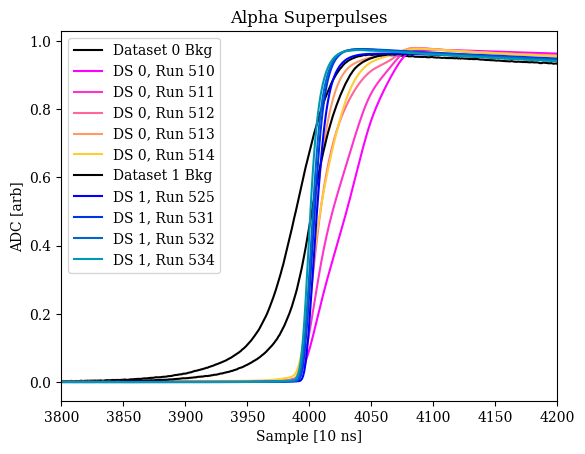

In [64]:
# Plot the superpulses run-by-run
cmap_options = ["spring", "winter", "terrain", "ocean"]


plt.figure()
plt.xlim(3800, 4200)
plt.title("Alpha Superpulses")
plt.xlabel("Sample [10 ns]")
plt.ylabel("ADC [arb]")

for ds in alp_superpulse:
    cmap = mpl.cm.get_cmap(cmap_options[ds])
    super_superpulse = np.average(np.array(list(bulk_superpulse[ds].values())), axis=0)
    plt.plot(super_superpulse, label=f"Dataset {ds} Bkg", color='black')
    for i, run in enumerate(alp_superpulse[ds]):
        plt.plot(alp_superpulse[ds][run], label=f"DS {ds}, Run {run}", color=cmap(i*0.2))
plt.legend()

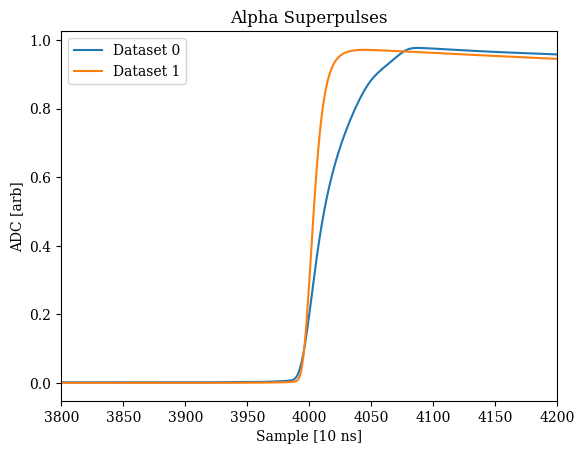

In [65]:
# Plot the superpulses for each dataset
cmap_options = ["spring", "winter", "terrain", "ocean"]


plt.figure()
plt.xlim(3800, 4200)
plt.title("Alpha Superpulses")
plt.xlabel("Sample [10 ns]")
plt.ylabel("ADC [arb]")

for ds in alp_superpulse:
    super_superpulse = np.average(np.array(list(alp_superpulse[ds].values())), axis=0)
    plt.plot(super_superpulse, label=f"Dataset {ds}")
plt.legend()

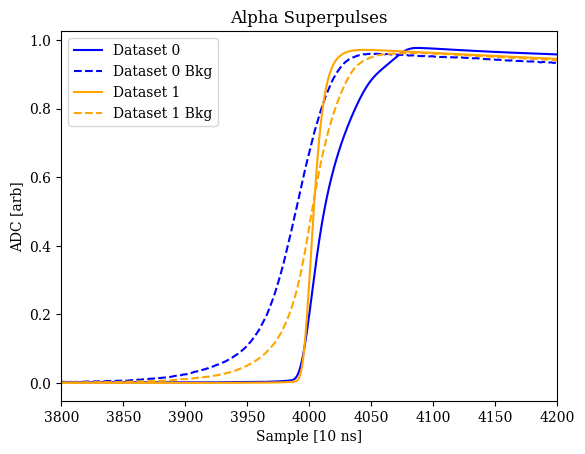

In [71]:
# Plot the superpulses for each dataset
colors = ['blue', 'orange']


plt.figure()
plt.xlim(3800, 4200)
plt.title("Alpha Superpulses")
plt.xlabel("Sample [10 ns]")
plt.ylabel("ADC [arb]")

for ds in alp_superpulse:
    super_superpulse = np.average(np.array(list(alp_superpulse[ds].values())), axis=0)
    bkg_superpulse = np.average(np.array(list(bulk_superpulse[ds].values())), axis=0)
    plt.plot(super_superpulse, label=f"Dataset {ds}", color=colors[ds])
    plt.plot(bkg_superpulse, label=f"Dataset {ds} Bkg", color=colors[ds], linestyle='dashed')
plt.legend()

### Alpha DCR

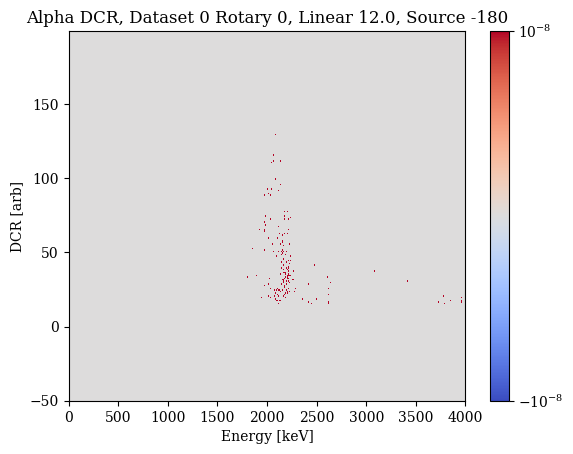

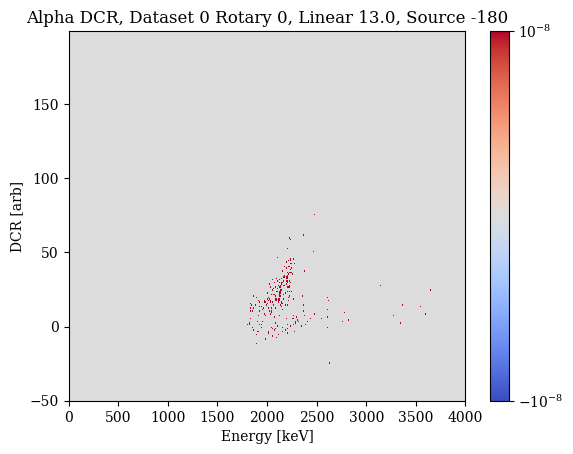

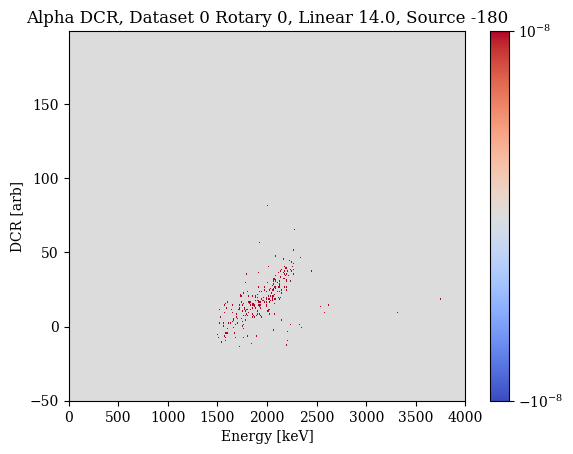

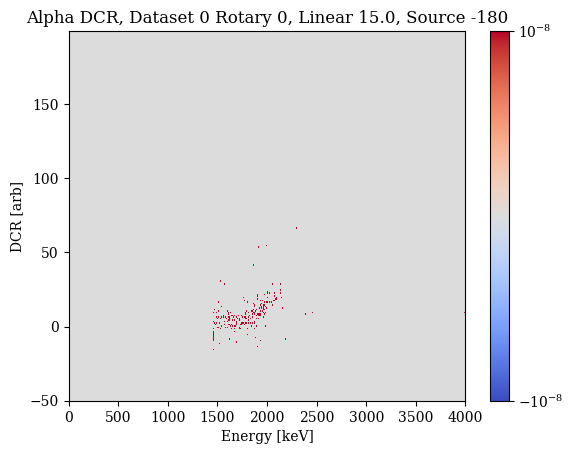

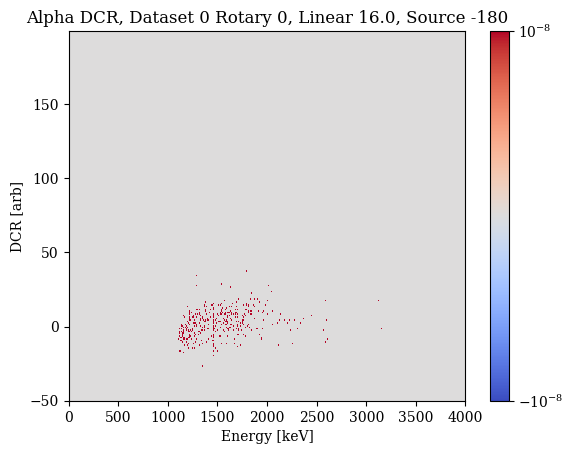

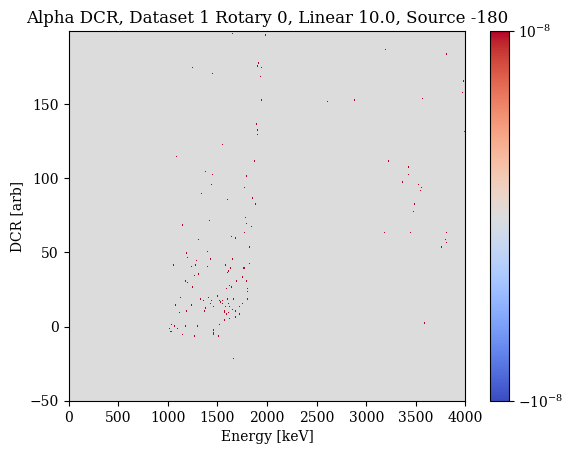

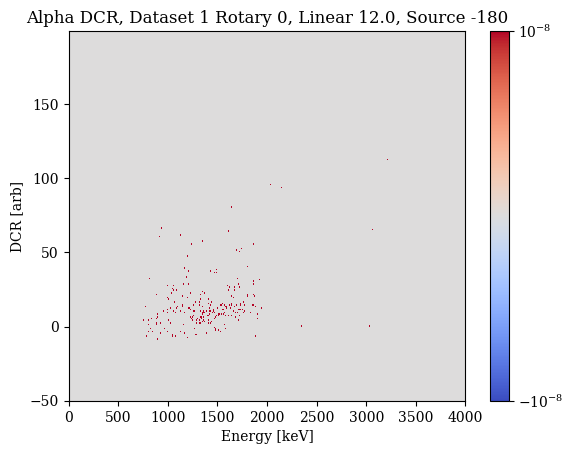

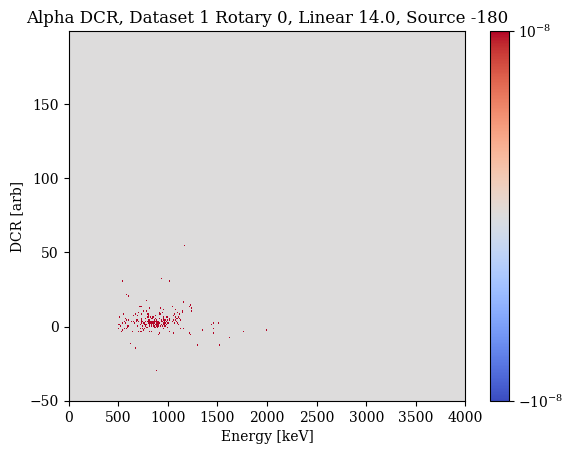

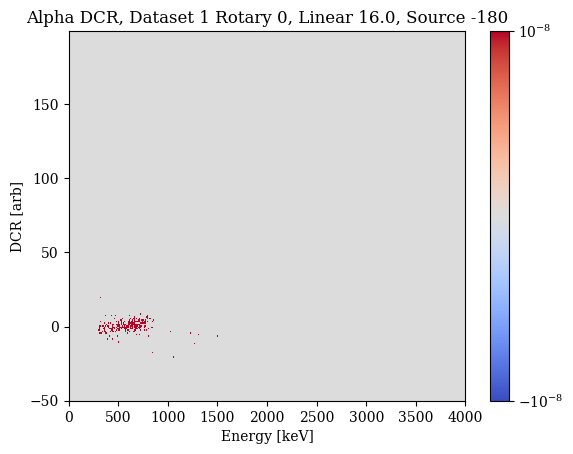

In [66]:
cmap = copy.copy(mpl.colormaps['coolwarm'])
    
for ds in alp_dcr:
    for run in alp_dcr[ds]: 
        rot = rdb_df.loc[run]['rotary']
        lin = rdb_df.loc[run]['linear']
        src = rdb_df.loc[run]['source']

        plt.figure()
        plt.title(f"Alpha DCR, Dataset {ds} Rotary {rot}, Linear {lin}, Source {src}")
        plt.xlabel("Energy [keV]")
        plt.ylabel(f"DCR [arb]")

        plt.hist2d(alp_energy[ds][run], alp_dcr[ds][run], bins=(cal_ebins, dcr_bins),
                                       cmap=cmap, norm=colors.SymLogNorm(linthresh=0.00001, vmin=-1e-8, vmax=1e-8))
        plt.colorbar()
        plt.show()
        plt.close()

### Alpha T/E

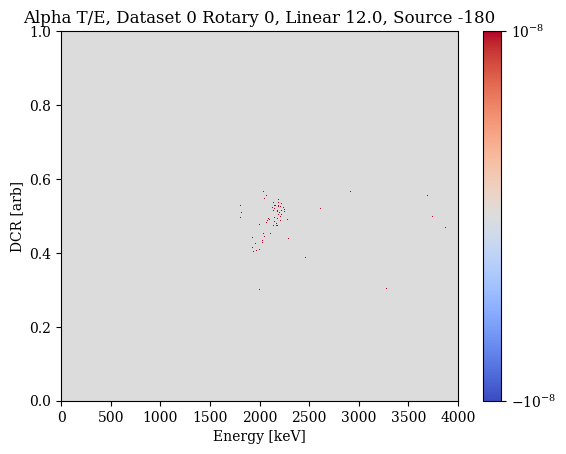

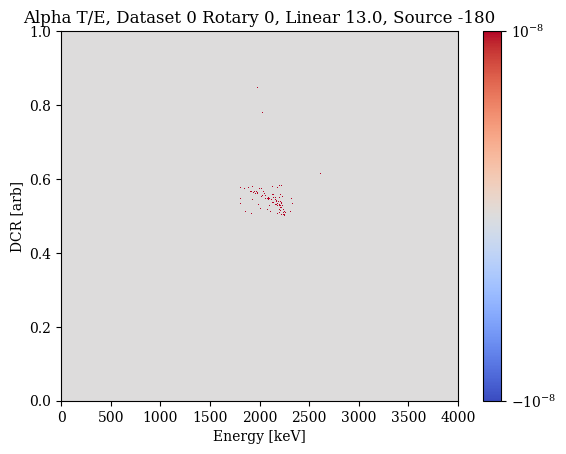

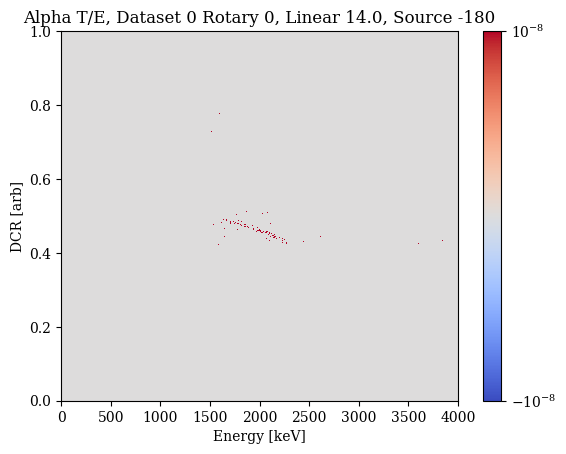

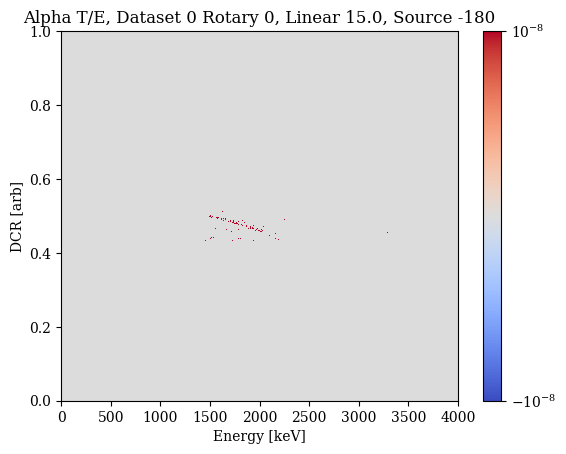

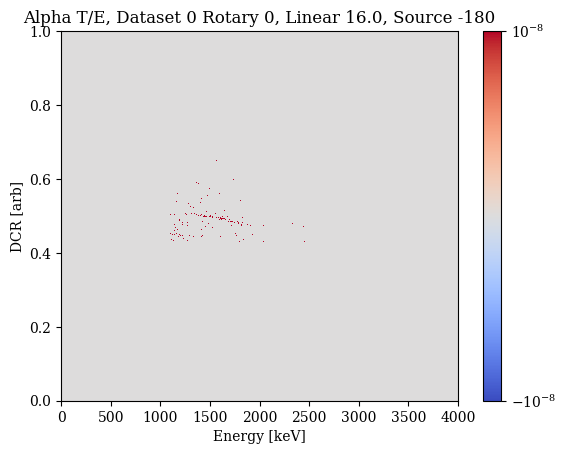

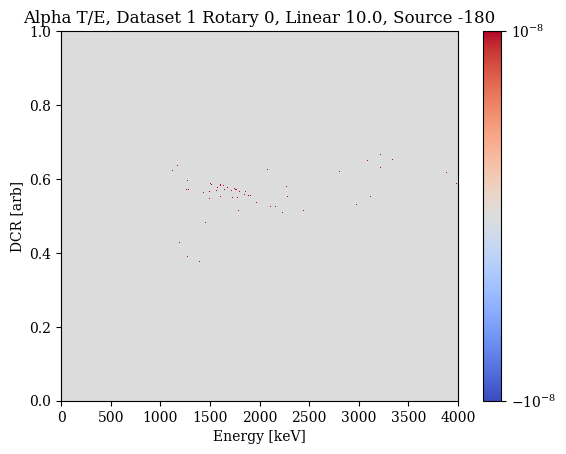

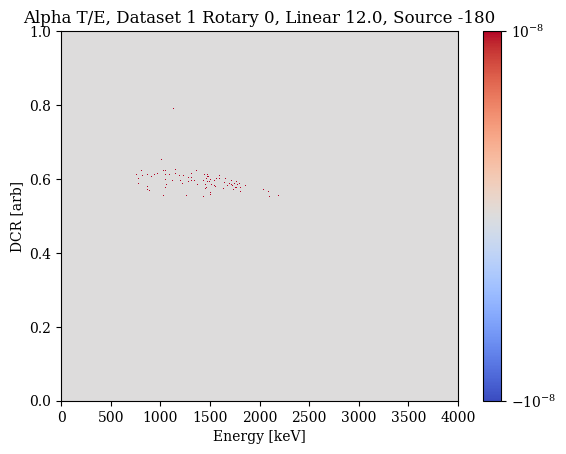

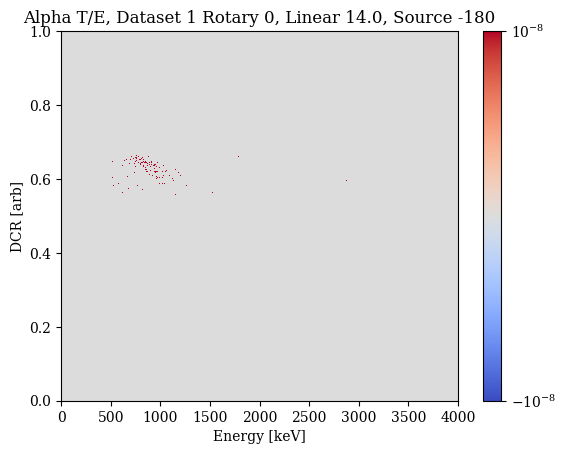

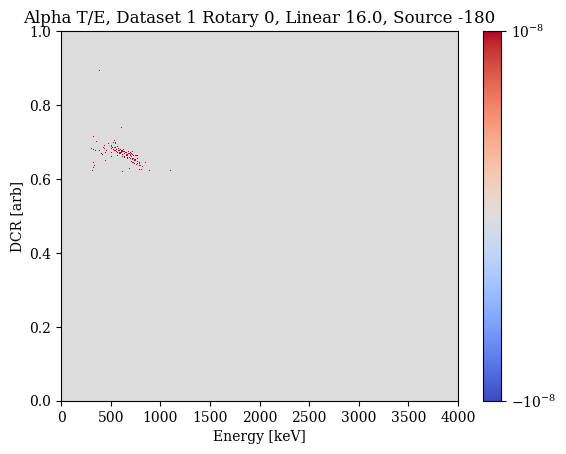

In [67]:
cmap = copy.copy(mpl.colormaps['coolwarm'])
    
for ds in alp_toe:
    for run in alp_toe[ds]: 
        rot = rdb_df.loc[run]['rotary']
        lin = rdb_df.loc[run]['linear']
        src = rdb_df.loc[run]['source']

        plt.figure()
        plt.title(f"Alpha T/E, Dataset {ds} Rotary {rot}, Linear {lin}, Source {src}")
        plt.xlabel("Energy [keV]")
        plt.ylabel(f"DCR [arb]")

        plt.hist2d(alp_energy[ds][run], alp_toe[ds][run], bins=(cal_ebins, toe_bins),
                                       cmap=cmap, norm=colors.SymLogNorm(linthresh=0.00001, vmin=-1e-8, vmax=1e-8))
        plt.colorbar()
        plt.show()
        plt.close()